In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib as mpl
from matplotlib.patches import Patch
import scienceplots
mpl.rcParams["mathtext.default"] = "regular"
from statsmodels.formula.api import mixedlm
import statsmodels.api as sm
from scipy.spatial.distance import jensenshannon
import scipy.stats as stats
# import pymc as pm
# import aesara.tensor as at
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# import arviz as az
# import pytensor.tensor as at

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

COLORS = [ "#bfef45","#3cb44b","#42d4f4","#4363d8","#911eb4","#f032e6","#a9a9a9","#fabed4","#ffd8b1","#fffac8","#aaffc3",
          "#dcbeff", "#800000","#9A6324","#808000","#469990","#000075","#000000","#e6194B","#f58231","#ffe119",
         ]

MARKERS = ["o", "^", "s", "P", "o", "X", "^", "v"]
LINESTYLES = ["solid", "dashed", "dashdot", "dotted"]

mpl.rcParams["hatch.linewidth"] = 0.7
mpl.rcParams.update(mpl.rcParamsDefault)


# Preprocess Data

In [3]:
ball_comp = {(2,2):{'p_col1_u1':0.7, 'p_col2_u1':0.3, 'p_col1_u2':0.3, 'p_col2_u2':0.7}, 
             (2,3):{'p_col1_u1':0.7, 'p_col2_u1':0.2, 'p_col3_u1':0.1, 'p_col1_u2':0.2, 'p_col2_u2':0.1, 'p_col3_u2':0.7},
             (2,4):{'p_col1_u1':0.4, 'p_col2_u1':0.3, 'p_col3_u1':0.2, 'p_col4_u1':0.1, 'p_col1_u2':0.1, 'p_col2_u2':0.2, 'p_col3_u2':0.3, 'p_col4_u2':0.4},
             (3,2):{'p_col1_u1':0.7, 'p_col2_u1':0.3, 'p_col1_u2':0.5, 'p_col2_u2':0.5, 'p_col1_u3':0.3, 'p_col2_u3':0.7},
             (3,3):{'p_col1_u1':0.7, 'p_col2_u1':0.2, 'p_col3_u1':0.1, 'p_col1_u2':0.1, 'p_col2_u2':0.7, 'p_col3_u2':0.2, 'p_col1_u3':0.2, 'p_col2_u3':0.1, 'p_col3_u3':0.7},
             (3,4):{'p_col1_u1':0.4, 'p_col2_u1':0.3, 'p_col3_u1':0.2, 'p_col4_u1':0.1, 'p_col1_u2':0.3, 'p_col2_u2':0.2, 'p_col3_u2':0.2, 'p_col4_u2':0.3, 'p_col1_u3':0.1, 'p_col2_u3':0.2, 'p_col3_u3':0.3, 'p_col4_u3':0.4},
             (4,2):{'p_col1_u1':0.7, 'p_col2_u1':0.3, 'p_col1_u2':0.6, 'p_col2_u2':0.4, 'p_col1_u3':0.4, 'p_col2_u3':0.6, 'p_col1_u4':0.3, 'p_col2_u4':0.7},
             (4,3):{'p_col1_u1':0.7, 'p_col2_u1':0.2, 'p_col3_u1':0.1, 'p_col1_u2':0.1, 'p_col2_u2':0.7, 'p_col3_u2':0.2, 'p_col1_u3':0.2, 'p_col2_u3':0.1, 'p_col3_u3':0.7, 'p_col1_u4':0.3, 'p_col2_u4':0.4, 'p_col3_u4':0.3},
             (4,4):{'p_col1_u1':0.4, 'p_col2_u1':0.3, 'p_col3_u1':0.2, 'p_col4_u1':0.1, 'p_col1_u2':0.3, 'p_col2_u2':0.4, 'p_col3_u2':0.1, 'p_col4_u2':0.2, 'p_col1_u3':0.2, 'p_col2_u3':0.1, 'p_col3_u3':0.4, 'p_col4_u3':0.3, 'p_col1_u4':0.1, 'p_col2_u4':0.2, 'p_col3_u4':0.3, 'p_col4_u4':0.4}
}

## Read Data

In [4]:
def read_participant_data(filePath, min_pID, max_pID, insList):
    ''''
    Reads participant data main experiment data from JSON files and combines them into a single DataFrame.
    '''
    participantsWithData = []
    for pID in range(min_pID, max_pID+1):
        completed = True
        for instance_name in insList:
            try:
                with open(filePath + f'participantData{pID}/p{pID}BU{instance_name}.json') as f:
                    data = json.load(f)
                    df = pd.json_normalize(data)
                    if 'participant_data' not in locals():
                        participant_data = df
                    else:
                        participant_data = pd.concat([participant_data, df], ignore_index=True)
                
            except FileNotFoundError:
                completed = False
                
        if completed:
            participantsWithData.append(pID)

    print(f'Participants with complete data: {participantsWithData}')
    incomplete_data_participants = [pID for pID in participant_data["participantID"].unique() if int(pID) not in participantsWithData]
    print(f'Participants with incomplete data: {incomplete_data_participants}')
    return participant_data, incomplete_data_participants

In [5]:
# Read participant data from json
min_pID = 1
max_pID = 118
insList = [1,3,5,7,9,11,12,13,15,16,17,18]
filePath = '../participantData/'

participant_data, incomplete_lis = read_participant_data(filePath, min_pID, max_pID, insList)

Participants with complete data: [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 75, 77, 79, 80, 81, 82, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118]
Participants with incomplete data: ['2345', '1576998']


### Participant ID correction
correct all the pID that participants entered wrongly

In [6]:
print(participant_data['participantID'].unique())
participant_data['participantID'] = participant_data['participantID'].replace({'2345': '22', '1576998': '38'})
print(participant_data['participantID'].unique())


['1' '2' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16' '17'
 '18' '19' '20' '21' '2345' '23' '24' '25' '26' '27' '28' '29' '30' '31'
 '32' '33' '34' '35' '37' '1576998' '39' '40' '41' '42' '44' '46' '47'
 '49' '50' '51' '52' '53' '54' '55' '56' '57' '58' '59' '60' '61' '62'
 '63' '64' '65' '66' '67' '68' '69' '71' '72' '73' '75' '77' '79' '80'
 '81' '82' '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97'
 '98' '99' '100' '101' '102' '103' '104' '105' '106' '107' '108' '109'
 '110' '112' '113' '114' '115' '116' '117' '118']
['1' '2' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16' '17'
 '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30' '31'
 '32' '33' '34' '35' '37' '38' '39' '40' '41' '42' '44' '46' '47' '49'
 '50' '51' '52' '53' '54' '55' '56' '57' '58' '59' '60' '61' '62' '63'
 '64' '65' '66' '67' '68' '69' '71' '72' '73' '75' '77' '79' '80' '81'
 '82' '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97' '98'
 '99' '100' '101' '10

### change participant ID data type to int

In [7]:
participant_data['participantID'] = participant_data['participantID'].astype(int)

### Read the Demographic Data - Combine with main data

In [8]:
def read_demographic_data(filePath, min_pID, max_pID):
    '''
    Reads demographic data from CSV files and combines them into a single DataFrame.
    '''
    demo_df = pd.DataFrame()
    for pID in range(min_pID, max_pID+1):
        try:
            df = pd.read_csv(filePath + f'participantData{pID}/demographicData/p{pID}.csv')
            demo_df = pd.concat([demo_df, df[['participantID','payID','fullName','age','sex','probSubject','bayesFamaliar','bayesInExp']]], ignore_index=True)
        except FileNotFoundError:
            print(f'File not found for participant {pID}')

    return demo_df

# Read demographic data from csv
demo_df = read_demographic_data(filePath, min_pID, max_pID)
demo_df['participantID'] = demo_df['participantID'].astype(int)
demo_df[-30:]

File not found for participant 3
File not found for participant 36
File not found for participant 43
File not found for participant 45
File not found for participant 48
File not found for participant 70
File not found for participant 74
File not found for participant 76
File not found for participant 78
File not found for participant 83
File not found for participant 84
File not found for participant 85
File not found for participant 111


participantID                         payID  \
75              88                     478451900   
76              89                     421241759   
77              90                     401371091   
78              91                     448342856   
79              92                     431292337   
80              93                     410384238   
81              94           mfarissya@gmail.com   
82              95                     413523755   
83              96  raizulfikar.satria@gmail.com   
84              97                     481814964   
85              98                     403211131   
86              99                     413754819   
87             100                     432941968   
88             101                     422197168   
89             102    vishalraghavanns@gmail.com   
90             103                     400175982   
91             104                   61421992515   
92             105                     421992515   
93             106                     432192713   
94             107                   61421490623   
95             108                     466216747   
96             109                     460948942   
97             110                     422001984   
98             112      putri.chaniago@gmail.com   
99             113                     411611938   
100            114                     490889867   
101            115                     416229528   
102            116                     469787934   
103            117                     412867884   
104            118                     456476615   

                              fullName  age                sex probSubject  \
75                       Yin Jie Yoong   21               Male         Yes   
76                       Andien Kirana   22             Female         Yes   
77                    Antonia Hermawan   32             Female          No   
78                      Chloe Schaller   19             Female          No   
79             Daniel Evan Christopher   25               Male         Yes   
80                             Minh Do   21             Female         Yes   
81     Mirza Farissya Binti Mohd Anuar   22             Female          No   
82                          Nidhi Modi   26             Female          No   
83             Rai Zulfikar Satriagama   23               Male         Yes   
84               Rendra Kusuma Wardana   31               Male         Yes   
85                          Ryan Chang   22               Male          No   
86                      Seishya Elzila   27             Female          No   
87                       Ting-Hsuan Wu   36               Male         Yes   
88        Tyas Tri Mur Wahyu Setyorini   31             Female          No   
89   Vishal Raghavan Nadipuram Sundara   24               Male          No   
90                           Xinyi Mao   23             Female         Yes   
91            Hayley Louise Winchcombe   28             Female          No   
92                       Chiquita Shaw   27             Female         Yes   
93                Farah Alisya Mundzir   19             Female          No   
94                       Hemani Tiwari   19             Female          No   
95                 Hernanto Adwiluvito   31               Male         Yes   
96                  Loren Angelou Cruz   28             Female         Yes   
97         Muhammad Farrel Mahran Arry   24               Male          No   
98                  Putri Rizki Arlita   37             Female          No   
99                         Qinyi Zhong   36             Female          No   
100                        Rosalind Ge   28             Female          No   
101                        Uyen Nguyen   20  Prefer Not To Say          No   
102            Viyagula Varsha Vedaraj   26             Female         Yes   
103                Wanda Mustika Rahim   32             Female          No   
104                     Zoe Goodenough   20         

In [9]:
participant_data = pd.merge(participant_data, demo_df, on='participantID', how='left')

## Disaggregate Posteriors

In [10]:
def disaggregatePosteriors(participant_data, urn_names, col_names):
    for idx, row in participant_data.iterrows():
        for i in range(len(row['urnPosteriors'])):
            participant_data.at[idx, urn_names[i]+'_r'] = row['urnPosteriors'][i]
    
        for j in range(len(row['colourPosteriors'])):
            participant_data.at[idx, col_names[j]+'_r'] = row['colourPosteriors'][j]
            

In [11]:
max_urns = 4
max_colours = 4
urn_names = ['uA', 'uB', 'uC', 'uD']
col_names = ['cB', 'cW', 'cP', 'cG']

disaggregatePosteriors(participant_data, urn_names, col_names)

## Reproduce the number of urns and number of colours

In [12]:
participant_data['urns'] = participant_data['urnPosteriors'].apply(lambda x: len(x))
participant_data['colours'] = participant_data['colourPosteriors'].apply(lambda x: len(x))

## Read Correct Answer from File

Note: Need to change the file in the working directory if the input file is changed for my experiment

In [13]:
def read_correctAnswers():
    with open('obj_posteriors.json') as f:
        correctAnswers = json.load(f)
        return correctAnswers
    
correctAnswers = read_correctAnswers()

## Add Correct Probabilities to the df

In [14]:
def addCorrectAnswers(participant_data, urn_names, col_names):
    for idx, row in participant_data.iterrows():
        for i in range(len(row['urnPosteriors'])):
            participant_data.at[idx, urn_names[i]+'_c'] = correctAnswers[row['instanceName']][f'posterior_u{i+1}_draw{row["seqBall"]}'] *100
    
        for j in range(len(row['colourPosteriors'])):
            participant_data.at[idx, col_names[j]+'_c'] = correctAnswers[row['instanceName']][f'posterior_col{j+1}_draw{row["seqBall"]}'] *100

addCorrectAnswers(participant_data, urn_names, col_names)

## Calculate Step-wise Bayesian Posteriors

### Get the last reported posterior

In [15]:
participant_data['urnPosteriors-1'] = participant_data['urnPosteriors'].shift(1)

In [16]:
def bayesian_Updating_Urns_StepWise(num_urns, num_col, seqBall, ball_draws, prior, ball_comp = dict()):
    '''
    num_urns: number of urns in the experiment
    num_cols: number of ball colours in the experiment
    seqBall: number of sequential ball draws
    ball_draws: a list of ball draw event outcomes. e.g. ['col1','col2']
    prior: a list of the reported posterior from the previous draw e.g.[45.0, 55.0]	
    ball_comp: a dictionary of ball compositions in each urn. Key: (num_urns, num_cols), Values: a dictionary with keys being name of the conditional probability (e.g.p_col1_u1 probability of colour = 1 conditional on urn = 1) values being conditional probability
    output: a rounded (2 decimal points) dictionary of posterior
    '''
    assert type(num_urns) == int, "num_urns must be integer"
    assert type(num_col) == int, "num_col must be integer"
    assert type(ball_comp) == dict, "ball_comp must be a pre-defined dictionary of ball compositions"

    # initialize priors

    if seqBall == 1:
        prior_dict = {}
        for urn in range(1, num_urns+1):
            prior_dict[f"prior_u{urn}"] = 1/num_urns
    else:
        prior_dict = {}
        for urn in range(1, num_urns+1):
            prior_dict[f"prior_u{urn}"] = prior[urn-1]/100    

    # get ball composition probabilities - Likelihood
    relevant_p = ball_comp[(num_urns,num_col)]

    # Sequential Ball Draws using Bayesian Updating
    evidence_dict = {}
    for col in range(1, num_col+1):
        sum = 0
        for urn in range(1, num_urns+1):
            sum += prior_dict[f"prior_u{urn}"] * relevant_p[f"p_col{col}_u{urn}"]

        evidence_dict[f"p_col{col}"] = sum
    # calculate posterior
    posterior_dict = {}
    event =  ball_draws[seqBall-1]
    for urn in range(1, num_urns+1):
        posterior_dict[f"u{urn}"] = (prior_dict[f"prior_u{urn}"] * relevant_p[f"p_{event}_u{urn}"]) / evidence_dict[f"p_{event}"]


    rounded_dict = {key: round(value, 2) for key, value in posterior_dict.items()}    


    return rounded_dict

### Get ball draw events from input

In [17]:
# read JSON input file
filename = 'input.json'
with open(filename) as json_file:
    data = json.load(json_file)

# calculate posteriors for all instances
name_cols = ['B','W','P','G']
data_list = []

for instance in data:
    # key is 'BU1', value is a dictionary of urn info: urnName, prior, composition, balls, chosenUrn, ballDraws
    for key, value in instance.items():
        ball_draws = value['ballDraws']

        # Create a dictionary that maps each color name to "col1", "col2", etc.
        color_mapping = {color: f"col{i+1}" for i, color in enumerate(name_cols)}
        # Map each color in color_list to its corresponding label
        mapped_ball_draws = [color_mapping[color] for color in ball_draws]
        
        # Append to data list
        data_list.append({'instanceName': key, 'ballDrawCol': mapped_ball_draws})

# Create dataframe
ballDrawCol_df = pd.DataFrame(data_list)

participant_data = pd.merge(participant_data, ballDrawCol_df, on='instanceName')


In [18]:
participant_data['urnPosSW'] = participant_data.apply(lambda x: bayesian_Updating_Urns_StepWise(x['urns'], x['colours'], x['seqBall'], x['ballDrawCol'], x['urnPosteriors-1'],ball_comp), axis=1)

### Step-wise Colour Posterior Updating

In [19]:
def ColGuess_StepWise(num_urns, num_col, urn_posteriors=dict(), ball_comp=dict()):
    '''
    Given the urn posteriors and urn composition, using weighted average method to guess the next ball draw colour
    Input: 
    num_urns: number of urns in the experiment
    num_cols: number of ball colours in the experiment
    urn_posteriors: updated urn posteriors dictionary after each ball draw
    ball_comp: a dictionary of ball compositions in each urn. Key: (num_urns, num_cols), Values: a dictionary with keys being name of the conditional probability (e.g.p_col1_u1 probability of colour = 1 conditional on urn = 1) values being conditional probability
    
    Output: a dictionary of the guessed colour
    '''

    assert type(num_urns) == int, "num_urns must be integer"
    assert type(num_col) == int, "num_col must be integer"

    col_posteriors = {}
    # calculate the weighted average for each colour

    for col in range(1, num_col+1):
        sum = 0
        for urn in range(1, num_urns+1):
            sum += urn_posteriors[urn-1]/100 * ball_comp[(num_urns,num_col)][f"p_col{col}_u{urn}"]
        
        col_posteriors[f"c{col}"] = sum
    
    rounded_dict = {key: round(value, 2) for key, value in col_posteriors.items()}

    return rounded_dict

In [20]:
participant_data['colPosSW'] = participant_data.apply(lambda x: ColGuess_StepWise(x['urns'], x['colours'], x['urnPosteriors'],ball_comp), axis=1)

### Expand Columns

In [21]:
# Function to expand urnPosSW column into separate columns
def expand_urnPosSW(row):
    urnPosSW = row['urnPosSW']
    row['uA_s'] = urnPosSW.get('u1', np.nan)
    row['uB_s'] = urnPosSW.get('u2', np.nan)
    row['uC_s'] = urnPosSW.get('u3', np.nan)
    row['uD_s'] = urnPosSW.get('u4', np.nan)
    return row

def expand_colPosSW(row):
    urnPosSW = row['colPosSW']
    row['cB_s'] = urnPosSW.get('c1', np.nan)
    row['cW_s'] = urnPosSW.get('c2', np.nan)
    row['cP_s'] = urnPosSW.get('c3', np.nan)
    row['cG_s'] = urnPosSW.get('c4', np.nan)
    return row
# Apply the function to each row in the dataframe
participant_data = participant_data.apply(expand_urnPosSW, axis=1)
participant_data = participant_data.apply(expand_colPosSW, axis=1)

# Drop the original urnPosSW column if no longer needed
participant_data.drop(columns=['urnPosSW','urnPosteriors-1','ballDrawCol','colPosSW'], inplace=True)


## Calculate Absolute Difference between reported answer and correct answer

In [22]:
participant_data['diff_uA'] = abs(participant_data['uA_r'] - participant_data['uA_c'])
participant_data['diff_uB'] = abs(participant_data['uB_r'] - participant_data['uB_c'])
participant_data['diff_uC'] = abs(participant_data['uC_r'] - participant_data['uC_c'])
participant_data['diff_uD'] = abs(participant_data['uD_r'] - participant_data['uD_c'])
participant_data['diff_cB'] = abs(participant_data['cB_r'] - participant_data['cB_c'])
participant_data['diff_cW'] = abs(participant_data['cW_r'] - participant_data['cW_c'])
participant_data['diff_cP'] = abs(participant_data['cP_r'] - participant_data['cP_c'])
participant_data['diff_cG'] = abs(participant_data['cG_r'] - participant_data['cG_c'])

## Calculate JSD Distance

In [6]:
def JSD(row, lis1, lis2):
    vec1 = row[lis1].to_numpy(dtype=float)
    vec2 = row[lis2].to_numpy(dtype=float)
    vec1 = np.nan_to_num(vec1)
    vec2 = np.nan_to_num(vec2)
    return jensenshannon(vec1, vec2, base=2)


participant_data['JSD_U_rc'] = participant_data.apply(lambda x: JSD(x, ['uA_r', 'uB_r', 'uC_r', 'uD_r'], ['uA_c', 'uB_c', 'uC_c', 'uD_c']), axis=1)
participant_data['JSD_C_rc'] = participant_data.apply(lambda x: JSD(x, ['cB_r', 'cW_r', 'cP_r', 'cG_r'], ['cB_c', 'cW_c', 'cP_c', 'cG_c']), axis=1)
participant_data['JSD_U_rs'] = participant_data.apply(lambda x: JSD(x, ['uA_r', 'uB_r', 'uC_r', 'uD_r'], ['uA_s', 'uB_s', 'uC_s', 'uD_s']), axis=1)
participant_data['JSD_C_rs'] = participant_data.apply(lambda x: JSD(x, ['cB_r', 'cW_r', 'cP_r', 'cG_r'], ['cB_s', 'cW_s', 'cP_s', 'cG_s']), axis=1)



## Calculate Decision Quality

### Overall Decision Quality

In [24]:
participant_data['DQ_U_o'] = 1 - participant_data['JSD_U_rc'] 
participant_data['DQ_C_o'] = 1 - participant_data['JSD_C_rc']

### Step-wise Decision Quality

In [25]:
participant_data['DQ_U_s'] = 1 - participant_data['JSD_U_rs']
participant_data['DQ_C_s'] = 1 - participant_data['JSD_C_rs']

## Calculate Computational Complexity

In [26]:
def calculate_StepWise_complexity():
    '''
    total complexity treats MD and AS equally
    MD complexity quantify MD only and ignore AS
    weighted complexity count MD as 2 Basic operations and AS as 1 Basic operation
    '''
    for idx, row in participant_data.iterrows():
        num_urns = len(row['urnPosteriors'])
        num_colours = len(row['colourPosteriors'])

        if row['seqBall'] == 1:
            urn_complexity_total = min(2 * num_urns, 2 * (num_urns - 1) + (num_urns - 1) )
            urn_complexity_MD = 2 * (num_urns - 1)
            urn_complexity_weighted = min(4 * num_urns, 4 * (num_urns - 1) + (num_urns - 1) )
        else:
            urn_complexity_total = min(5*num_urns - 4, 4*num_urns - 1)
            urn_complexity_MD = 3*num_urns - 2
            urn_complexity_weighted = min(8*num_urns - 6, 7*num_urns - 1)
        
        col_complexity_total = min(num_colours * (num_urns + (num_urns - 1)), (num_colours-1)* (num_urns + (num_urns - 1)) + (num_colours-1))
        col_complexity_MD =  (num_colours-1) * num_urns
        col_complexity_weighted =  min(num_colours * (2*num_urns + (num_urns - 1)), (num_colours-1)* (2*num_urns + (num_urns - 1)) + (num_colours-1))

        participant_data.at[idx, 'EWCC_u'] = urn_complexity_total
        participant_data.at[idx, 'MDCC_u'] = urn_complexity_MD
        participant_data.at[idx, 'CC_u'] = urn_complexity_weighted
        participant_data.at[idx, 'EWCC_c'] = col_complexity_total
        participant_data.at[idx, 'MDCC_c'] = col_complexity_MD
        participant_data.at[idx, 'CC_c'] = col_complexity_weighted




calculate_StepWise_complexity()

### Calculate Accumulated Computational Complexity

In [27]:
participant_data['EWCC_u_-1'] = participant_data['EWCC_u'].shift(1)
participant_data['EWCC_u_-2'] = participant_data['EWCC_u'].shift(2)
participant_data['MDCC_u_-1'] = participant_data['MDCC_u'].shift(1)
participant_data['MDCC_u_-2'] = participant_data['MDCC_u'].shift(2)
participant_data['CC_u_-1'] = participant_data['CC_u'].shift(1)
participant_data['CC_u_-2'] = participant_data['CC_u'].shift(2)
participant_data['EWCC_c_-1'] = participant_data['EWCC_c'].shift(1)
participant_data['EWCC_c_-2'] = participant_data['EWCC_c'].shift(2)
participant_data['MDCC_c_-1'] = participant_data['MDCC_c'].shift(1)
participant_data['MDCC_c_-2'] = participant_data['MDCC_c'].shift(2)
participant_data['CC_c_-1'] = participant_data['CC_c'].shift(1)
participant_data['CC_c_-2'] = participant_data['CC_c'].shift(2)

In [28]:
def calculate_ACC(row,CC_col_name):
    '''
    Calculate the ACC for each participant
    '''
    if row['seqBall'] == 1:
        return row[CC_col_name]
    elif row['seqBall'] == 2:
        return row[CC_col_name] + row[f'{CC_col_name}_-1']
    else:
        return row[CC_col_name] + row[f'{CC_col_name}_-1'] + row[f'{CC_col_name}_-2']

participant_data['ACC_u'] = participant_data.apply(lambda x: calculate_ACC(x,'CC_u'), axis=1)
participant_data['ACC_c'] = participant_data.apply(lambda x: calculate_ACC(x,'CC_c'), axis=1)
participant_data['AEWCC_u'] = participant_data.apply(lambda x: calculate_ACC(x,'EWCC_u'), axis=1)
participant_data['AEWCC_c'] = participant_data.apply(lambda x: calculate_ACC(x,'EWCC_c'), axis=1)
participant_data['AMDCC_u'] = participant_data.apply(lambda x: calculate_ACC(x,'MDCC_u'), axis=1)
participant_data['AMDCC_c'] = participant_data.apply(lambda x: calculate_ACC(x,'MDCC_c'), axis=1)


### Remove BU prefix in the instanceName column

In [29]:
participant_data['instanceName'] = participant_data['instanceName'].str.replace('BU', '').astype(int)

### Convert step-wise Bayesian factor into percentage point

In [30]:
def prob_to_percentagePoint(row):
    row['uA_s'] = row['uA_s'] * 100
    row['uB_s'] = row['uB_s'] * 100
    row['uC_s'] = row['uC_s'] * 100
    row['uD_s'] = row['uD_s'] * 100
    row['cB_s'] = row['cB_s'] * 100
    row['cW_s'] = row['cW_s'] * 100
    row['cP_s'] = row['cP_s'] * 100
    row['cG_s'] = row['cG_s'] * 100
    return row

participant_data = participant_data.apply(prob_to_percentagePoint, axis=1)

### Delete Redundent Data

In [233]:
participant_data.drop(columns=['urnPosteriors', 'colourPosteriors', 'EWCC_u_-1', 'EWCC_u_-2', 'MDCC_u_-1', 'MDCC_u_-2', 'CC_u_-1', 'CC_u_-2', 'EWCC_c_-1', 'EWCC_c_-2', 'MDCC_c_-1', 'MDCC_c_-2', 'CC_c_-1', 'CC_c_-2'], inplace=True)

### Create Dummy Variables for seqBalls

In [234]:
# Create three new columns for the dependent variables based on seqBall values
participant_data['DV_seqBall_1'] = (participant_data['seqBall'] == 1).astype(int)
participant_data['DV_seqBall_2'] = (participant_data['seqBall'] == 2).astype(int)
participant_data['DV_seqBall_3'] = (participant_data['seqBall'] == 3).astype(int)


In [235]:
# display(participant_data)
# participant_data.to_csv('participant_data.csv', index=False)

# Balance the Observations for each Complexity

Create dataframe for my experimental design parameters per pre-registration requirement

In [236]:
# participant_data.columns

In [237]:
# # 12 Instances: each have 3 ball draws so 36 rows per participant
# selected_col = ['CC_u', 'CC_c','ACC_u', 'ACC_c']
# complexity_df = participant_data.groupby(['instanceName', 'seqBall'])[selected_col].mean().reset_index()
# complexity_df



In [238]:
# instance_info_df = pd.read_csv('Instance_level_design.csv')

In [239]:
# design_df = pd.merge(complexity_df, instance_info_df, left_on='instanceName', right_on='Instance', how='left').drop(columns=['Instance'])
# design_df

In [240]:
# Current Design data frequency per complexity level
# complexity_cols = [ 'CC_u', 'CC_c']
# for col in complexity_cols:
#     print(design_df[col].value_counts().sort_index())

In [241]:
# design_df.groupby(['instanceName','seqBall'])[complexity_cols].mean()

In [242]:
# # drop 1 instance
# drop_lis = [1,3,5,7,9,11,13,15,17]
# for i in drop_lis:
#     print(f'Dropping instance {i}')
#     temp_df = design_df[~design_df['instanceName'].isin([i])]
#     for col in complexity_cols:
#         print(temp_df[col].value_counts().sort_index())

In [243]:
# # Let drop several instance 
# test_df = design_df[~design_df['instanceName'].isin([4,6,8,10,12,16])]
# for col in complexity_cols:
#     print(test_df[col].value_counts().sort_index())

In [244]:
# # test_df.drop(columns=['instanceName'], inplace=True)
# test_df.to_csv('design_df.csv', index=False)

# Data Operations

### Exclude Participants
ID 23 is excluded since cheating and usage of calculator

In [245]:
participant_data = participant_data[participant_data['participantID'] != 23]

## Experiment Payment

In [246]:
def random_select_rounds(participant_data, num_rounds):
    '''
    Randomly select num_rounds from each participant
    '''
    selected_rounds = participant_data.groupby('participantID').apply(lambda x: x.sample(n=num_rounds)).reset_index(drop=True)
    columns_needed = ['participantID', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG']
    selected_rounds = selected_rounds[columns_needed]
    return selected_rounds

def random_select_responseDifferences(selected_rounds, num_selection):
    '''
    Randomly select num_selection from selected rounds for each participant
    '''
    candidate_columns = ['diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG']

    for idx, row in selected_rounds.iterrows():
        selected_column = np.random.choice(candidate_columns, num_selection)
        selected_diff = row[selected_column[0]]
        # make sure the selected diff is not NAN
        while np.isnan(selected_diff):
            selected_column = np.random.choice(candidate_columns, num_selection)
            selected_diff = row[selected_column[0]]

        selected_rounds.at[idx, 'selected_diff'] = selected_diff
    
def calculate_bonus(selected_rounds, bonusMultiplier):
    
    for idx, row in selected_rounds.iterrows():
        bonus = max(0, 10 - bonusMultiplier * row['selected_diff'])
        selected_rounds.at[idx, 'bonus'] = bonus
    
def calculate_payment(selected_rounds, showUpFee):
    payment = selected_rounds.groupby('participantID')['bonus'].sum() + showUpFee
    return round(payment,None)
    

`Individual Payments In case people are interested`

In [247]:
# num_rounds = 4
# num_selection = 1
# showUpFee = 10
# bonusMultiplier = 1
# selected_rounds = random_select_rounds(participant_data, num_rounds)
# random_select_responseDifferences(selected_rounds, num_selection)
# calculate_bonus(selected_rounds, bonusMultiplier)
# calculate_payment(selected_rounds, showUpFee)


In [248]:
# # Get df to Liz for payment
# id_start = 106
# id_end = 118

# payment = pd.DataFrame(calculate_payment(selected_rounds, showUpFee))
# payment = payment['bonus'].rename('payment', inplace=True)

# payment_df = pd.merge(payment, demo_df, on='participantID', how='left')

# payment_df = payment_df[payment_df['participantID'].isin(range(id_start, id_end+1))]

# selected_col = ['payment', 'fullName', 'payID']
# payment_df = payment_df[selected_col]

# # Only include participants that are not paid before
# # ID: 1-20 paid
# # ID: 21-42 paid
# # ID: 43-64 paid
# # ID: 65-88 paid
# # ID: 89-103 paid
# # ID: 104-105 paid
# # ID: 106-118 not paid

# payment_df.to_csv(f'payment_Andy_{id_start}to{id_end}.csv', index=False)


#### Payment Simulation: simulate the random bonus draw 1000 times and report the average payment to participants

In [249]:
# sim_num = 100
# payment_lis = []
# for i in range(sim_num):
#     selected_rounds = random_select_rounds(participant_data, num_rounds)
#     random_select_responseDifferences(selected_rounds, num_selection)
#     calculate_bonus(selected_rounds, bonusMultiplier)
#     # average payment across individuals for each experiment iteration
#     payment = calculate_payment(selected_rounds, showUpFee)
#     avg_payment = payment.mean()
#     payment_lis.append(avg_payment)

# print(f'Average payment after 100 simulations: {np.mean(payment_lis)}')


## Cleaning Before Analysis

### Drop participant info

In [250]:
participant_data.drop(columns=['payID', 'fullName'], inplace=True)

### Create DV for bayes rule in exp

In [251]:
def DV_bayesInExp(row):
    '''
    This function maps Never and Not Applicable to No, Sometimes and Always to Yes
    '''
    if row['bayesInExp'] == 'Never' or row['bayesInExp'] == 'Not Applicable':
        return 'No'
    elif row['bayesInExp'] == 'Sometimes' or row['bayesInExp'] == 'Always':
        return 'Yes'
    else:
        raise ValueError(f"Unexpected value in bayesInExp: {row['bayesInExp']}")

participant_data['DV_bayesInExp'] = participant_data.apply(DV_bayesInExp, axis=1)

### Save file

In [252]:
display(participant_data)
participant_data.to_csv('participant_data.csv', index=False)

participantID  instanceName  seqBall  responseTimeUrn  \
0                 1             1        1            22.43   
1                 1             1        2            10.50   
2                 1             1        3             7.27   
3                 2             1        1            13.30   
4                 2             1        2            11.68   
...             ...           ...      ...              ...   
3775            117            18        2            34.62   
3776            117            18        3            79.35   
3777            118            18        1            30.47   
3778            118            18        2            26.90   
3779            118            18        3            68.98   

      responseTimeColour  age     sex probSubject bayesFamaliar  \
0                  11.40   18  Female          No           Yes   
1                  10.10   18  Female          No           Yes   
2                  13.47   18  Female          No           Yes   
3                  20.47   31  Female          No            No   
4                  37.35   31  Female          No            No   
...                  ...  ...     ...         ...           ...   
3775               46.30   32  Female          No            No   
3776               47.35   32  Female          No            No   
3777              147.07   20  Female         Yes           Yes   
3778               33.02   20  Female         Yes           Yes   
3779              145.42   20  Female         Yes           Yes   

          bayesInExp  uA_r  uB_r  cB_r  cW_r  cP_r  cG_r  uC_r  uD_r  urns  \
0              Never 30.00 70.00 45.00 55.00   NaN   NaN   NaN   NaN     2   
1              Never 70.00 30.00 55.00 45.00   NaN   NaN   NaN   NaN     2   
2              Never 30.00 70.00 45.00 55.00   NaN   NaN   NaN   NaN     2   
3              Never 30.00 70.00 33.00 67.00   NaN   NaN   NaN   NaN     2   
4              Never 40.00 60.00 22.00 78.00   NaN   NaN   NaN   NaN     2   
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3775  Not Applicable  9.00 16.00 14.00 24.00 31.00 31.00 38.00 37.00     4   
3776  Not Applicable 16.00 15.00 13.00 19.00 34.00 34.00 41.00 28.00     4   
3777       Sometimes 10.00 20.00 10.00 15.00 35.00 40.00 30.00 40.00     4   
3778       Sometimes 10.00 10.00 10.00 10.00 40.00 40.00 40.00 40.00     4   
3779       Sometimes 12.00  8.00 17.00 14.00 36.00 33.00 45.00 35.00     4   

      colours  uA_c  uB_c  cB_c  cW_c  cP_c  cG_c  uC_c  uD_c  uA_s  uB_s  \
0           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 30.00 70.00   
1           2 50.00 50.00 50.00 50.00   NaN   NaN   NaN   NaN 50.00 50.00   
2           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 50.00 50.00   
3           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 30.00 70.00   
4           2 50.00 50.00 50.00 50.00   NaN   NaN   NaN   NaN 50.00 50.00   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3775        4  7.00  7.00 18.00 18.00 32.00 32.00 43.00 43.00  7.00  7.00   
3776        4  4.00  2.00 17.00 15.00 34.00 33.00 53.00 40.00  6.00  5.00   
3777        4 10.00 20.00 20.00 22.00 28.00 30.00 30.00 40.00 10.00 20.00   
3778        4  7.00  7.00 18.00 18.00 32.00 32.00 43.00 43.00  7.00  7.00   
3779        4  4.00  2.00 17.00 15.00 34.00 33.00 53.00 40.00  6.00  3.00   

      uC_s  uD_s  cB_s  cW_s  cP_s  cG_s  diff_uA  diff_uB  diff_uC  diff_uD  \
0      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
1      NaN   NaN 58.00 42.00   NaN   NaN    20.00    20.00      NaN      NaN   
2      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
3      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
4      NaN   NaN 46.00 54.00   NaN   NaN    10.00    10.00      NaN      NaN   
...    ...   ...   ...   ...   ...   ...      ...      ...      ...      ...   
3775 43.00 43.00 20.00

## Summary Statistics

### Convert all possible columns to numeric

In [253]:
participant_data = participant_data.apply(pd.to_numeric, errors='ignore')

In [254]:
columnOfInterest = ['diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB', 'diff_cW', 'diff_cP', 'diff_cG', 
                    'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'responseTimeUrn', 'responseTimeColour']
display(participant_data[columnOfInterest].describe())

diff_uA  diff_uB  diff_uC  diff_uD  diff_cB  diff_cW  diff_cP  diff_cG  \
count  3744.00  3744.00  2808.00  1560.00  3744.00  3744.00  2808.00  1560.00   
mean      8.08     6.92     9.01     7.32     7.77     6.44     7.79     7.03   
std       9.74     7.95    11.05     7.54     7.16     6.49     8.99     6.01   
min       0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   
25%       1.00     1.00     2.00     1.00     2.00     2.00     2.00     2.00   
50%       5.00     5.00     5.00     5.00     6.00     5.00     5.00     6.00   
75%      12.00    10.00    13.00    12.00    11.00    10.00    10.00    10.00   
max      79.00    79.00    81.00    54.00    53.00    57.00    63.00    41.00   

       DQ_U_o  DQ_C_o  DQ_U_s  DQ_C_s  responseTimeUrn  responseTimeColour  
count 3744.00 3744.00 3744.00 3744.00          3744.00             3744.00  
mean     0.87    0.89    0.88    0.89            54.84               50.00  
std      0.12    0.09    0.10    0.08            70.02               60.77  
min      0.23    0.44    0.27    0.45             0.42                0.60  
25%      0.80    0.84    0.82    0.85            17.74               15.51  
50%      0.88    0.90    0.89    0.91            33.23               30.01  
75%      0.97    0.96    0.96    0.96            65.23               62.30  
max      1.00    1.00    1.00    1.00          1462.88              731.97

### Demographic Info

In [ ]:
def threeAttributes_bar(df, lengend_var, legend_title, y_name, y_label, x_name, x_label, ax, bar_width=0.2, ylimLow=None, ylimHigh = None, title=None, out=False):
    '''
    Input:
    df is the dataframe you want to input. Could introduce the fourth condition by inputing sub-df
    legend_var is the variable name you want to use in the legend, for different bars under same x
    legend_title is the title of the legend
    y_name is the name of the variable on the y-axis
    x_name is the name of the variable on the x-axis
    out is the file name including suffix
    title is the title of the plot
    '''
    # Aggregate the data to handle duplicates, calculating mean and standard error
    df_aggregated = df.groupby([lengend_var, x_name]).agg({y_name: ['mean', 'sem']}).reset_index()
    df_aggregated.columns = [x_name, lengend_var, 'mean', 'sem']  # Flatten the MultiIndex
    
    # Pivot the DataFrame for mean and sem
    pivot_df_mean = df_aggregated.pivot(index=lengend_var, columns=x_name, values='mean')
    pivot_df_sem = df_aggregated.pivot(index=lengend_var, columns=x_name, values='sem')

    # Number of bars per group
    num_bars = len(pivot_df_mean.columns)
    # Number of groups
    num_groups = len(pivot_df_mean.index)

    # Set position of bar on X axis
    r = np.arange(num_groups)

    with plt.style.context("science"):
        # Plotting the bar graph
        # fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
        # Create bars with error bars
        for i, condition in enumerate(pivot_df_mean.columns):
            ax.bar(
                r + i * bar_width, 
                pivot_df_mean[condition], 
                yerr=pivot_df_sem[condition], 
                width=bar_width, 
                color=COLORS[i % len(COLORS)], 
                label=condition, 
                alpha=0.7, 
                capsize=5
            )

        # Add xticks on the middle of the group bars
        ax.set_xlabel(x_label, fontweight='bold')
        ax.set_ylabel(y_label, fontweight='bold')
        ax.set_xticks([r + bar_width * (num_bars / 2 - 0.5) for r in range(num_groups)], pivot_df_mean.index)
        ax.set_title(title)
        ax.set_ylim(ylimLow, ylimHigh)

        # Create legend
        ax.legend(title=legend_title, loc='upper right', bbox_to_anchor=(1.15, 1))

        # Show or save the plot
        if out:
            plt.savefig(f"images/{out}")      
        # plt.show()


def twoAttributes_bar(df, y_name, y_label, x_name, x_label,bar_width=0.3,axes=plt,out=False, ylimLow=None, ylimHigh=None, title=None):
    assert type(x_label) == str, "x_label should be string"
    assert type(y_label) == str, "y_label should be string"
    assert type(x_name) == str, "x_name is the name of your x column"
    assert type(y_name) == str, "y_name is the name of your y column"

    grouped_df =  df.groupby([x_name])
    x =grouped_df.groups.keys()
    grouped_y =grouped_df[y_name]
    y_mean = grouped_y.mean()#.reindex(["Low", "Medium", "High"])
    y_se =  grouped_y.sem()#['attractiveness'].reindex(["Low", "Medium", "High"])


    #cat_name = ['Low', 'Medium', 'High']
    bar_positions_group1 = range(len(y_mean.index))
    bar_positions_group2 = [pos + bar_width for pos in bar_positions_group1]

    with plt.style.context("science"):

        #fig, axes = plt.subplots( dpi=300, nrows= 1, ncols= 1, figsize=(6, 4))

        axes.bar(x, y_mean, yerr=y_se, capsize=5,
                    width=bar_width, color= COLORS[5], alpha=0.7, label= y_label)


        axes.set_ylabel(y_label)
        axes.set_xlabel(x_label)
        axes.set_ylim(ylimLow, ylimHigh)
        axes.set_yticks(np.round(np.linspace(ylimLow, ylimHigh, 5), 2))
        axes.set_title(title)
        # Hiding x-axis label and ticks
        # plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        if out:
            plt.savefig(f"images/{out}")      
        # plt.show()

def combTwoAttributes_bar(df, y_name_1, y_label_1, y_name_2, y_label_2, y_label_overall, x_name, x_label, bar_width=0.3, axes=plt, out=False, ylimLow=None, ylimHigh=None, title=None):
    assert type(x_label) == str, "x_label should be string"
    assert type(y_label_1) == str, "y_label should be string"
    assert type(x_name) == str, "x_name is the name of your x column"
    assert type(y_name_1) == str, "y_name is the name of your y column"
    assert type(y_name_2) == str, "y_name is the name of your y column"
    assert type(y_label_2) == str, "y_name is the name of your y column"

    grouped_df = df.groupby([x_name])
    x = grouped_df.groups.keys()
    y1_mean = grouped_df[y_name_1].mean()
    y1_se = grouped_df[y_name_1].sem()
    y2_mean = grouped_df[y_name_2].mean()
    y2_se = grouped_df[y_name_2].sem()

    bar_positions_group1 = [i * bar_width for i in range(len(x))]
    bar_positions_group2 = [pos + 1 for pos in bar_positions_group1]

    with plt.style.context("science"):
        axes.bar(bar_positions_group1, y1_mean, yerr=y1_se, capsize=5,
                 width=bar_width, color=COLORS[:len(x)], alpha=0.7, label=list(x))
        axes.bar(bar_positions_group2, y2_mean, yerr=y2_se, capsize=5,
                 width=bar_width, color=COLORS[:len(x)], alpha=0.7)

        axes.set_xticks([np.mean(bar_positions_group1),np.mean(bar_positions_group2)])
        axes.set_xticklabels([y_label_1, y_label_2])
        axes.set_ylabel(y_label_overall)
        axes.set_ylim(ylimLow, ylimHigh)
        axes.set_yticks(np.round(np.linspace(ylimLow, ylimHigh, 5), 2))
        axes.set_title(title)
        axes.legend(title=x_label, loc='upper left', alignment='left')

        if out:
            plt.savefig(f"images/{out}")


def pieChart(df, col_name, title, ax=plt, out=False):
    '''
    Create a pie chart for the given column in the DataFrame.
    Input:
    df: DataFrame containing the data
    col_name: Column name for which to create the pie chart
    title: Title of the pie chart
    out: Output file name (optional)
    '''
    # Count occurrences of each unique value in the column
    counts = df[col_name].value_counts()
    with plt.style.context("science"):
        # Create a pie chart
        #plt.figure(figsize=(10, 6), dpi=100)
        ax.pie(counts, labels=counts.index, autopct=lambda p: f'{p:.0f}\% ({int(round(p * sum(counts) / 3600))})', startangle=140, colors=COLORS)
        ax.set_title(title)
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)
            
        if out:
            plt.savefig(f"images/{out}")      
        #plt.show()

def histogram(df, title, x_name, x_label, bins):
    '''
    Inputs: 
    df is the input dataframe
    x_name is the column name of the data to be plotted
    x_label is the label for the x-axis
    Ouputs: 
    Histogram of the data
    '''
    with plt.style.context("science"):
        plt.figure(figsize=(10, 6), dpi=100)
        plt.hist(df[x_name], bins=bins, color=COLORS[1],alpha=0.7, density=True)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel('Density')
        plt.show()

def regPlot(df, x_name, y_name, title, axes, x_label, y_label):
    '''
    Inputs:
    df is the input dataframe
    x_name is the column name of the x-axis
    y_name is the column name of the y-axis 
    '''
    with plt.style.context("science"):
        # plt.figure(figsize=(10, 6), dpi=100)
        sns.regplot(x=x_name, y=y_name, data=df, scatter=True, color=COLORS[0])
        axes.set_title(title)
        axes.set_xlabel(x_label)
        axes.set_ylabel(y_label)
        # plt.show()

### 2. relationships between decision quality, prior knowledge of statistics, and the utilization of Bayes’ rule in the experiment.

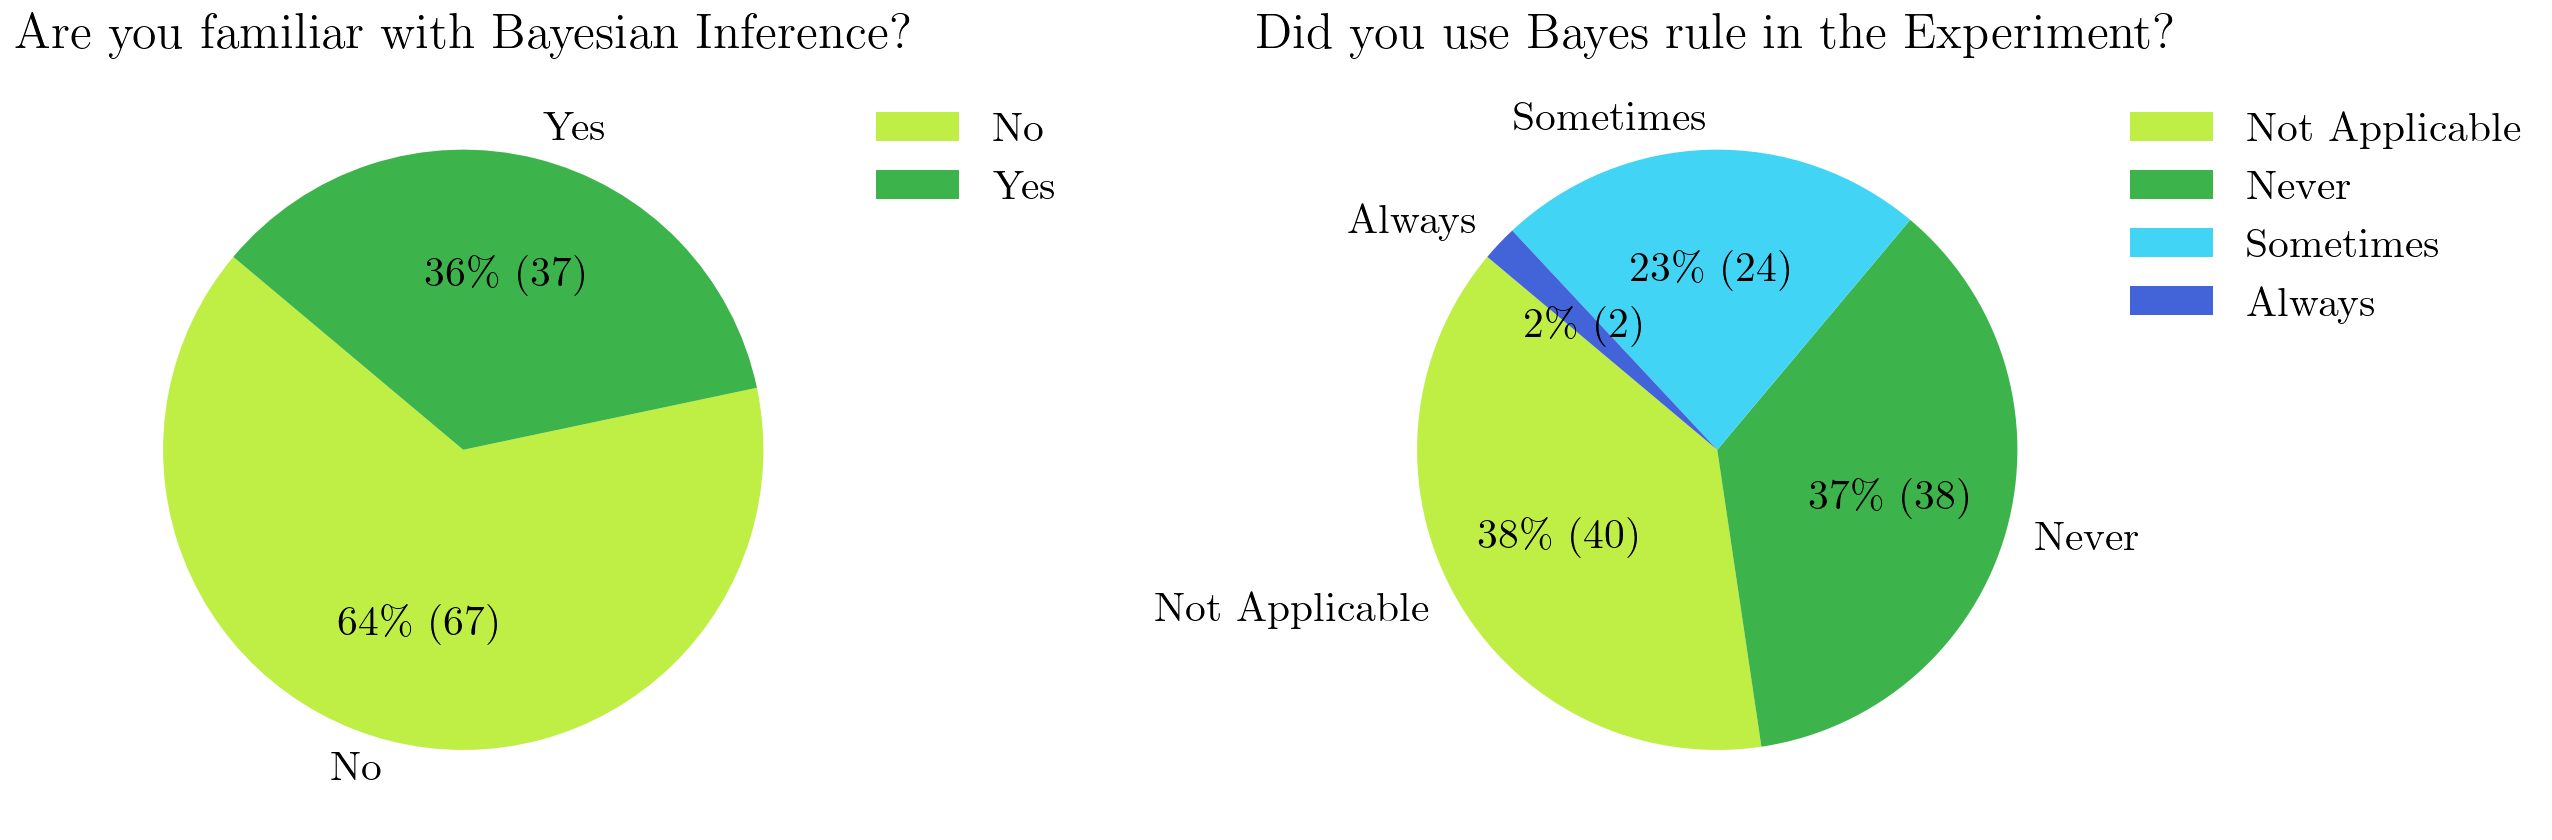

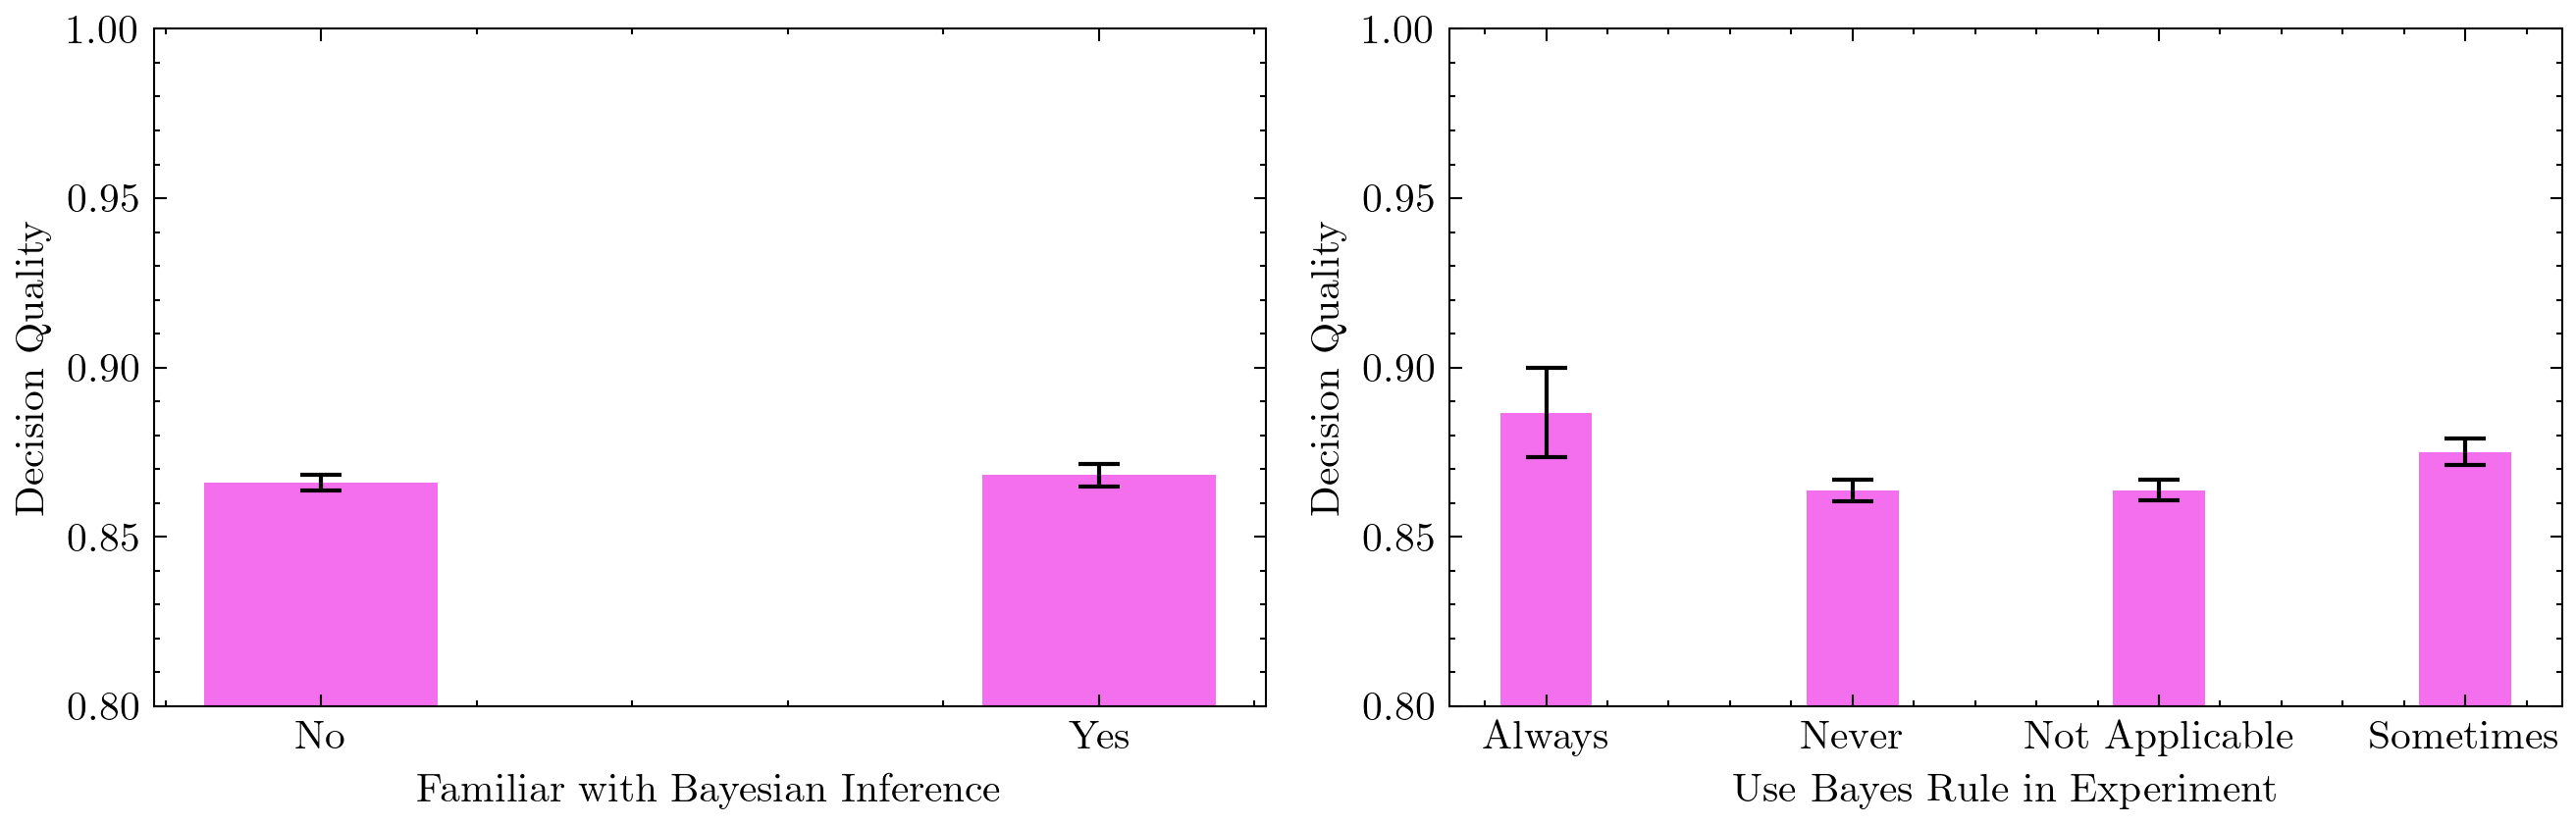

In [265]:
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=300)

    pieChart(participant_data, 'bayesFamaliar', "Are you familiar with Bayesian Inference?", out=False, ax=axes[0])
    pieChart(participant_data, 'bayesInExp', "Did you use Bayes rule in the Experiment?", out=False, ax=axes[1])

    fig.tight_layout()
    plt.savefig("images/bayes_pie.png")     
    plt.show()

with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=300)

    twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Decision Quality ', x_name='bayesFamaliar', x_label='Familiar with Bayesian Inference',ylimLow=0.8, ylimHigh = 1.0,axes=axes[0])
    twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Decision Quality ', x_name='bayesInExp', x_label='Use Bayes Rule in Experiment',ylimLow=0.8,ylimHigh =1.0, axes=axes[1])
    fig.tight_layout()
    plt.savefig("images/bayes_bar.png")     
    plt.show()

count   104.00
mean     25.80
std       5.41
min      18.00
25%      22.00
50%      24.00
75%      30.00
max      45.00
Name: age, dtype: float64

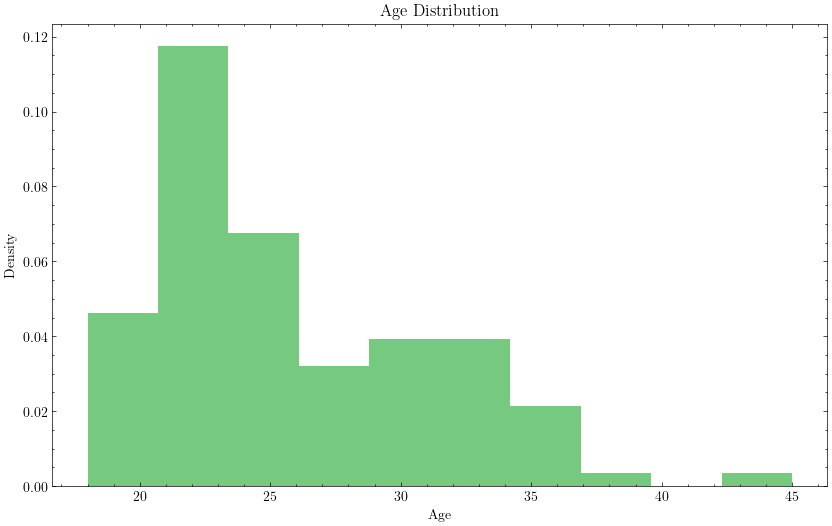

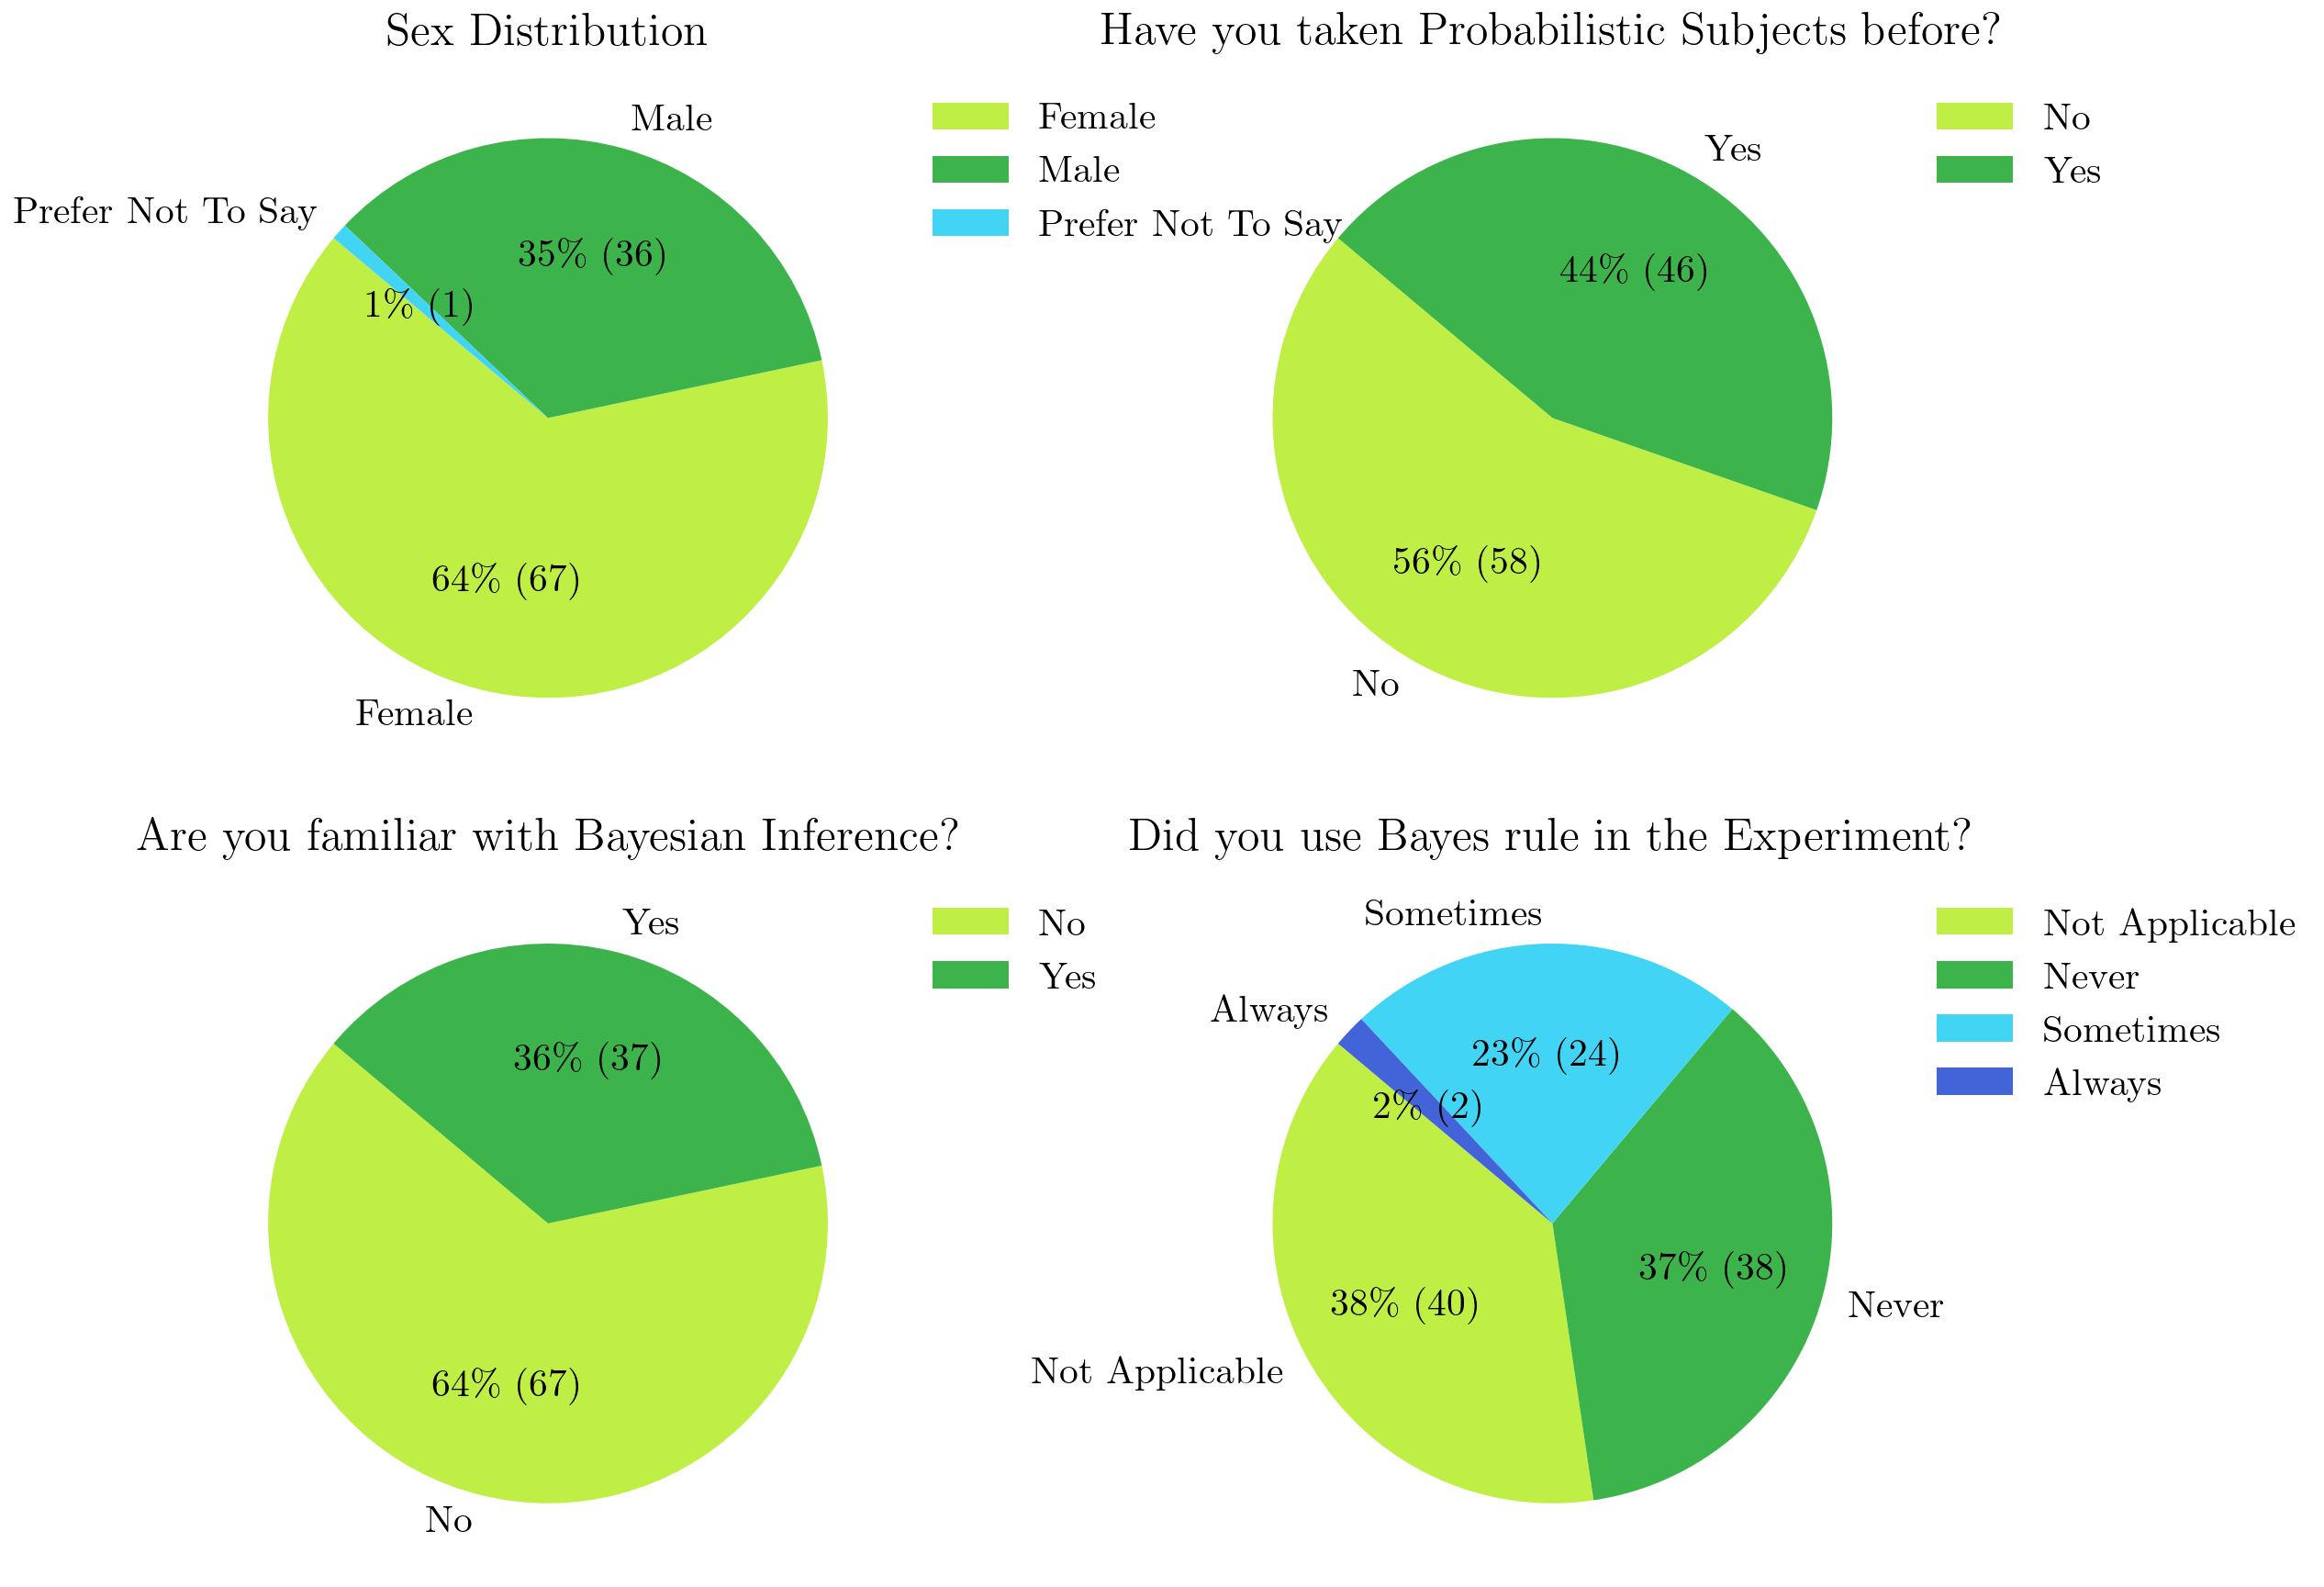

In [266]:
# 'age', 'sex', 'probSubject', 'bayesFamaliar', 'bayesInExp'

display(participant_data.groupby('participantID')['age'].mean().describe())
histogram(participant_data, 'Age Distribution', 'age', 'Age', bins=10)
with plt.style.context("science"):
    fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=300)

    pieChart(participant_data, 'sex', "Sex Distribution", out=False, ax=axes[0, 0])
    pieChart(participant_data, 'probSubject', "Have you taken Probabilistic Subjects before?", out=False, ax=axes[0, 1])
    pieChart(participant_data, 'bayesFamaliar', "Are you familiar with Bayesian Inference?", out=False, ax=axes[1, 0])
    pieChart(participant_data, 'bayesInExp', "Did you use Bayes rule in the Experiment?", out=False, ax=axes[1, 1])
    
    fig.tight_layout()
    plt.savefig("images/demographic_pie.png")     
    plt.show()


### Average Payment Calculation

In [258]:
payment_df_1 = pd.read_csv('Payment/payment_Andy_1to20.csv')
payment_df_2 = pd.read_csv('Payment/payment_Andy_21to42.csv')
payment_df_3 = pd.read_csv('Payment/payment_Andy_43to64.csv')
payment_df_4 = pd.read_csv('Payment/payment_Andy_65to88.csv')
payment_df_5 = pd.read_csv('Payment/payment_Andy_89to103.csv')
payment_df_6 = pd.read_csv('Payment/payment_Andy_104to105.csv')
payment_df_7 = pd.read_csv('Payment/payment_Andy_106to118.csv')
payment_df = pd.concat([payment_df_1, payment_df_2, payment_df_3, payment_df_4, payment_df_5, payment_df_6, payment_df_7], ignore_index=True)
payment_df.describe()

payment
count   105.00
mean     29.97
std       9.19
min      10.00
25%      23.00
50%      30.00
75%      36.00
max      50.00

## Disaggregate according to Each Ball Draw in Each Instance (Average the Performance of each individual)

In [259]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c', 'DV_seqBall_1', 'DV_seqBall_2',
       'DV_seqBall_3', 'DV_bayesInExp'],
      dtype='object')

In [260]:
urnColumns = ['instanceName','seqBall','DQ_U_o', 'urns', 'colours', 'responseTimeUrn','CC_u','DQ_U_o','DQ_U_s','EWCC_u','MDCC_u','ACC_u','AEWCC_u','AMDCC_u'] 

ins_seq_grouped_mean_urn = participant_data[urnColumns].groupby(['instanceName','seqBall']).mean()
ins_seq_grouped_mean_urn

DQ_U_o  urns  colours  responseTimeUrn  CC_u  DQ_U_o  \
instanceName seqBall                                                         
1            1          0.97  2.00     2.00            21.14  5.00    0.97   
             2          0.92  2.00     2.00            27.72 10.00    0.92   
             3          0.93  2.00     2.00            20.66 10.00    0.93   
3            1          0.95  2.00     3.00            36.91  5.00    0.95   
             2          0.83  2.00     3.00            54.36 10.00    0.83   
             3          0.78  2.00     3.00            30.98 10.00    0.78   
5            1          0.97  2.00     4.00            31.13  5.00    0.97   
             2          0.84  2.00     4.00            31.63 10.00    0.84   
             3          0.78  2.00     4.00            20.21 10.00    0.78   
7            1          0.94  3.00     2.00            83.88 10.00    0.94   
             2          0.91  3.00     2.00            59.27 18.00    0.91   
             3          0.86  3.00     2.00            52.76 18.00    0.86   
9            1          0.96  3.00     3.00            32.61 10.00    0.96   
             2          0.79  3.00     3.00            32.52 18.00    0.79   
             3          0.66  3.00     3.00            36.82 18.00    0.66   
11           1          0.95  3.00     4.00            82.01 10.00    0.95   
             2          0.88  3.00     4.00            48.09 18.00    0.88   
             3          0.81  3.00     4.00            35.91 18.00    0.81   
12           1          0.94  3.00     4.00            63.82 10.00    0.94   
             2          0.87  3.00     4.00            44.14 18.00    0.87   
             3          0.81  3.00     4.00            45.71 18.00    0.81   
13           1          0.95  4.00     2.00            81.22 15.00    0.95   
             2          0.87  4.00     2.00            56.74 26.00    0.87   
             3          0.89  4.00     2.00            55.72 26.00    0.89   
15           1          0.92  4.00     3.00           116.77 15.00    0.92   
             2          0.79  4.00     3.00            94.22 26.00    0.79   
             3          0.78  4.00     3.00            61.52 26.00    0.78   
16           1          0.92  4.00     3.00           145.62 15.00    0.92   
             2          0.79  4.00     3.00            81.22 26.00    0.79   
             3          0.73  4.00     3.00            65.51 26.00    0.73   
17           1          0.97  4.00     4.00            48.09 15.00    0.97   
             2          0.85  4.00     4.00            69.15 26.00    0.85   
             3          0.81  4.00     4.00            73.92 26.00    0.81   
18           1          0.96  4.00     4.00            47.53 15.00    0.96   
             2          0.84  4.00     4.00            43.87 26.00    0.84   
             3          0.78  4.00     4.00            40.68 26.00    0.78   

                      DQ_U_s  EWCC_u  MDCC_u  ACC_u  AEWCC_u  AMDCC_u  
instanceName seqBall                                                   
1            1          0.97    3.00    2.00   5.00     3.00     2.00  
             2          0.91    6.00    4.00  15.00     9.00     6.00  
             3          0.88    6.00    4.00  25.00    15.00    10.00  
3            1          0.95    3.00    2.00   5.00     3.00     2.00  
             2          0.85    6.00    4.00  15.00     9.00     6.00  
             3          0.87    6.00    4.00  25.00    15.00    10.00  
5            1          0.97    3.00    2.00   5.00     3.00     2.00  
             2          0.85    6.00    4.00  15.00     9.00     6.00  
             3          0.84    6.00    4.00  25.00    15.00    10.00  
7            1          0.94    6.00    4.00  10.00     6.00     4.00  
             2          0.90   11.00    7.00  28.00    17.00    11.00  
             3          0.85   11.00    7.00  46.00    28.00    18.00  
9            1          0.96    6.00    4.00  10.

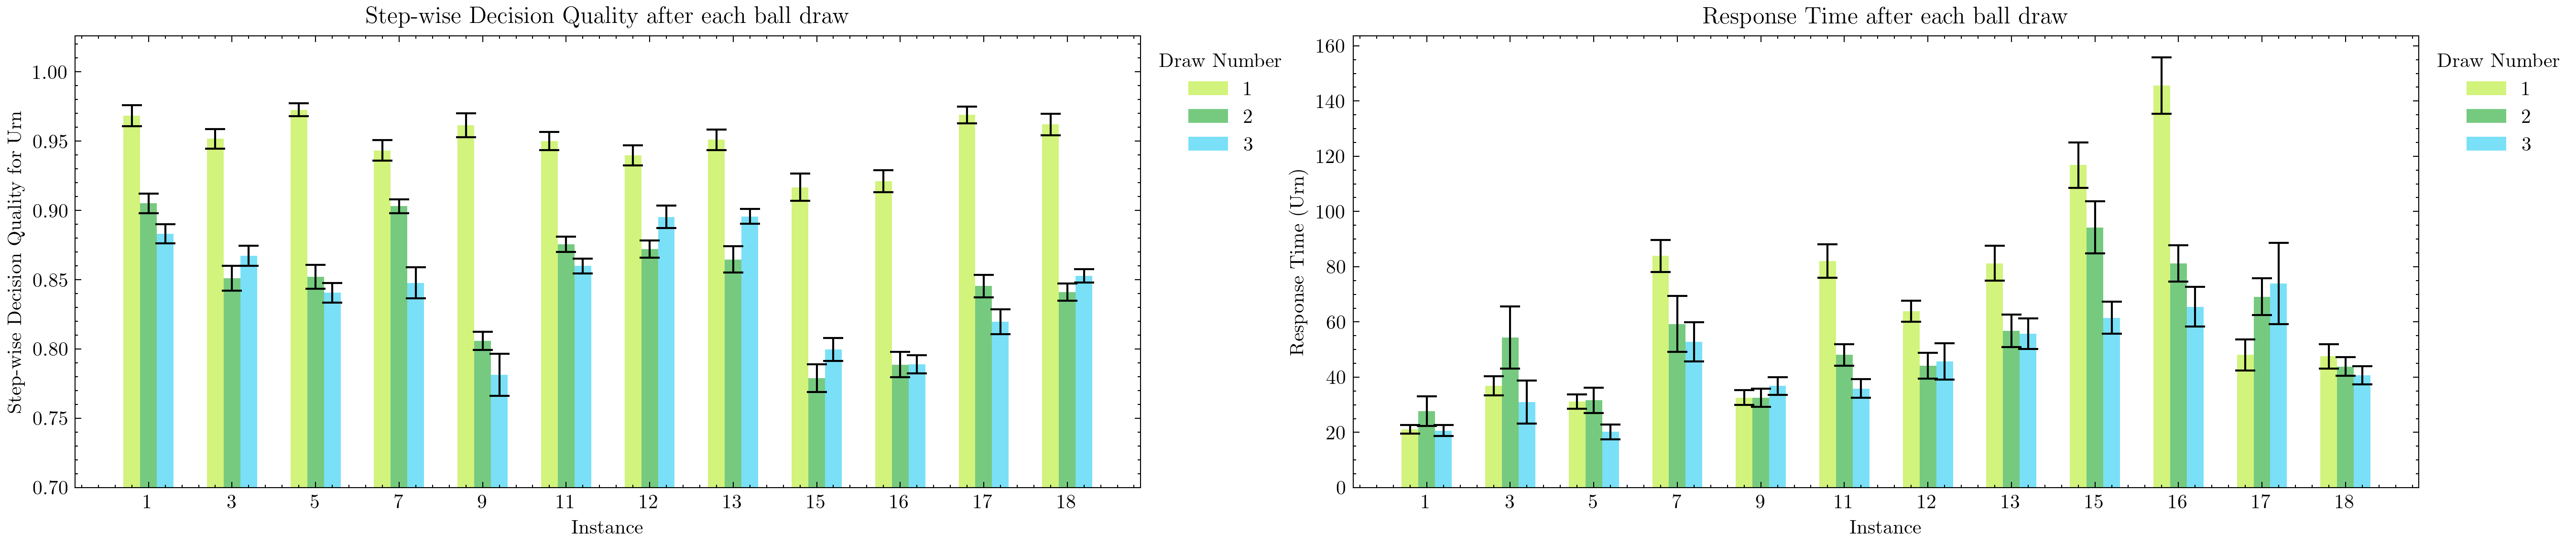

In [267]:
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(18, 4), dpi=300)
    threeAttributes_bar(df=participant_data, lengend_var='seqBall', legend_title= "Draw Number", y_name='DQ_U_s', y_label='Step-wise Decision Quality for Urn', x_name='instanceName', x_label='Instance', title="Step-wise Decision Quality after each ball draw" , ylimLow=0.7,out=False, ax=axes[0])
    threeAttributes_bar(df=participant_data, lengend_var='seqBall', legend_title= "Draw Number", y_name='responseTimeUrn', y_label='Response Time (Urn)', x_name='instanceName', x_label='Instance', title="Response Time after each ball draw", out=False, ax=axes[1])
    fig.tight_layout()
    plt.savefig("images/ballseq_DQ_RT.png")
    plt.show()

## Disaggregate According to Complexity

### Demographic Bar Graph

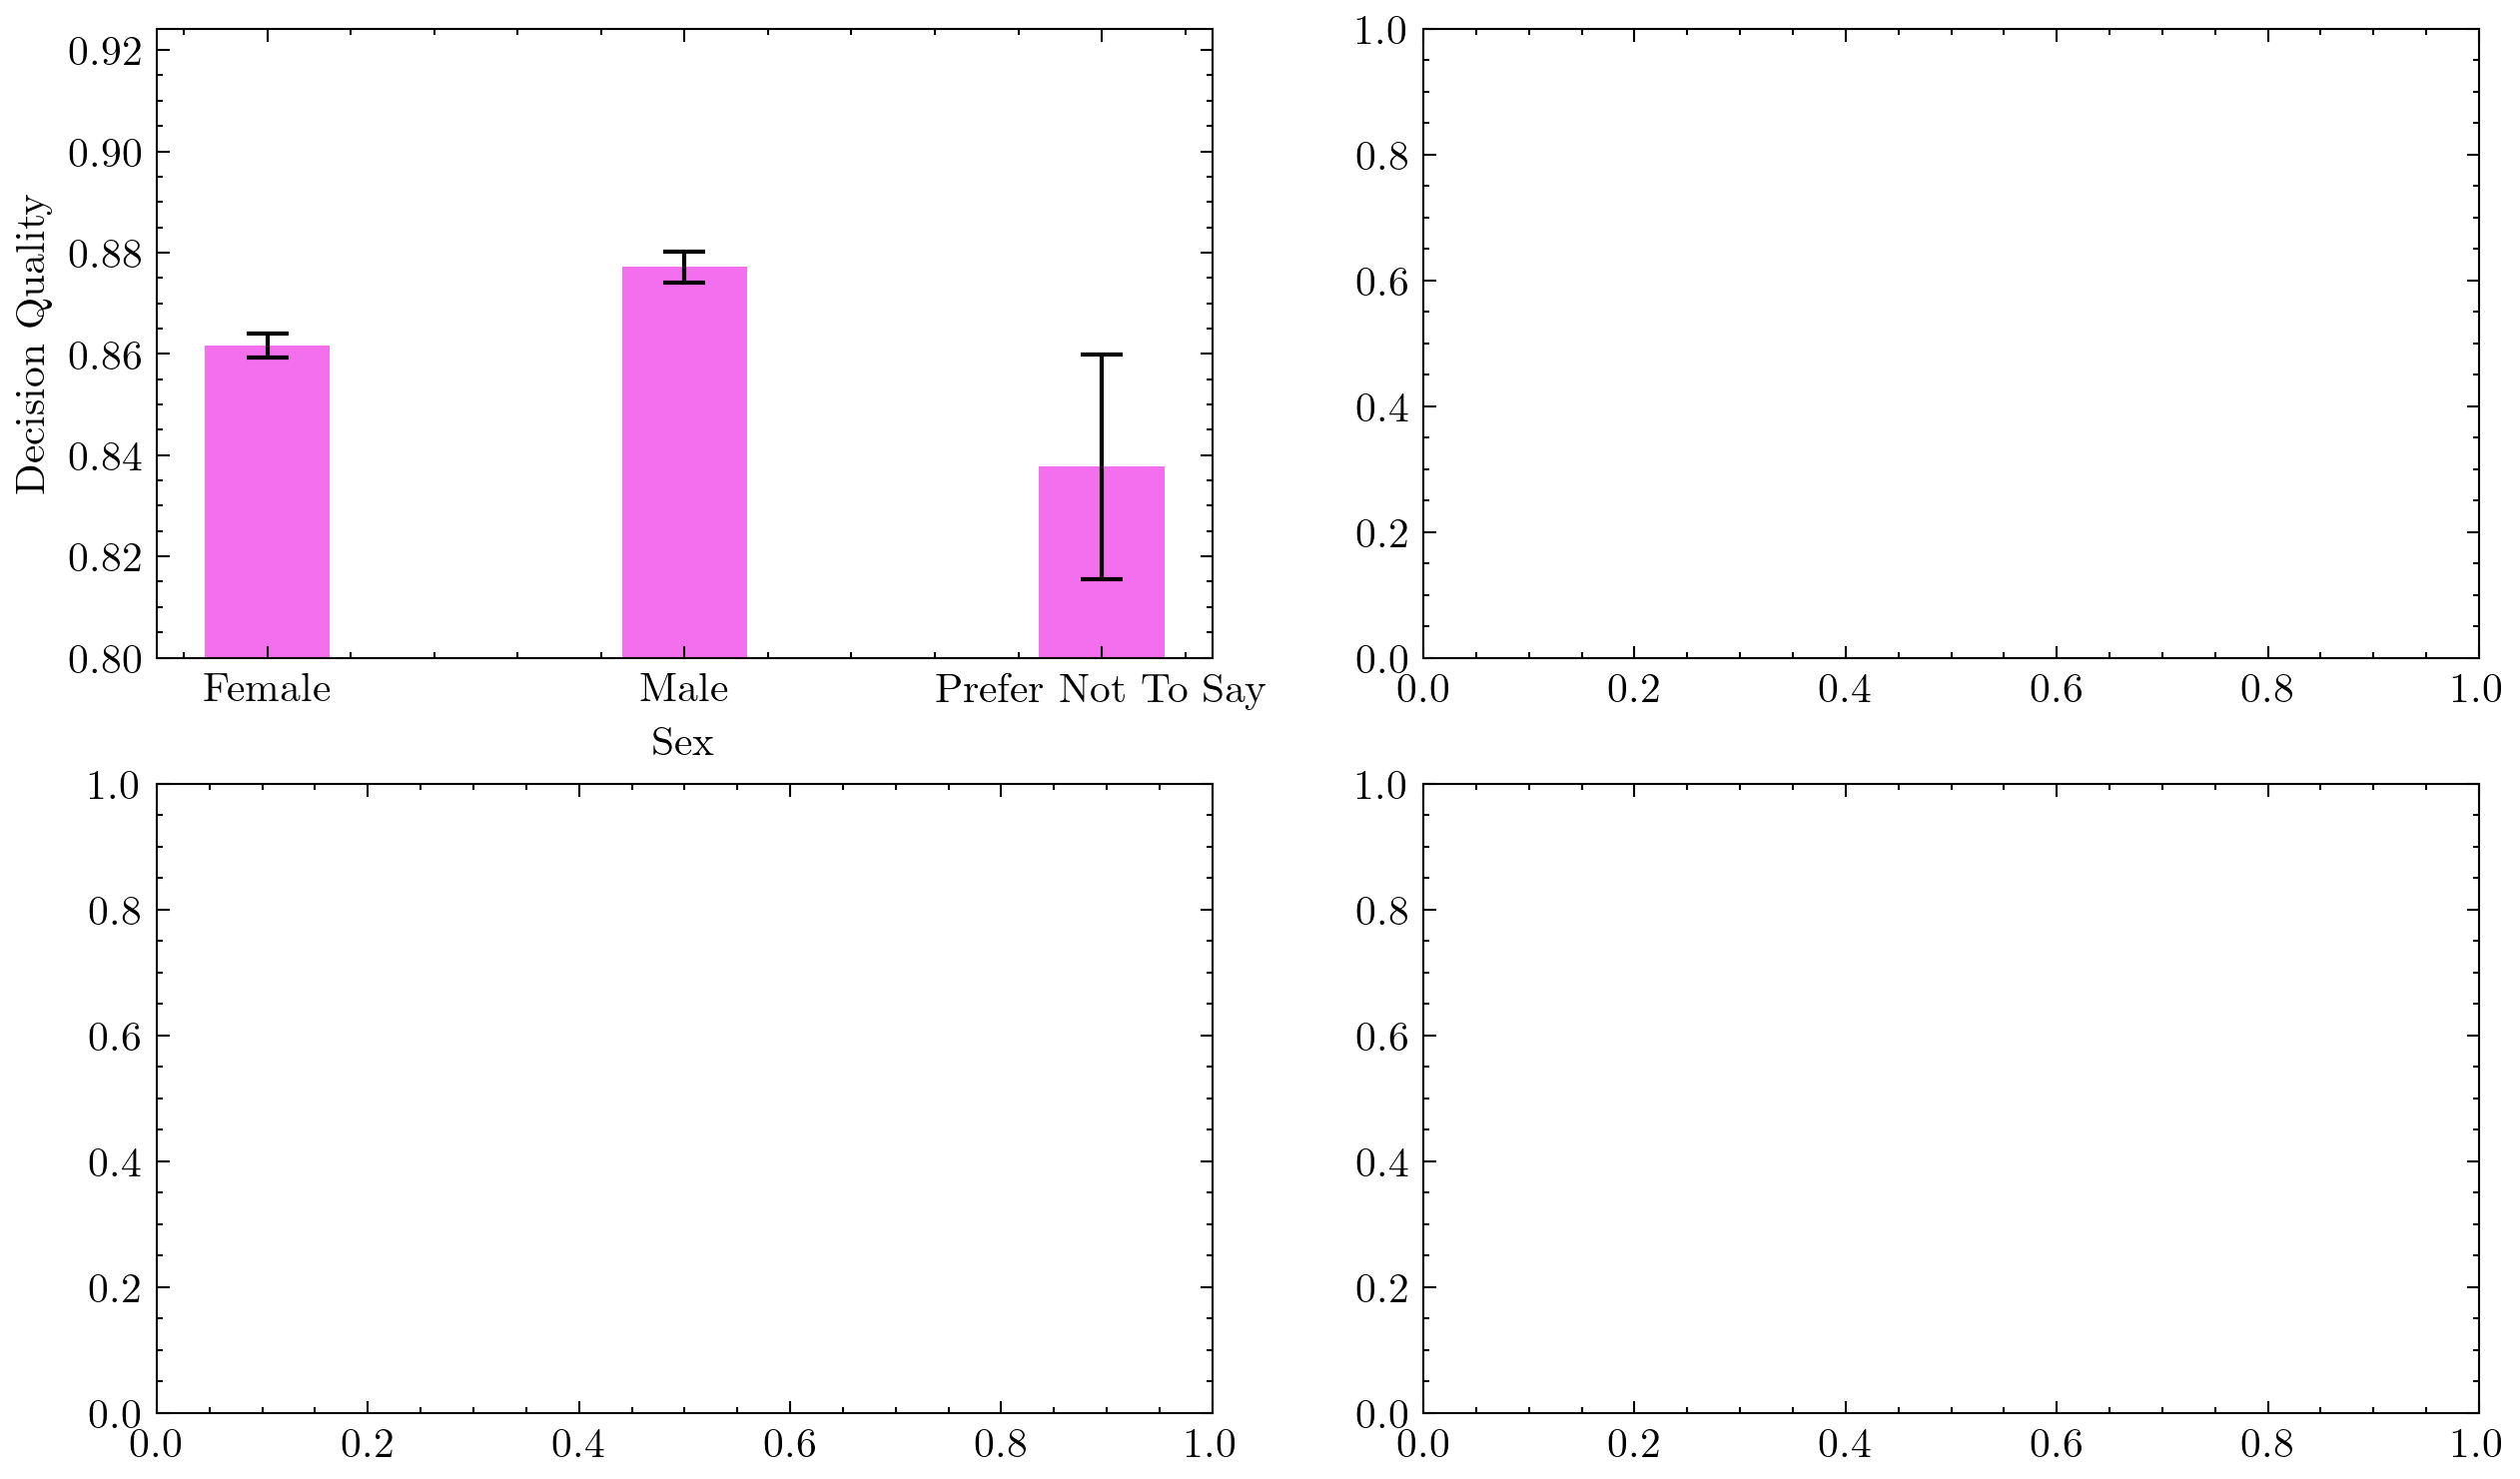

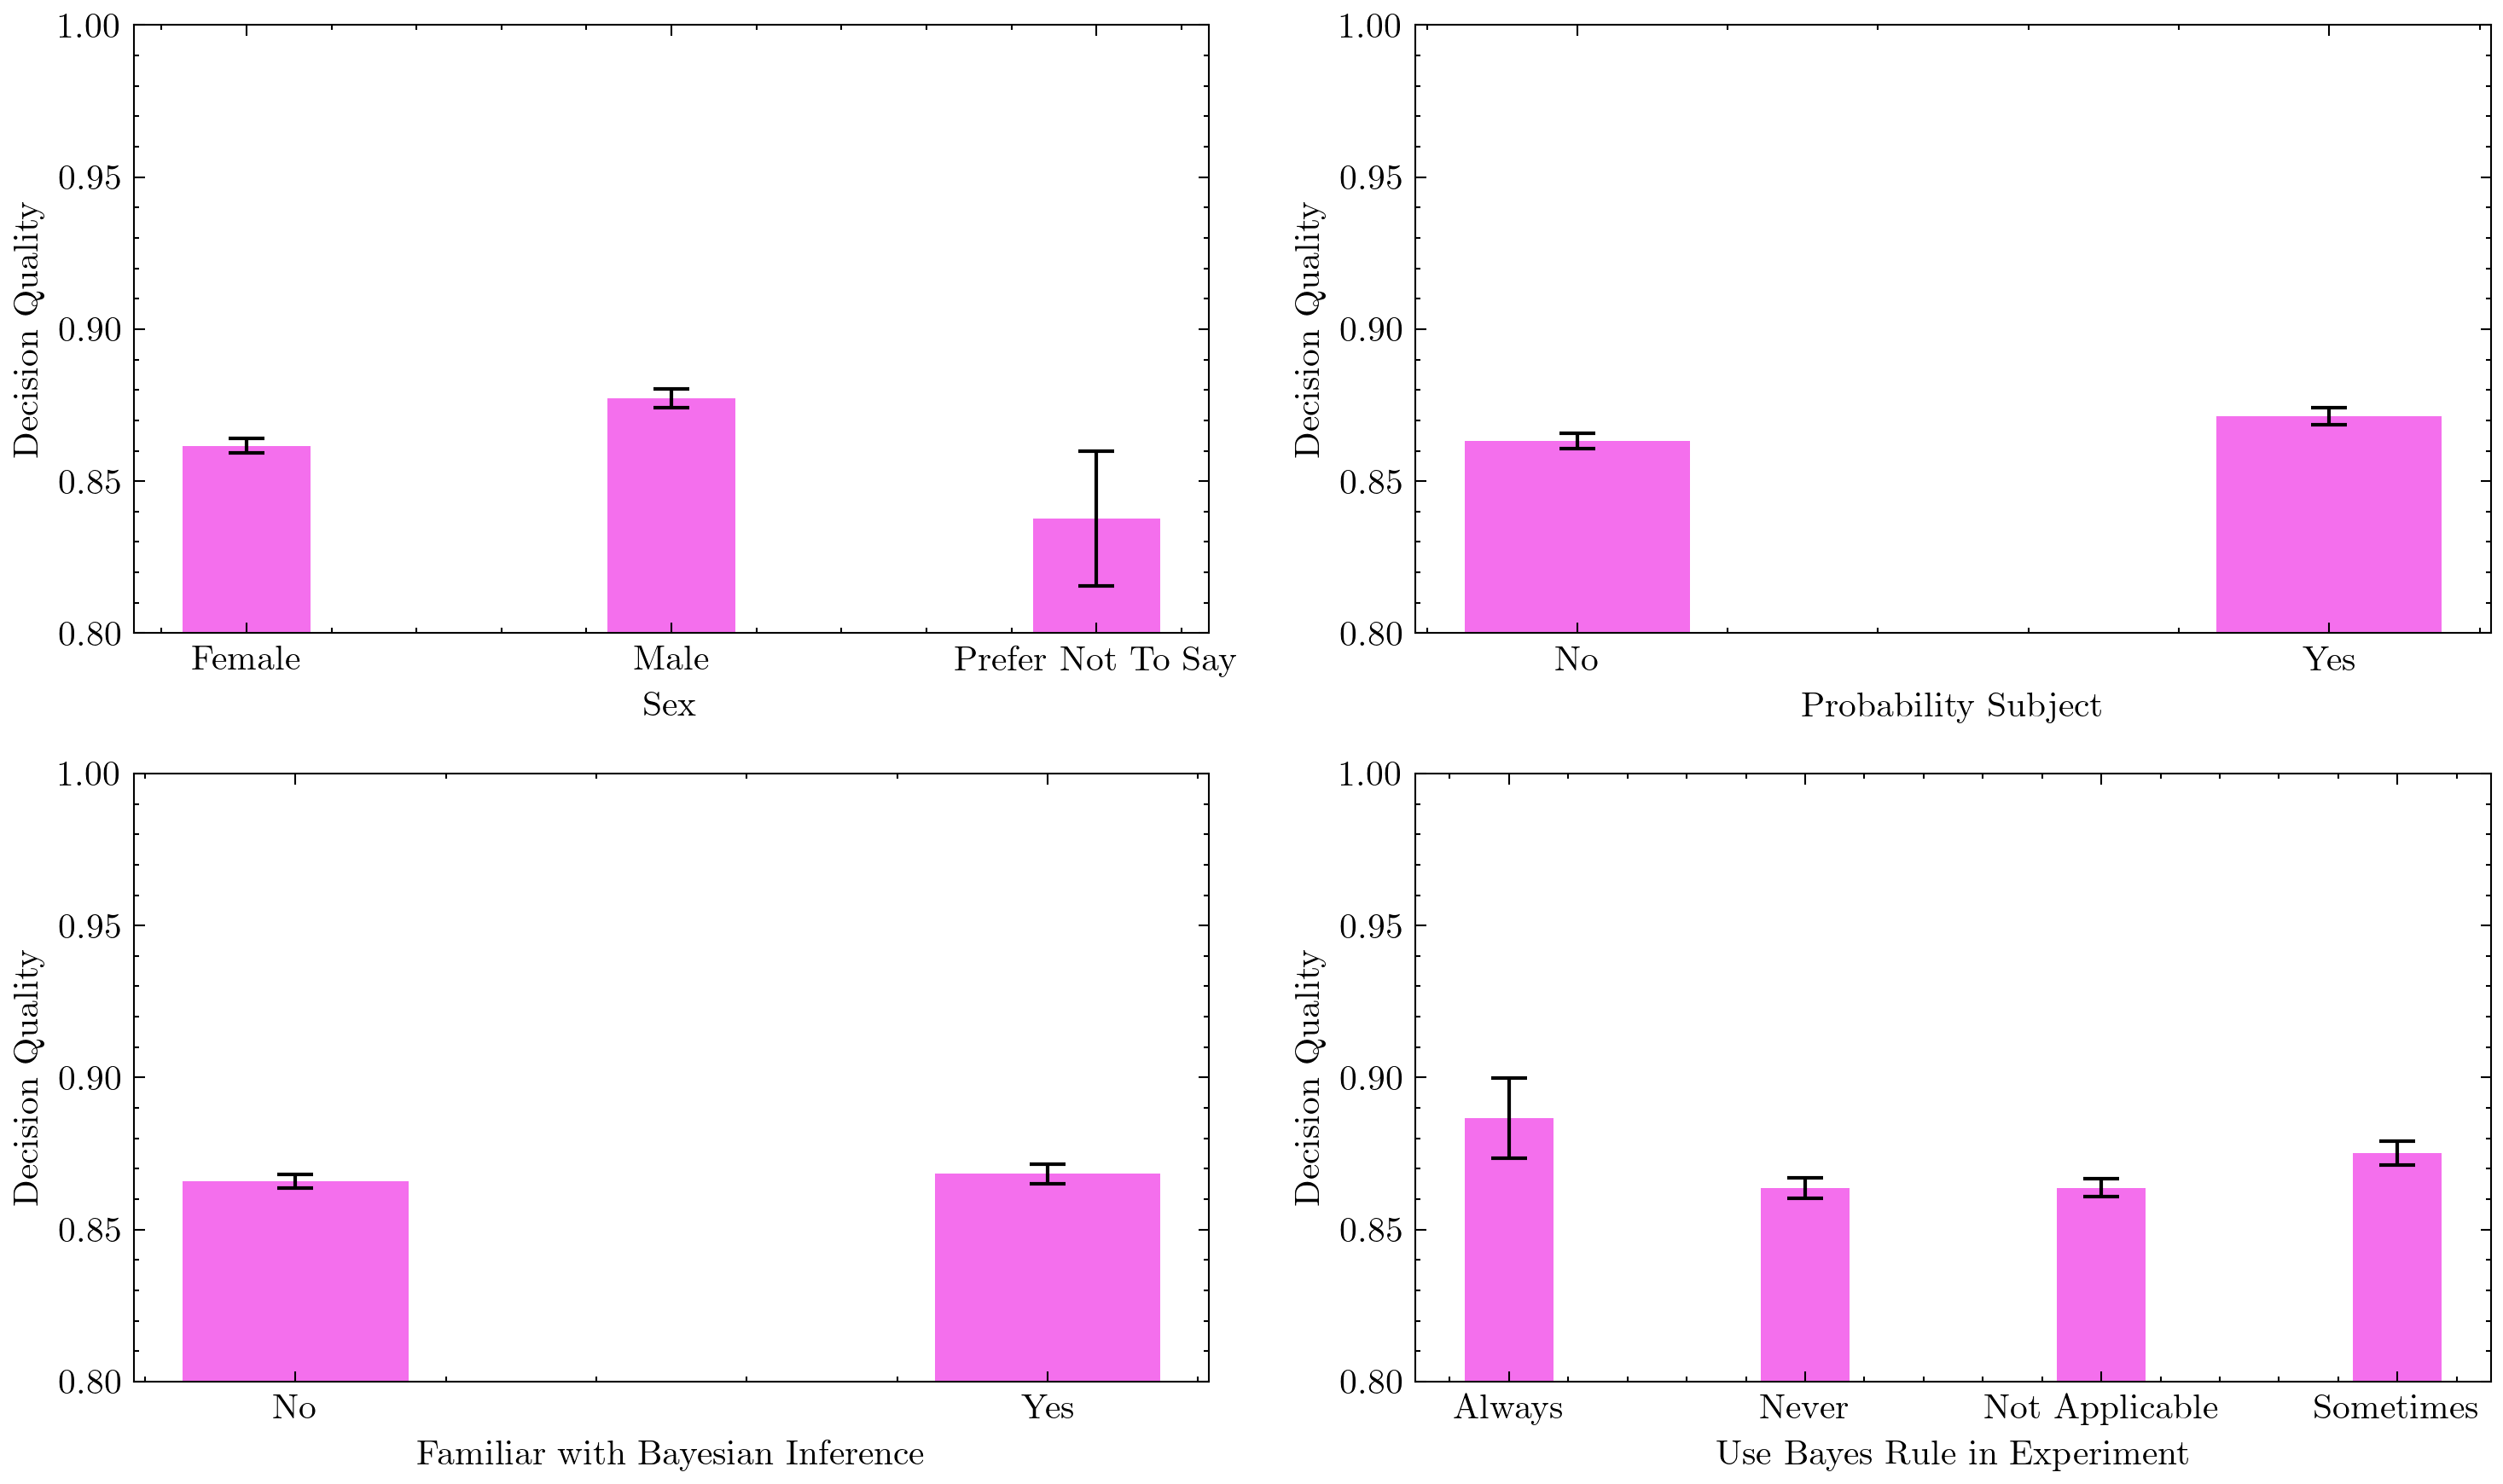

In [269]:
with plt.style.context("science"):
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), dpi=300)
    twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Decision Quality ', x_name='sex', x_label='Sex',ylimLow=0.8,ylimHigh=1,axes=axes[0, 0])
    twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Decision Quality ', x_name='probSubject', x_label='Probability Subject',ylimLow=0.8,ylimHigh=1,axes=axes[0, 1])
    twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Decision Quality ', x_name='bayesFamaliar', x_label='Familiar with Bayesian Inference',ylimLow=0.8,ylimHigh=1,axes=axes[1, 0])
    twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Decision Quality ', x_name='bayesInExp', x_label='Use Bayes Rule in Experiment',ylimLow=0.8,ylimHigh=1,axes=axes[1, 1])
    fig.tight_layout()
    plt.savefig("images/DQ_Demo_Bar.png")
    plt.show()

### Computational Complexity of each Instance

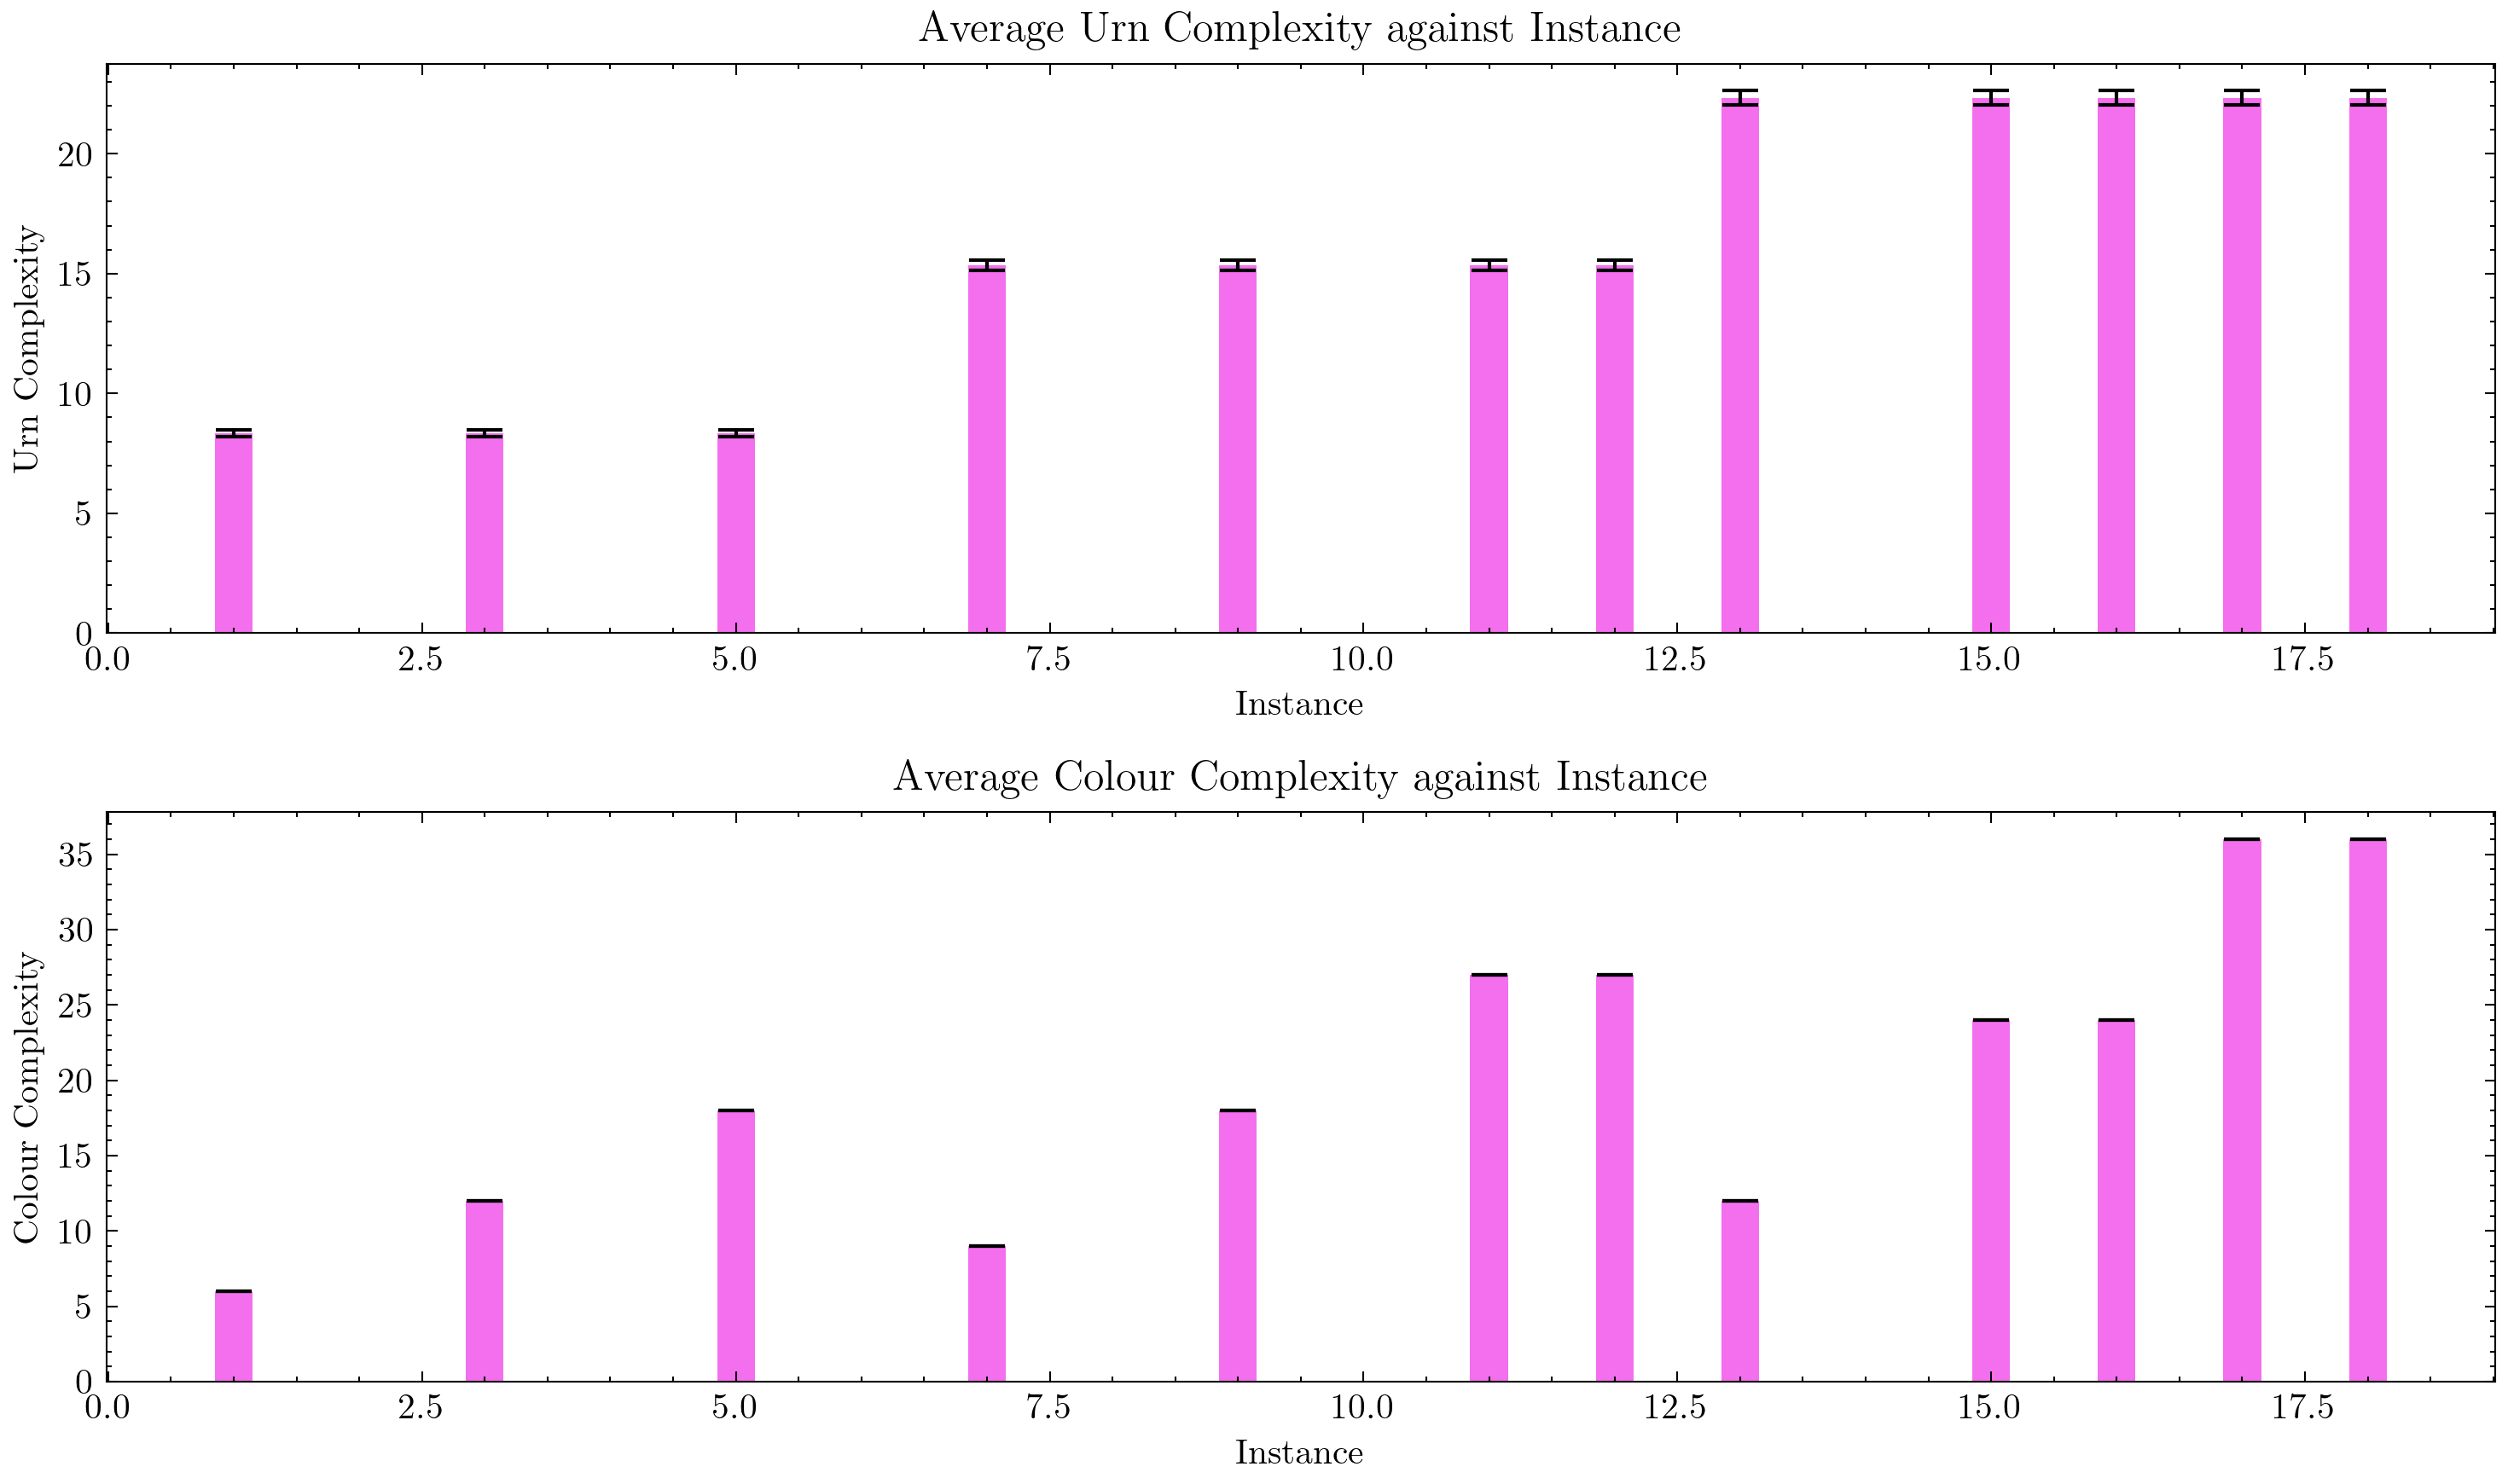

In [ ]:
with plt.style.context("science"):
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), dpi=300)
    twoAttributes_bar(participant_data, y_name='CC_u', y_label='Urn Complexity ', x_name='instanceName', x_label='Instance', out=False, axes=axes[0])
    twoAttributes_bar(participant_data, y_name='CC_c', y_label='Colour Complexity ', x_name='instanceName', x_label='Instance', out=False,axes=axes[1])
    fig.tight_layout()
    plt.savefig("images/complexity_bar.png")
    plt.show()


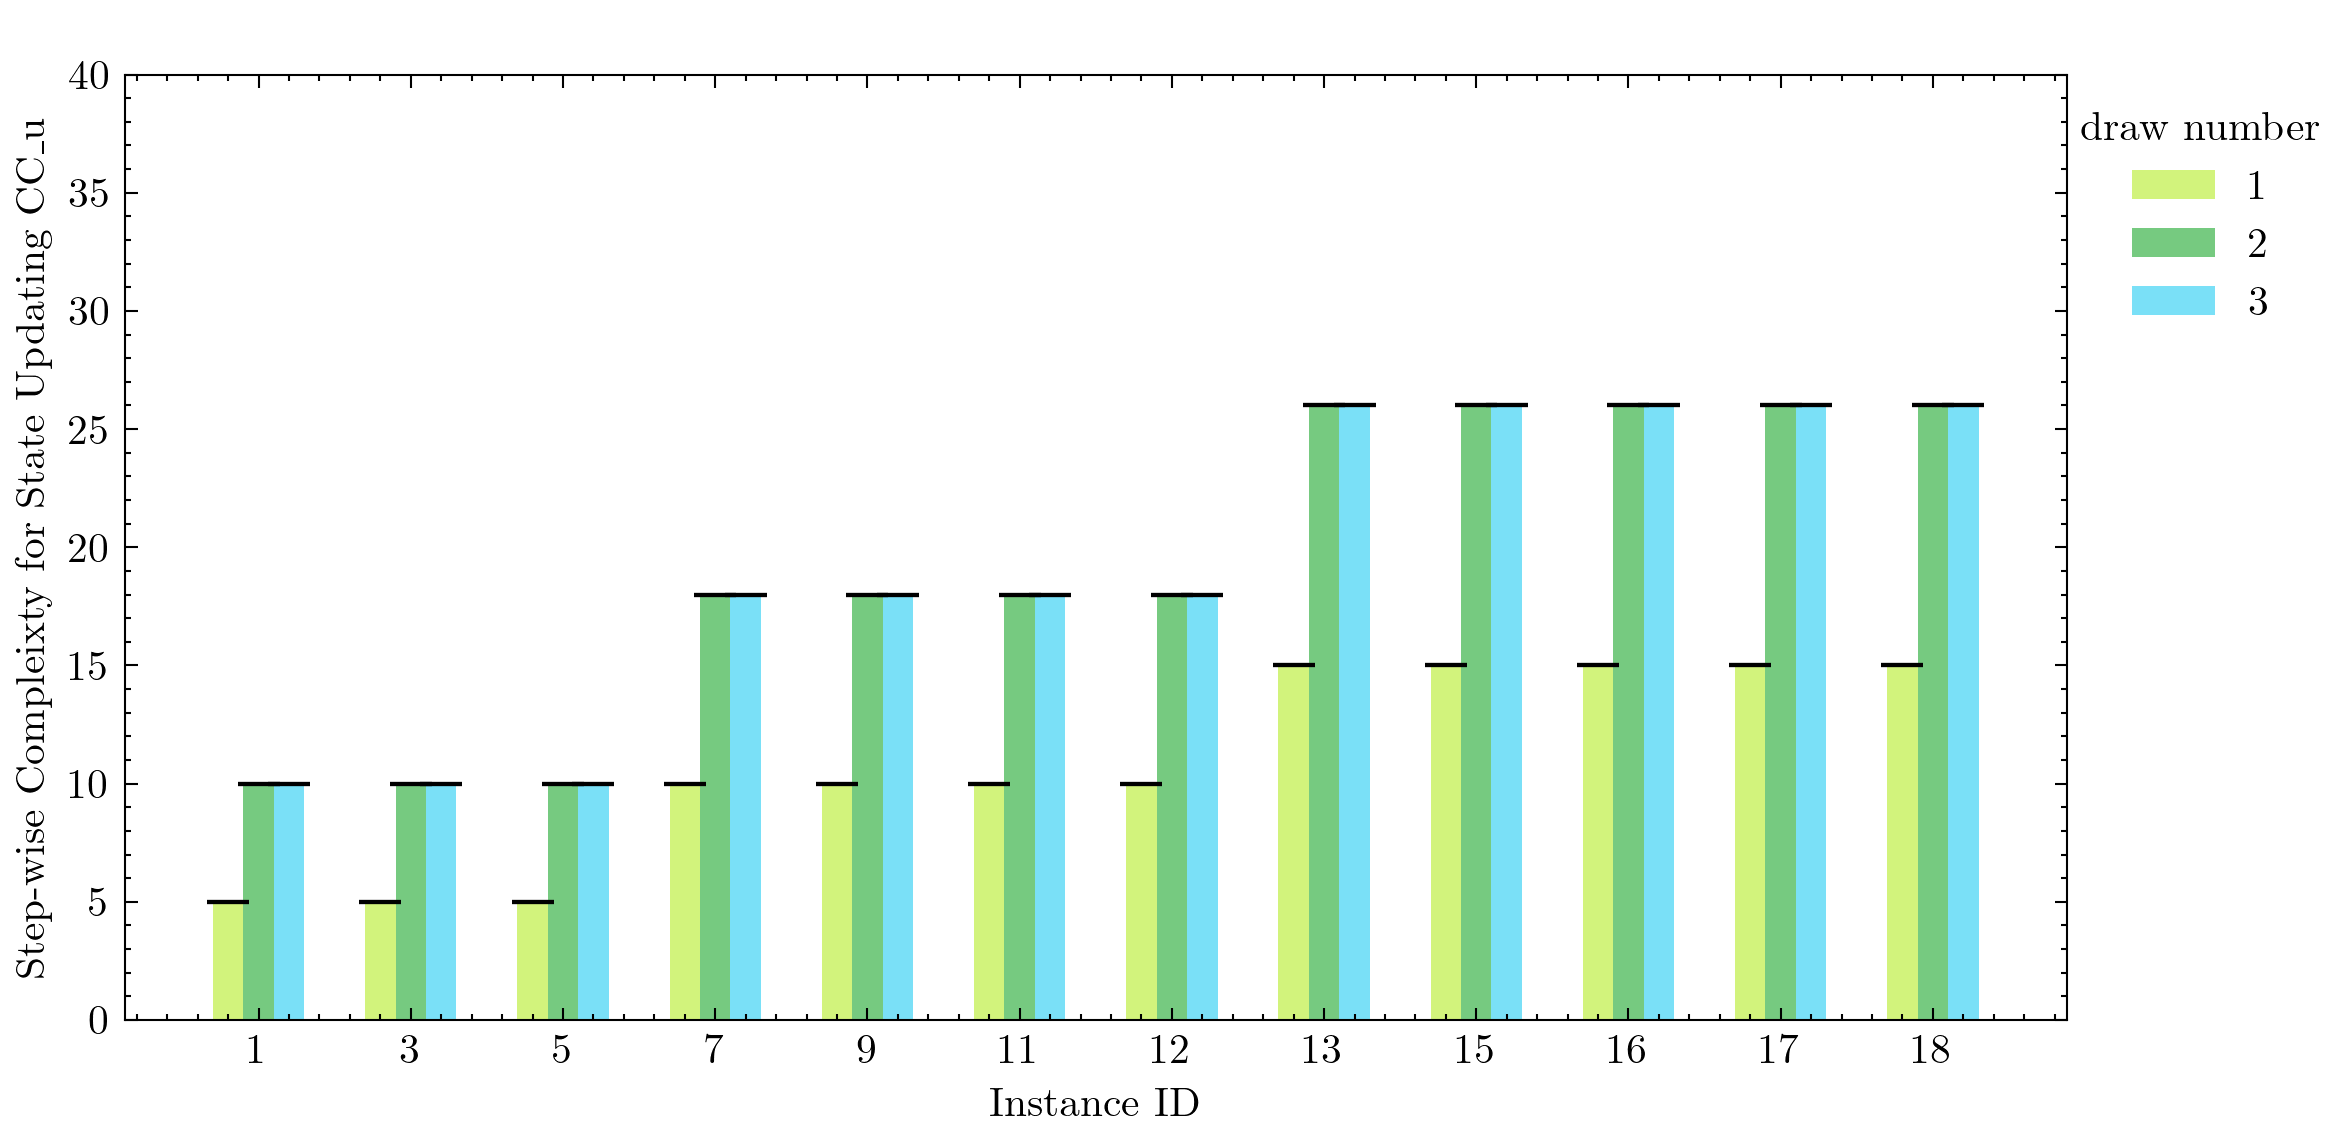

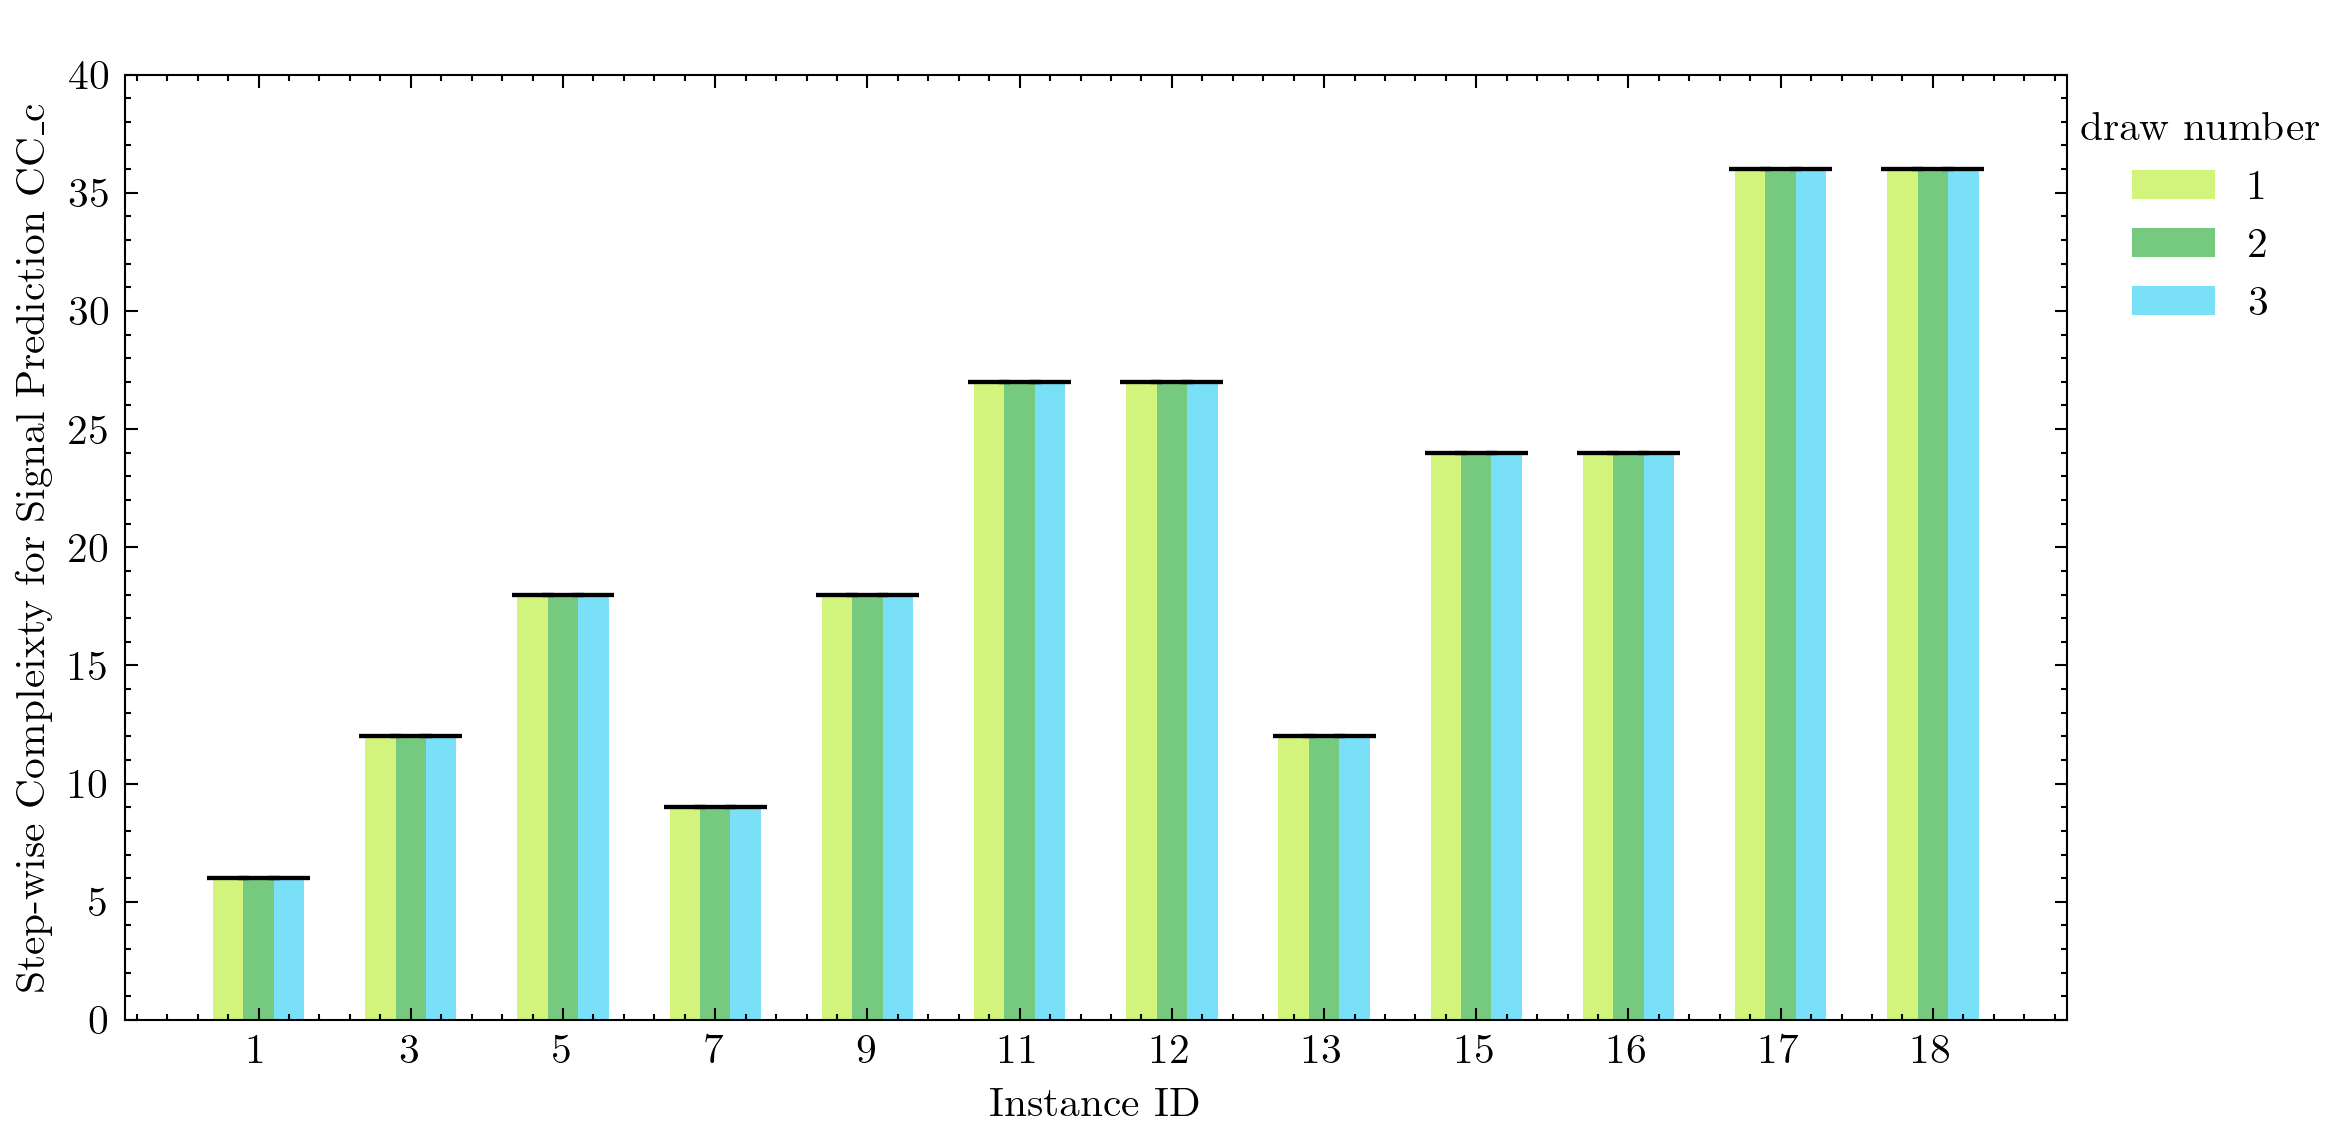

In [ ]:
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
    threeAttributes_bar(participant_data, lengend_var='seqBall', legend_title='draw number', y_name='CC_u', y_label='Step-wise Compleixty for State Updating CC_u', x_name='instanceName', x_label='Instance ID', out=False, ax=axes, ylimLow=0.0, ylimHigh=40, title=" ")
    fig.tight_layout()
    plt.savefig("images/complexity_seqBall_urn.png")
    plt.show()

with plt.style.context("science"):
    fig, axes = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
    threeAttributes_bar(participant_data, lengend_var='seqBall', legend_title='draw number', y_name='CC_c', y_label='Step-wise Compleixty for Signal Prediction CC_c', x_name='instanceName', x_label='Instance ID', out=False, ax=axes, ylimLow=0.0, ylimHigh=40, title=" ")
    fig.tight_layout()
    plt.savefig("images/complexity_seqBall_col.png")
    plt.show()

### Decision Quality Vs Complexity

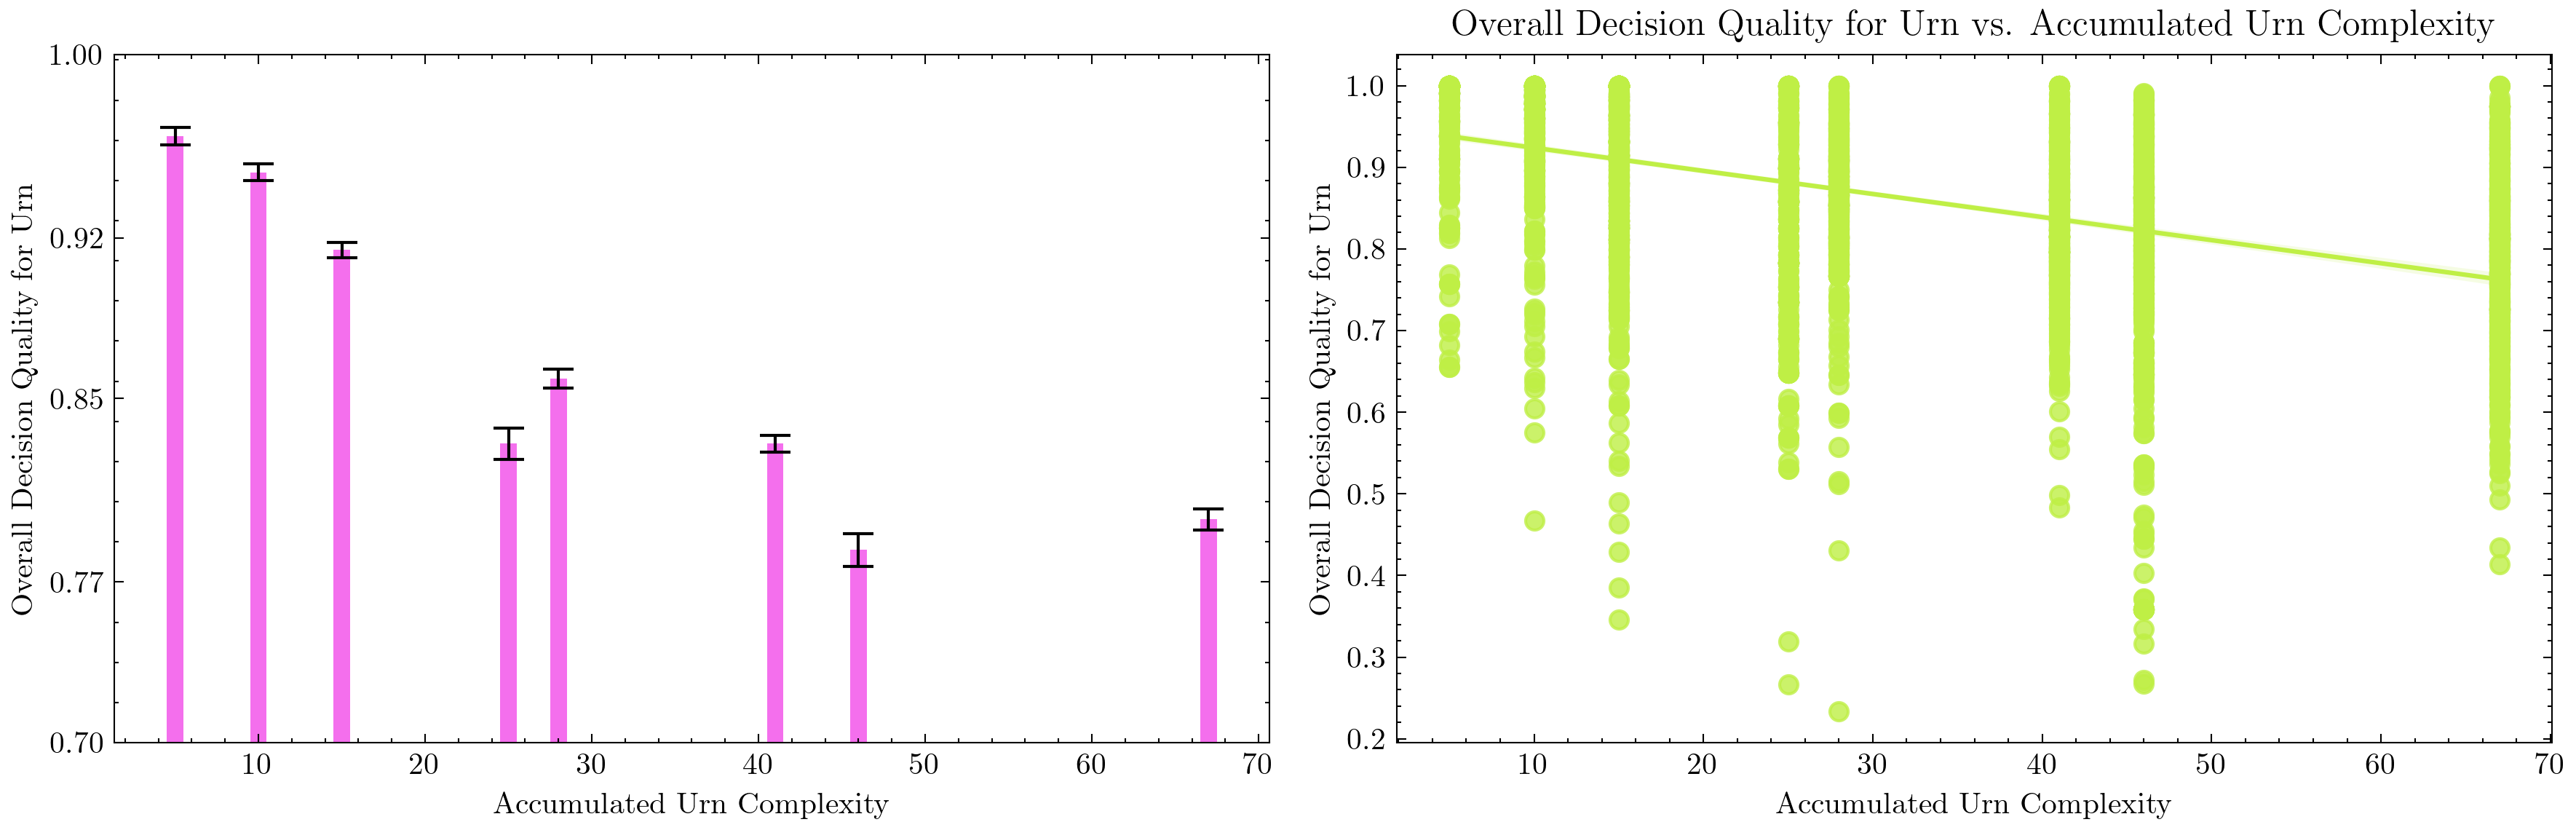

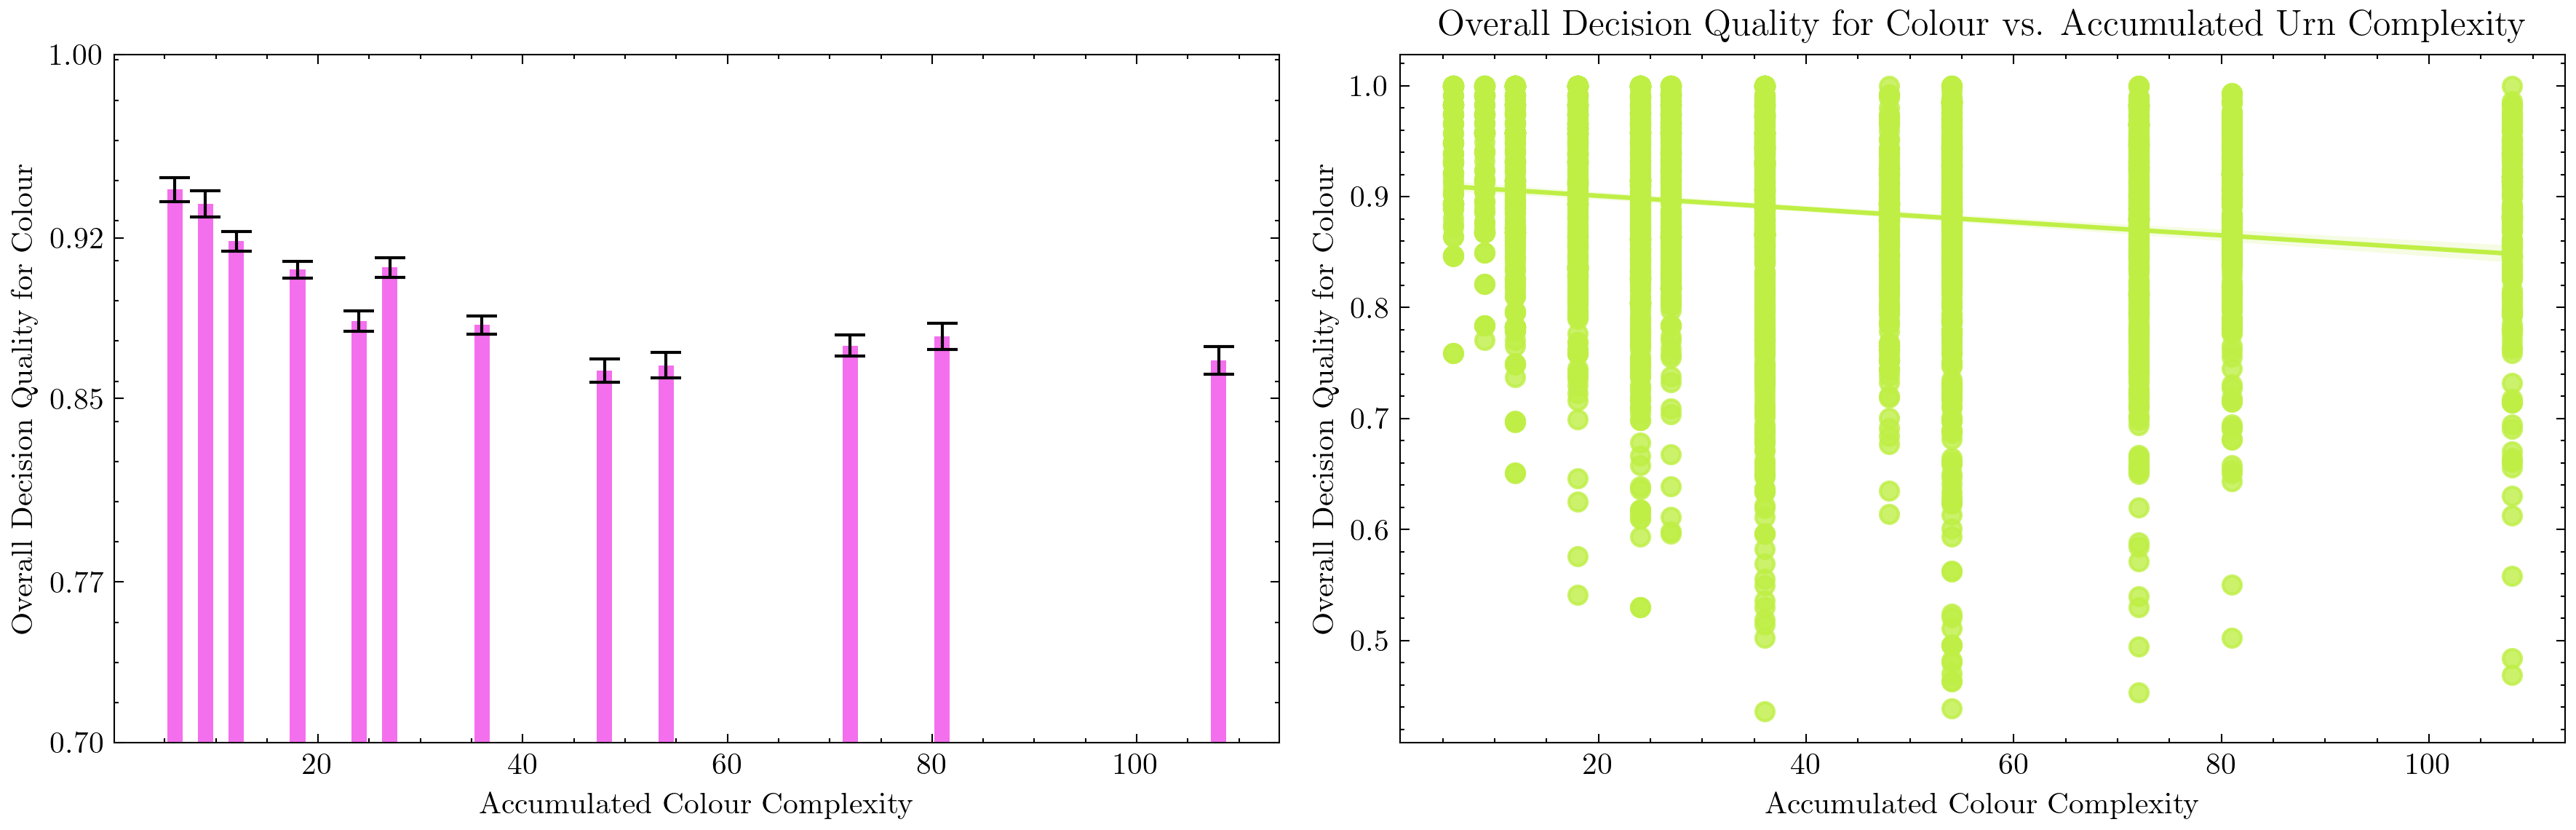

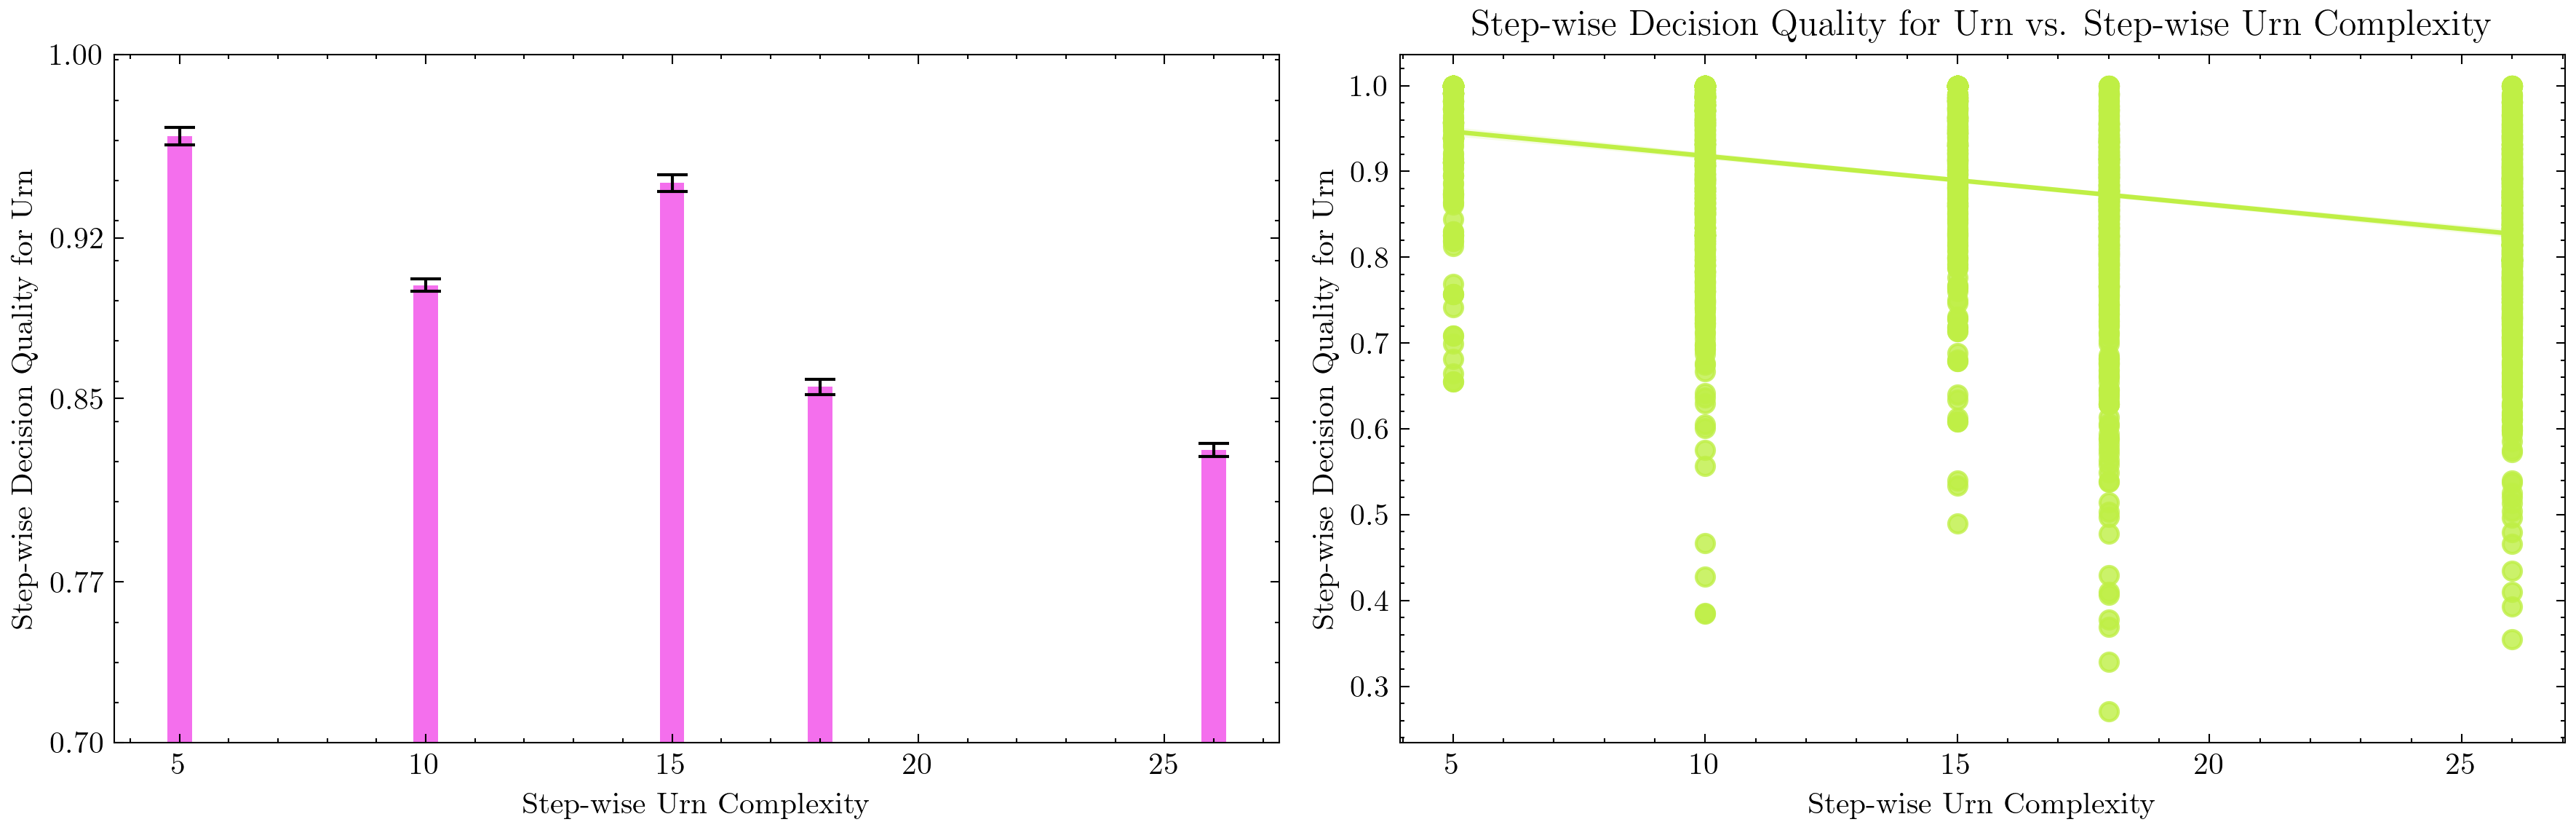

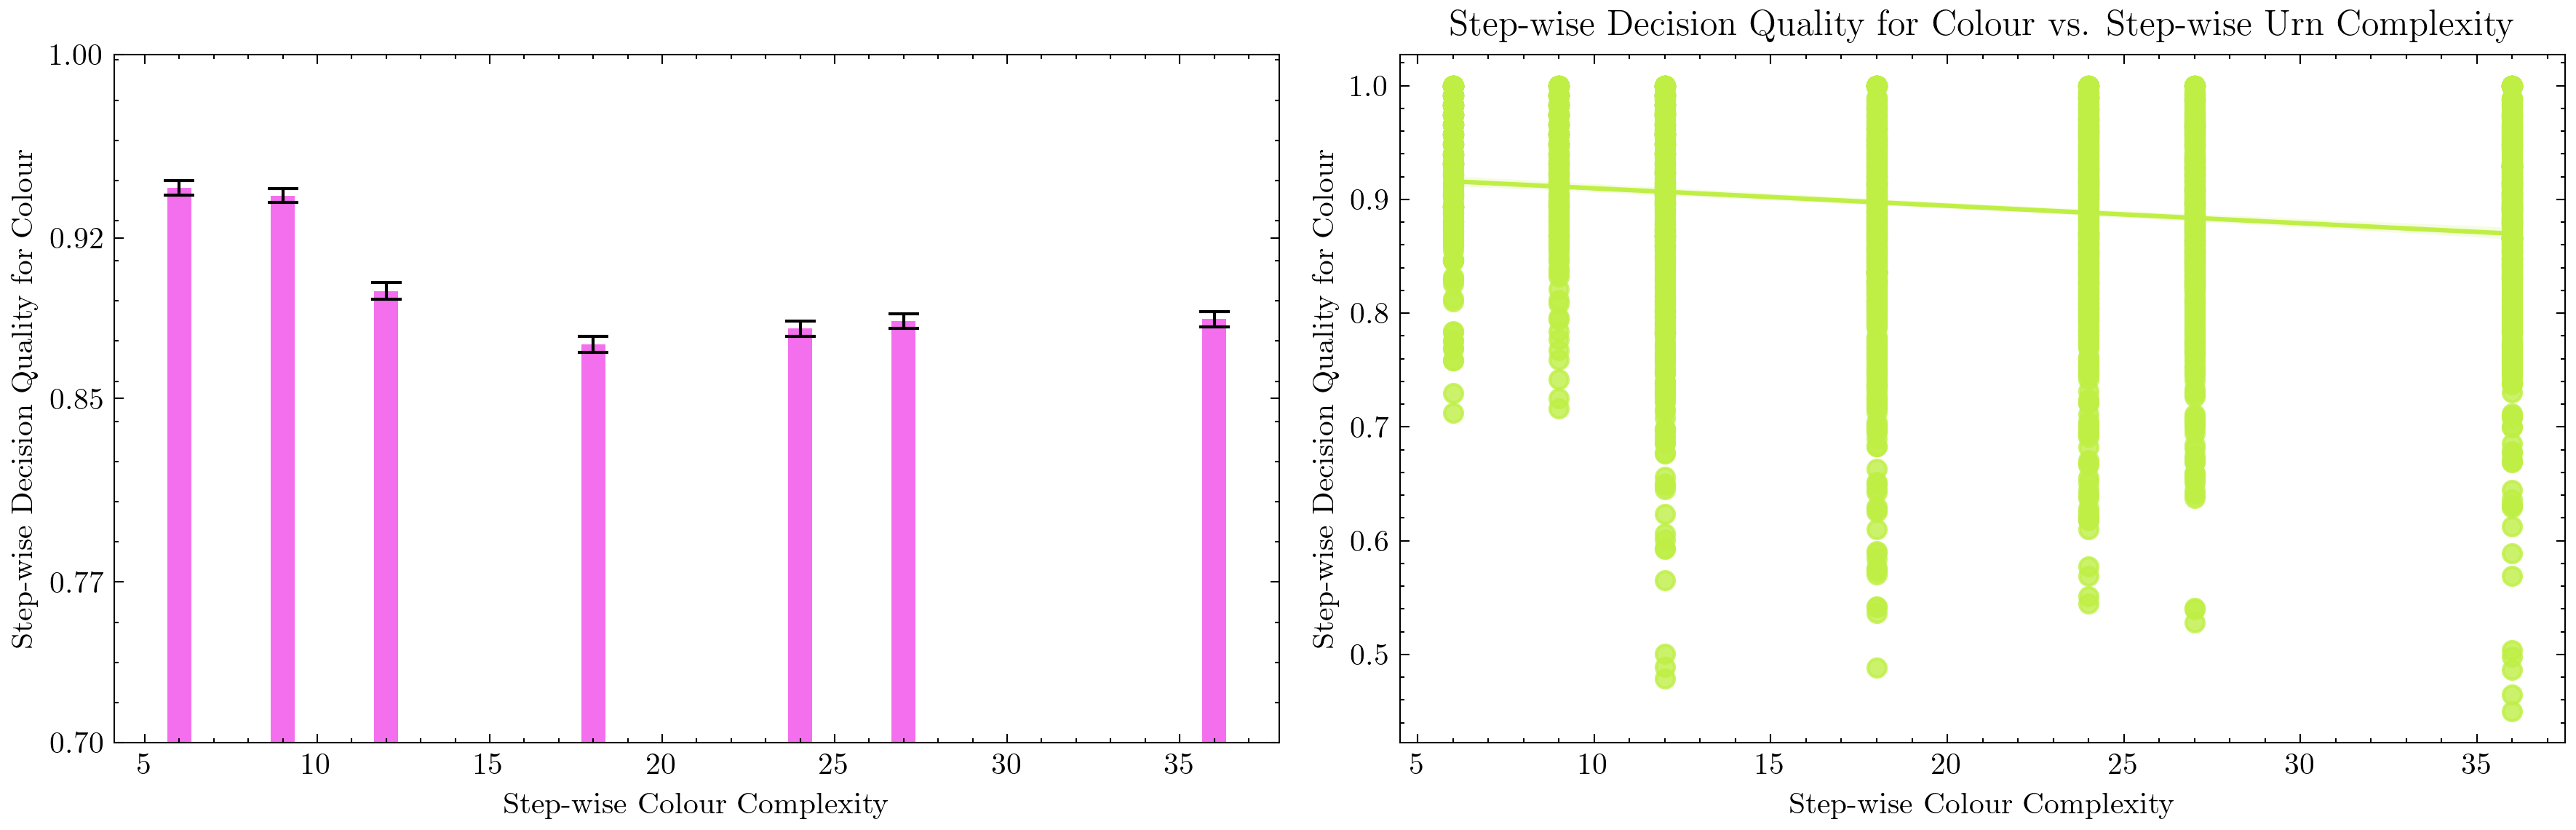

In [270]:
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
    twoAttributes_bar(participant_data, y_name='DQ_U_o', y_label='Overall Decision Quality for Urn', x_name='ACC_u', x_label='Accumulated Urn Complexity', out=False, axes=axes[0],ylimLow=0.7, ylimHigh=1,bar_width=1)
    regPlot(participant_data, x_name='ACC_u', y_name='DQ_U_o', title='Overall Decision Quality for Urn vs. Accumulated Urn Complexity',axes=axes[1],y_label='Overall Decision Quality for Urn',x_label='Accumulated Urn Complexity')
    fig.tight_layout()
    plt.savefig("images/DQ_ACC_Urn.png")
    plt.show()

with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
    twoAttributes_bar(participant_data, y_name='DQ_C_o', y_label='Overall Decision Quality for Colour', x_name='ACC_c', x_label='Accumulated Colour Complexity', out=False, axes=axes[0],ylimLow=0.7, ylimHigh=1,bar_width=1.5)
    regPlot(participant_data, x_name='ACC_c', y_name='DQ_C_o', title='Overall Decision Quality for Colour vs. Accumulated Urn Complexity',y_label='Overall Decision Quality for Colour', x_label='Accumulated Colour Complexity',axes=axes[1])
    fig.tight_layout()
    plt.savefig("images/DQ_ACC_Col.png")
    plt.show()

with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
    twoAttributes_bar(participant_data, y_name='DQ_U_s', y_label='Step-wise Decision Quality for Urn', x_name='CC_u', x_label='Step-wise Urn Complexity', out=False,axes=axes[0],ylimLow=0.7, ylimHigh=1,bar_width=0.5)
    regPlot(participant_data, x_name='CC_u', x_label='Step-wise Urn Complexity', y_name='DQ_U_s',y_label='Step-wise Decision Quality for Urn', title='Step-wise Decision Quality for Urn vs. Step-wise Urn Complexity',axes=axes[1])
    fig.tight_layout()
    plt.savefig("images/DQs_CC_Urn.png")
    plt.show()
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
    twoAttributes_bar(participant_data, y_name='DQ_C_s', y_label='Step-wise Decision Quality for Colour', x_name='CC_c', x_label='Step-wise Colour Complexity', out=False, axes=axes[0],ylimLow=0.7, ylimHigh=1,bar_width=0.7)
    regPlot(participant_data, x_name='CC_c',x_label='Step-wise Colour Complexity', y_name='DQ_C_s',y_label='Step-wise Decision Quality for Colour', title='Step-wise Decision Quality for Colour vs. Step-wise Urn Complexity',axes=axes[1])
    fig.tight_layout()
    plt.savefig("images/DQs_CC_Col.png")
    plt.show()

### Response Time Vs Complexity

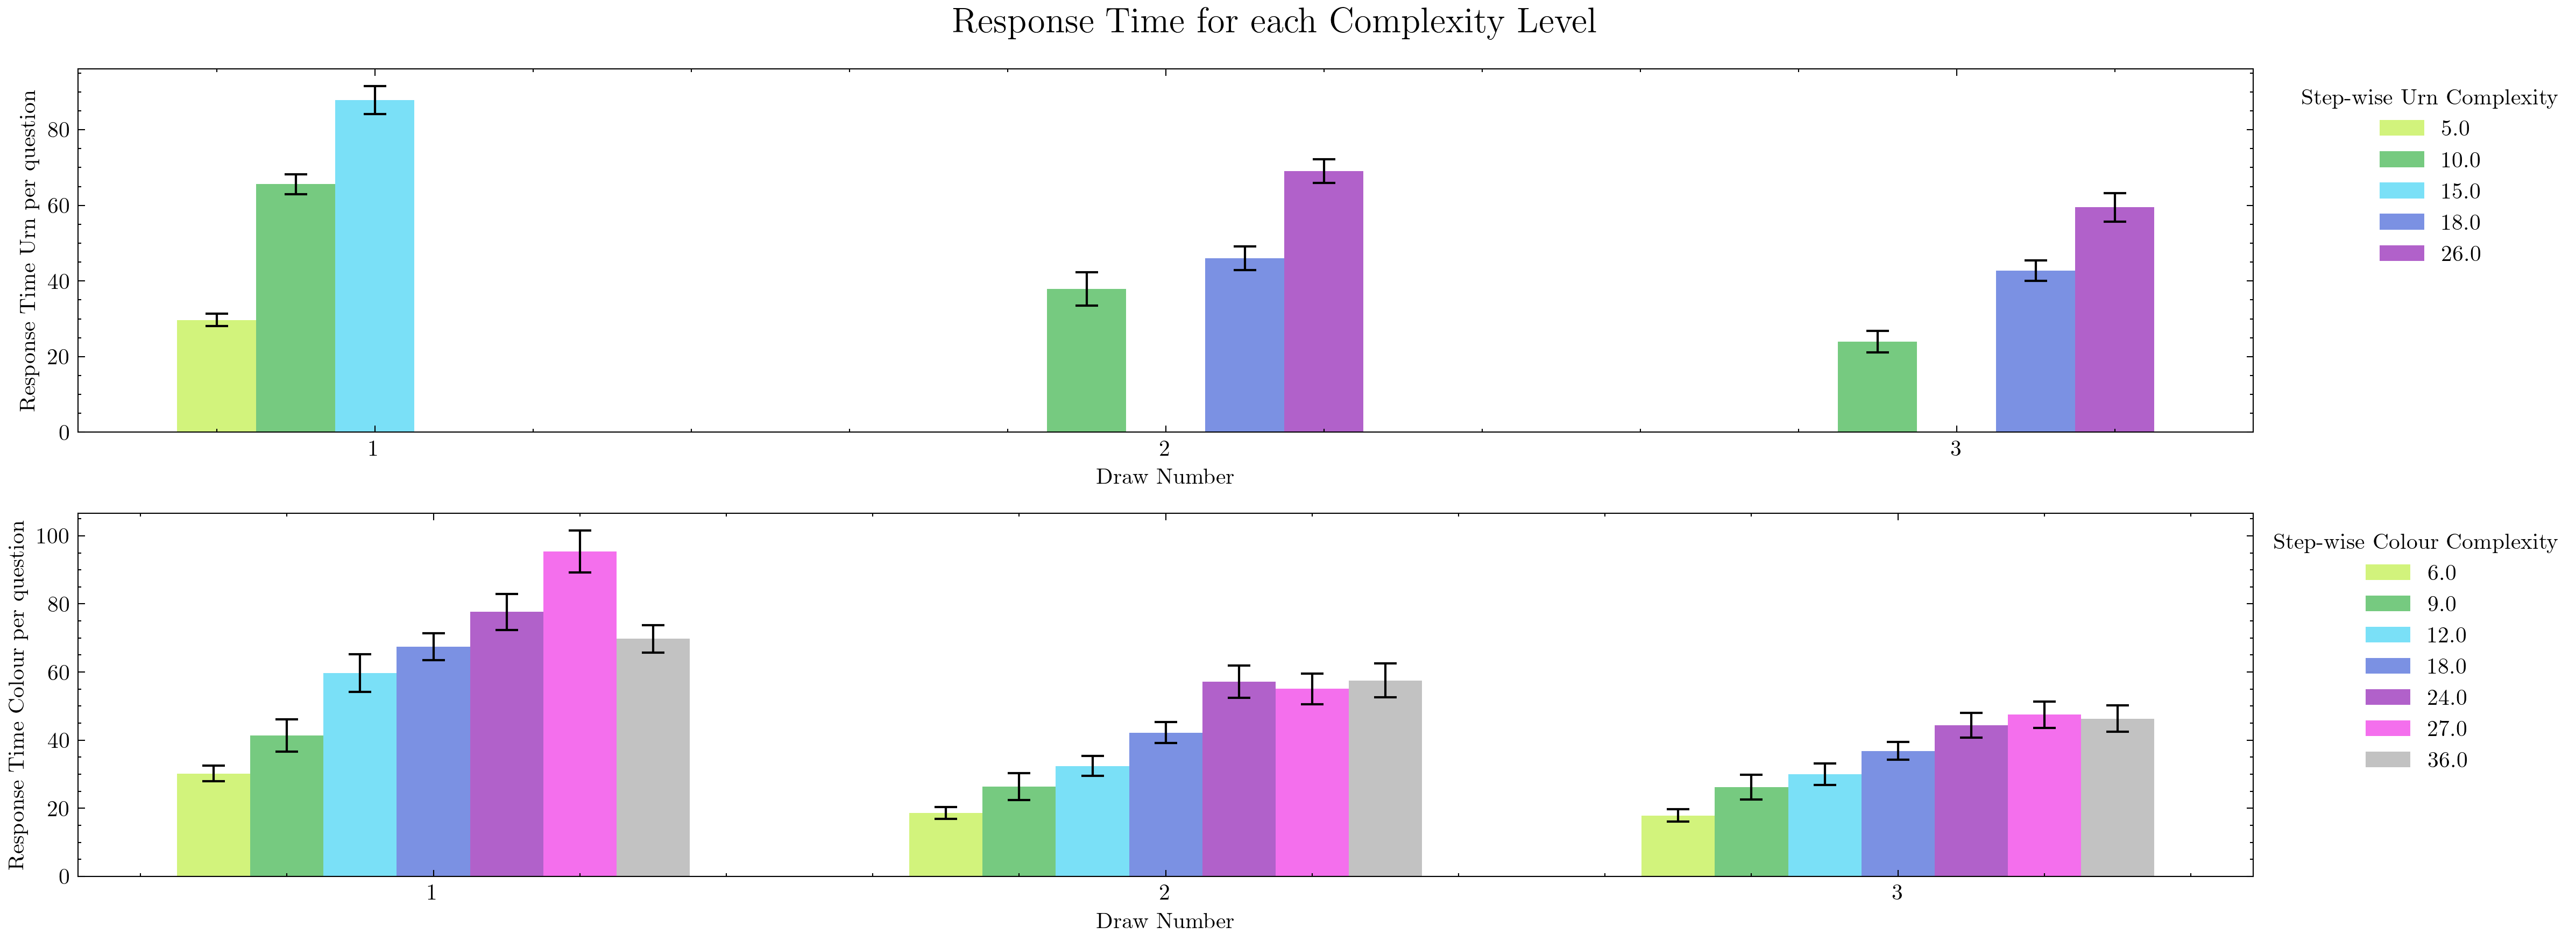

In [ ]:
with plt.style.context("science"):
    fig, axes = plt.subplots(2, 1, figsize=(16, 6), dpi=300)
    threeAttributes_bar(participant_data, lengend_var='CC_u', legend_title= "Step-wise Urn Complexity", y_name='responseTimeUrn', y_label='Response Time Urn per question', x_name='seqBall', x_label='Draw Number', bar_width=0.1, out=False, ax=axes[0])
    threeAttributes_bar(participant_data, lengend_var='CC_c', legend_title= "Step-wise Colour Complexity", y_name='responseTimeColour', y_label='Response Time Colour per question', x_name='seqBall', x_label='Draw Number', bar_width=0.1, out=False, ax=axes[1])
    fig.suptitle('Response Time for each Complexity Level', fontsize=16)
    fig.tight_layout()
    plt.savefig("images/RT_CC.png")
    plt.show()


In [ ]:
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 1, figsize=(5, 3), dpi=300)

    combTwoAttributes_bar(participant_data, y_name_1='responseTimeUrn', y_label_1='State Inference',
                           y_name_2='responseTimeColour', y_label_2='Future Forecasting', y_label_overall='Response Time',
                           x_name='seqBall', x_label='Draw Number', ylimLow=0, ylimHigh = 110, axes=axes)

    fig.tight_layout()
    plt.savefig("images/RT_draw_bar.png")     
    plt.show()

## Pool Urn Decision Quality and Complexity together

In [ ]:
# urnColumns = ['participantID', 'instanceName', 'responseTimeUrn', 'DQ_U_o', 'CC_u']
# colColumns = ['participantID', 'instanceName', 'responseTimeColour', 'DQ_C_o', 'CC_c']


# urn_df = participant_data[urnColumns]
# col_df = participant_data[colColumns]

# urn_df['questionType'] = 'Urn'
# col_df['questionType'] = 'Colour'

# urnColumnNameMappings = {'responseTimeUrn': 'responseTime', 
#                          'JSD_Urn': 'JSD',
#                          'urn_complexity_weighted': 'complexityWeighted',
#                          'urn_complexity_MD': 'complexityMD',
#                          'urn_complexity_total': 'complexityTotal'}

# colColumnNameMappings = {'responseTimeColour': 'responseTime',
#                             'JSD_Col': 'JSD',
#                             'col_complexity_weighted': 'complexityWeighted',
#                             'col_complexity_MD': 'complexityMD',
#                             'col_complexity_total': 'complexityTotal'}

# merged_df = pd.concat([urn_df.rename(columns= urnColumnNameMappings), 
#                        col_df.rename(columns= colColumnNameMappings)], 
#                       ignore_index=True)



## Basic Information

In [ ]:
# def qualityHistogram(df, title, x_name, x_label):
#     '''
#     Inputs: 
#     df is the input dataframe
#     x_name is the column name of the data to be plotted
#     x_label is the label for the x-axis
#     Ouputs: 
#     Histogram of the data
#     '''
#     with plt.style.context("science"):
#         plt.figure(figsize=(10, 6), dpi=100)
#         plt.hist(df[x_name], bins=10, range=(0,1), color=COLORS[1], edgecolor=COLORS[1], alpha=0.7)
#         plt.title(title)
#         plt.xlabel(x_label)
#         plt.ylabel('Frequency')
#         plt.xlim(0, 1)
#         plt.show()



In [ ]:
# qualityHistogram(participant_data, 'Histogram of JSD Urn', 'DQ_U_o', 'Decision Quality Urn')
# qualityHistogram(participant_data, 'Histogram of JSD Col', 'DQ_C_o', 'Decision Quality Colour')


# Regressions

## Bayesian Regressions

### H1-B In the state updating question, decision quality does not decrease as the number of potential signals (number of possible colors) in an instance increase, since more potential signals does not increase computational complexity.

In [ ]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c', 'DV_seqBall_1', 'DV_seqBall_2',
       'DV_seqBall_3'],
      dtype='object')

### H2-C In state updating task, step-wise decision quality for the third ball draw is no lower than for the second ball draw, as the belief updating process of the third and second draws have the same computational complexity.

### H4 In signal prediction task, the step-wise decision quality for the third ball draw is no lower than for the second ball draw and the first ball draw, as the belief updating process of the third draw has the same computational complexity with for the second draw and the first ball draw.

### H1 In the question regarding the hidden state of the world (the state updating task), decision quality is predicted to be negatively correlated with computational complexity.

### H2 In state updating task, step-wise decision quality (decision quality taking into account participants previous answers as priors of the next updating) is negatively correlated with step-wise computational complexity.

## Frequentist Models

In [ ]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c', 'DV_seqBall_1', 'DV_seqBall_2',
       'DV_seqBall_3'],
      dtype='object')

In [ ]:
# R1
model = mixedlm("DQ_U_o ~ ACC_u", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_U_o   
No. Observations: 3744    Method:             REML     
No. Groups:       104     Scale:              0.0097   
Min. group size:  36      Log-Likelihood:     3278.5384
Max. group size:  36      Converged:          Yes      
Mean group size:  36.0                                 
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.952    0.004 230.742 0.000  0.944  0.960
ACC_u       -0.003    0.000 -34.451 0.000 -0.003 -0.003
Group Var    0.001    0.002                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
# R2
model = mixedlm("DQ_C_o ~ ACC_c", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_C_o   
No. Observations: 3744    Method:             REML     
No. Groups:       104     Scale:              0.0059   
Min. group size:  36      Log-Likelihood:     4156.5355
Max. group size:  36      Converged:          Yes      
Mean group size:  36.0                                 
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.913    0.005 183.286 0.000  0.903  0.922
ACC_c       -0.001    0.000 -12.628 0.000 -0.001 -0.001
Group Var    0.002    0.004                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
# R3
model = mixedlm("DQ_U_o ~ urns + colours + seqBall", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_U_o   
No. Observations: 3744    Method:             REML     
No. Groups:       104     Scale:              0.0087   
Min. group size:  36      Log-Likelihood:     3460.4718
Max. group size:  36      Converged:          Yes      
Mean group size:  36.0                                 
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    1.107    0.010 115.134 0.000  1.088  1.125
urns        -0.013    0.002  -6.624 0.000 -0.016 -0.009
colours     -0.016    0.002  -8.236 0.000 -0.020 -0.012
seqBall     -0.075    0.002 -39.917 0.000 -0.078 -0.071
Group Var    0.001    0.002                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
# R4
model = mixedlm("DQ_C_o ~ urns + colours + seqBall", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_C_o   
No. Observations: 3744    Method:             REML     
No. Groups:       104     Scale:              0.0058   
Min. group size:  36      Log-Likelihood:     4186.3137
Max. group size:  36      Converged:          Yes      
Mean group size:  36.0                                 
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.976    0.009 112.991 0.000  0.959  0.993
urns         0.000    0.002   0.103 0.918 -0.003  0.003
colours     -0.022    0.002 -13.851 0.000 -0.025 -0.019
seqBall     -0.010    0.002  -6.717 0.000 -0.013 -0.007
Group Var    0.002    0.004                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
# R5
model = mixedlm("DQ_U_s ~ CC_u", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_U_s   
No. Observations: 3744    Method:             REML     
No. Groups:       104     Scale:              0.0075   
Min. group size:  36      Log-Likelihood:     3754.9737
Max. group size:  36      Converged:          Yes      
Mean group size:  36.0                                 
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.975    0.005 213.255 0.000  0.966  0.984
CC_u        -0.006    0.000 -27.939 0.000 -0.006 -0.005
Group Var    0.001    0.002                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
# R6
model = mixedlm("DQ_C_s ~ CC_c", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: DQ_C_s   
No. Observations: 3744    Method:             REML     
No. Groups:       104     Scale:              0.0048   
Min. group size:  36      Log-Likelihood:     4538.7780
Max. group size:  36      Converged:          Yes      
Mean group size:  36.0                                 
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.925    0.005 172.360 0.000  0.915  0.936
CC_c        -0.002    0.000 -12.955 0.000 -0.002 -0.001
Group Var    0.002    0.005                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c', 'DV_seqBall_1', 'DV_seqBall_2',
       'DV_seqBall_3'],
      dtype='object')

In [ ]:
# R7
model = mixedlm("DQ_U_o ~ probSubject + bayesInExp", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      DQ_U_o   
No. Observations:       3744         Method:                  REML     
No. Groups:             104          Scale:                   0.0129   
Min. group size:        36           Log-Likelihood:          2760.2354
Max. group size:        36           Converged:               Yes      
Mean group size:        36.0                                           
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.884    0.024 36.577 0.000  0.837  0.931
probSubject[T.Yes]            0.005    0.007  0.703 0.482 -0.009  0.020
bayesInExp[T.Never]          -0.023    0.025 -0.928 0.354 -0.071  0.025
bayesInExp[T.Not Applicable] -0.022    0.025 -0.876 0.381 -0.070  0.027
bayesInEx

/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
# R8
model = mixedlm("DQ_C_o ~ probSubject + bayesInExp", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      DQ_C_o   
No. Observations:      3744         Method:                  REML     
No. Groups:            104          Scale:                   0.0061   
Min. group size:       36           Log-Likelihood:          4080.2033
Max. group size:       36           Converged:               Yes      
Mean group size:       36.0                                           
----------------------------------------------------------------------
                             Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.865    0.032 26.967 0.000  0.802  0.928
probSubject[T.Yes]           0.002    0.010  0.242 0.809 -0.017  0.022
bayesInExp[T.Never]          0.005    0.033  0.141 0.888 -0.059  0.068
bayesInExp[T.Not Applicable] 0.025    0.033  0.779 0.436 -0.038  0.089
bayesInExp[T.Sometimes]

/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
participant_data.columns

Index(['participantID', 'instanceName', 'seqBall', 'responseTimeUrn',
       'responseTimeColour', 'age', 'sex', 'probSubject', 'bayesFamaliar',
       'bayesInExp', 'uA_r', 'uB_r', 'cB_r', 'cW_r', 'cP_r', 'cG_r', 'uC_r',
       'uD_r', 'urns', 'colours', 'uA_c', 'uB_c', 'cB_c', 'cW_c', 'cP_c',
       'cG_c', 'uC_c', 'uD_c', 'uA_s', 'uB_s', 'uC_s', 'uD_s', 'cB_s', 'cW_s',
       'cP_s', 'cG_s', 'diff_uA', 'diff_uB', 'diff_uC', 'diff_uD', 'diff_cB',
       'diff_cW', 'diff_cP', 'diff_cG', 'JSD_U_rc', 'JSD_C_rc', 'JSD_U_rs',
       'JSD_C_rs', 'DQ_U_o', 'DQ_C_o', 'DQ_U_s', 'DQ_C_s', 'EWCC_u', 'MDCC_u',
       'CC_u', 'EWCC_c', 'MDCC_c', 'CC_c', 'ACC_u', 'ACC_c', 'AEWCC_u',
       'AEWCC_c', 'AMDCC_u', 'AMDCC_c', 'DV_seqBall_1', 'DV_seqBall_2',
       'DV_seqBall_3'],
      dtype='object')

In [ ]:
# R9
model = mixedlm("DQ_U_s ~ DV_seqBall_1 + DV_seqBall_3", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: DQ_U_s   
No. Observations:  3744    Method:             REML     
No. Groups:        104     Scale:              0.0066   
Min. group size:   36      Log-Likelihood:     3977.8771
Max. group size:   36      Converged:          Yes      
Mean group size:   36.0                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.849    0.004 233.356 0.000  0.842  0.856
DV_seqBall_1  0.102    0.003  31.285 0.000  0.096  0.108
DV_seqBall_3 -0.004    0.003  -1.311 0.190 -0.011  0.002
Group Var     0.001    0.002                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
# R10
model = mixedlm("DQ_U_s ~ DV_seqBall_2 + DV_seqBall_3", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: DQ_U_s   
No. Observations:  3744    Method:             REML     
No. Groups:        104     Scale:              0.0066   
Min. group size:   36      Log-Likelihood:     3977.8771
Max. group size:   36      Converged:          Yes      
Mean group size:   36.0                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.951    0.004 261.385 0.000  0.943  0.958
DV_seqBall_2 -0.102    0.003 -31.285 0.000 -0.108 -0.096
DV_seqBall_3 -0.106    0.003 -32.597 0.000 -0.113 -0.100
Group Var     0.001    0.002                            



/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# MSE

## Load data

In [122]:
participant_data = pd.read_csv('participant_data.csv')

with open("input.json") as f:
    bu_data = json.load(f)

participant_data

participantID  instanceName  seqBall  responseTimeUrn  \
0                 1             1        1            22.43   
1                 1             1        2            10.50   
2                 1             1        3             7.27   
3                 2             1        1            13.30   
4                 2             1        2            11.68   
...             ...           ...      ...              ...   
3739            117            18        2            34.62   
3740            117            18        3            79.35   
3741            118            18        1            30.47   
3742            118            18        2            26.90   
3743            118            18        3            68.98   

      responseTimeColour  age     sex probSubject bayesFamaliar  \
0                  11.40   18  Female          No           Yes   
1                  10.10   18  Female          No           Yes   
2                  13.47   18  Female          No           Yes   
3                  20.47   31  Female          No            No   
4                  37.35   31  Female          No            No   
...                  ...  ...     ...         ...           ...   
3739               46.30   32  Female          No            No   
3740               47.35   32  Female          No            No   
3741              147.07   20  Female         Yes           Yes   
3742               33.02   20  Female         Yes           Yes   
3743              145.42   20  Female         Yes           Yes   

          bayesInExp  uA_r  uB_r  cB_r  cW_r  cP_r  cG_r  uC_r  uD_r  urns  \
0              Never 30.00 70.00 45.00 55.00   NaN   NaN   NaN   NaN     2   
1              Never 70.00 30.00 55.00 45.00   NaN   NaN   NaN   NaN     2   
2              Never 30.00 70.00 45.00 55.00   NaN   NaN   NaN   NaN     2   
3              Never 30.00 70.00 33.00 67.00   NaN   NaN   NaN   NaN     2   
4              Never 40.00 60.00 22.00 78.00   NaN   NaN   NaN   NaN     2   
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3739  Not Applicable  9.00 16.00 14.00 24.00 31.00 31.00 38.00 37.00     4   
3740  Not Applicable 16.00 15.00 13.00 19.00 34.00 34.00 41.00 28.00     4   
3741       Sometimes 10.00 20.00 10.00 15.00 35.00 40.00 30.00 40.00     4   
3742       Sometimes 10.00 10.00 10.00 10.00 40.00 40.00 40.00 40.00     4   
3743       Sometimes 12.00  8.00 17.00 14.00 36.00 33.00 45.00 35.00     4   

      colours  uA_c  uB_c  cB_c  cW_c  cP_c  cG_c  uC_c  uD_c  uA_s  uB_s  \
0           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 30.00 70.00   
1           2 50.00 50.00 50.00 50.00   NaN   NaN   NaN   NaN 50.00 50.00   
2           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 50.00 50.00   
3           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 30.00 70.00   
4           2 50.00 50.00 50.00 50.00   NaN   NaN   NaN   NaN 50.00 50.00   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3739        4  7.00  7.00 18.00 18.00 32.00 32.00 43.00 43.00  7.00  7.00   
3740        4  4.00  2.00 17.00 15.00 34.00 33.00 53.00 40.00  6.00  5.00   
3741        4 10.00 20.00 20.00 22.00 28.00 30.00 30.00 40.00 10.00 20.00   
3742        4  7.00  7.00 18.00 18.00 32.00 32.00 43.00 43.00  7.00  7.00   
3743        4  4.00  2.00 17.00 15.00 34.00 33.00 53.00 40.00  6.00  3.00   

      uC_s  uD_s  cB_s  cW_s  cP_s  cG_s  diff_uA  diff_uB  diff_uC  diff_uD  \
0      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
1      NaN   NaN 58.00 42.00   NaN   NaN    20.00    20.00      NaN      NaN   
2      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
3      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
4      NaN   NaN 46.00 54.00   NaN   NaN    10.00    10.00      NaN      NaN   
...    ...   ...   ...   ...   ...   ...      ...      ...      ...      ...   
3739 43.00 43.00 20.00

## Extract Chosen urn from the input file

In [123]:
chosen_urns = {key: entry[key]["chosenUrn"] for entry in bu_data for key in entry}

print(chosen_urns)  

chosen_urns_df = pd.DataFrame(chosen_urns.items(), columns=["BU", "Chosen Urn"])
# filter out the practice row using boolean indexing (drop with a boolean Series causes KeyError)
chosen_urns_df = chosen_urns_df[chosen_urns_df['BU'] != "BUPractice"].reset_index(drop=True)
chosen_urns_df['chosen_urn_A'] = chosen_urns_df['Chosen Urn'].apply(lambda x: 100 if x == 'A' else 0)
chosen_urns_df['chosen_urn_B'] = chosen_urns_df['Chosen Urn'].apply(lambda x: 100 if x == 'B' else 0)
chosen_urns_df['chosen_urn_C'] = chosen_urns_df['Chosen Urn'].apply(lambda x: 100 if x == 'C' else 0)
chosen_urns_df['chosen_urn_D'] = chosen_urns_df['Chosen Urn'].apply(lambda x: 100 if x == 'D' else 0)

chosen_urns_df

{'BU1': 'B', 'BU2': 'A', 'BU3': 'A', 'BU4': 'A', 'BU5': 'B', 'BU6': 'A', 'BU7': 'B', 'BU8': 'A', 'BU9': 'C', 'BU10': 'B', 'BU11': 'C', 'BU12': 'A', 'BU13': 'C', 'BU14': 'B', 'BU15': 'D', 'BU16': 'C', 'BU17': 'B', 'BU18': 'D', 'BUPractice': 'B'}


BU Chosen Urn  chosen_urn_A  chosen_urn_B  chosen_urn_C  chosen_urn_D
0    BU1          B             0           100             0             0
1    BU2          A           100             0             0             0
2    BU3          A           100             0             0             0
3    BU4          A           100             0             0             0
4    BU5          B             0           100             0             0
5    BU6          A           100             0             0             0
6    BU7          B             0           100             0             0
7    BU8          A           100             0             0             0
8    BU9          C             0             0           100             0
9   BU10          B             0           100             0             0
10  BU11          C             0             0           100             0
11  BU12          A           100             0             0             0
12  BU13          C             0             0           100             0
13  BU14          B             0           100             0             0
14  BU15          D             0             0             0           100
15  BU16          C             0             0           100             0
16  BU17          B             0           100             0             0
17  BU18          D             0             0             0           100

In [124]:
import re

totalBalls = {key: entry[key]["urnInfo"][-1]['balls'] for entry in bu_data for key in entry}
totalBalls_df = pd.DataFrame.from_dict(totalBalls, orient='index', columns=['totalBalls']).reset_index().rename(columns={'index':'BU'})

urn_composition = {key: entry[key]["urnInfo"][-1]["composition"] for entry in bu_data for key in entry}

# build a dataframe from urn_composition dict
urn_comp_df = pd.DataFrame.from_dict(urn_composition, orient='index', columns=['totalBalls_B','totalBalls_W','totalBalls_P', 'totalBalls_G']).reset_index().rename(columns={'index':'BU'})

cols = ['totalBalls_B','totalBalls_W','totalBalls_P','totalBalls_G']

# Remove any non-digit characters (letters) and convert empty -> NA, then to nullable integers
for c in cols:
    urn_comp_df[c] = urn_comp_df[c].astype(str).replace('None', '', regex=False)
    urn_comp_df[c] = urn_comp_df[c].str.replace(r'\D+', '', regex=True)
    urn_comp_df[c] = urn_comp_df[c].replace('', pd.NA)

urn_comp_df[cols] = urn_comp_df[cols].apply(pd.to_numeric, errors='coerce').astype('Int64')



In [125]:
input_info_df = pd.merge(chosen_urns_df, totalBalls_df, on='BU', how='left')
input_info_df = pd.merge(input_info_df, urn_comp_df, on='BU', how='left')
input_info_df

BU Chosen Urn  chosen_urn_A  chosen_urn_B  chosen_urn_C  chosen_urn_D  \
0    BU1          B             0           100             0             0   
1    BU2          A           100             0             0             0   
2    BU3          A           100             0             0             0   
3    BU4          A           100             0             0             0   
4    BU5          B             0           100             0             0   
5    BU6          A           100             0             0             0   
6    BU7          B             0           100             0             0   
7    BU8          A           100             0             0             0   
8    BU9          C             0             0           100             0   
9   BU10          B             0           100             0             0   
10  BU11          C             0             0           100             0   
11  BU12          A           100             0             0             0   
12  BU13          C             0             0           100             0   
13  BU14          B             0           100             0             0   
14  BU15          D             0             0             0           100   
15  BU16          C             0             0           100             0   
16  BU17          B             0           100             0             0   
17  BU18          D             0             0             0           100   

    totalBalls  totalBalls_B  totalBalls_W  totalBalls_P  totalBalls_G  
0           20            10            10          <NA>          <NA>  
1           20            10            10          <NA>          <NA>  
2           20             9             3             8          <NA>  
3           20             9             3             8          <NA>  
4           20             5             5             5             5  
5           20             5             5             5             5  
6           30            15            15          <NA>          <NA>  
7           30            15            15          <NA>          <NA>  
8           30            10            10            10          <NA>  
9           30            10            10            10          <NA>  
10          30             8             7             7             8  
11          30             8             7             7             8  
12          40            20            20          <NA>          <NA>  
13          40            20            20          <NA>          <NA>  
14          40            13            14            13          <NA>  
15          40            13            14            13          <NA>  
16          40            10            10            10            10  
17          40            10            10            10            10

In [126]:
input_info_df['BU'] = input_info_df['BU'].str.replace(r'^BU', '', regex=True)
# convert BU to numeric; since BUPractice was removed this should coerce properly
input_info_df['BU'] = pd.to_numeric(input_info_df['BU'], errors='coerce')

## Merge the file with participant data

In [127]:
participant_data['instanceName'] = pd.to_numeric(participant_data['instanceName'], errors='ignore')
participant_data = participant_data.merge(input_info_df, left_on='instanceName', right_on='BU', how='left')
participant_data.drop(columns=['BU'], inplace=True)
participant_data

participantID  instanceName  seqBall  responseTimeUrn  \
0                 1             1        1            22.43   
1                 1             1        2            10.50   
2                 1             1        3             7.27   
3                 2             1        1            13.30   
4                 2             1        2            11.68   
...             ...           ...      ...              ...   
3739            117            18        2            34.62   
3740            117            18        3            79.35   
3741            118            18        1            30.47   
3742            118            18        2            26.90   
3743            118            18        3            68.98   

      responseTimeColour  age     sex probSubject bayesFamaliar  \
0                  11.40   18  Female          No           Yes   
1                  10.10   18  Female          No           Yes   
2                  13.47   18  Female          No           Yes   
3                  20.47   31  Female          No            No   
4                  37.35   31  Female          No            No   
...                  ...  ...     ...         ...           ...   
3739               46.30   32  Female          No            No   
3740               47.35   32  Female          No            No   
3741              147.07   20  Female         Yes           Yes   
3742               33.02   20  Female         Yes           Yes   
3743              145.42   20  Female         Yes           Yes   

          bayesInExp  uA_r  uB_r  cB_r  cW_r  cP_r  cG_r  uC_r  uD_r  urns  \
0              Never 30.00 70.00 45.00 55.00   NaN   NaN   NaN   NaN     2   
1              Never 70.00 30.00 55.00 45.00   NaN   NaN   NaN   NaN     2   
2              Never 30.00 70.00 45.00 55.00   NaN   NaN   NaN   NaN     2   
3              Never 30.00 70.00 33.00 67.00   NaN   NaN   NaN   NaN     2   
4              Never 40.00 60.00 22.00 78.00   NaN   NaN   NaN   NaN     2   
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3739  Not Applicable  9.00 16.00 14.00 24.00 31.00 31.00 38.00 37.00     4   
3740  Not Applicable 16.00 15.00 13.00 19.00 34.00 34.00 41.00 28.00     4   
3741       Sometimes 10.00 20.00 10.00 15.00 35.00 40.00 30.00 40.00     4   
3742       Sometimes 10.00 10.00 10.00 10.00 40.00 40.00 40.00 40.00     4   
3743       Sometimes 12.00  8.00 17.00 14.00 36.00 33.00 45.00 35.00     4   

      colours  uA_c  uB_c  cB_c  cW_c  cP_c  cG_c  uC_c  uD_c  uA_s  uB_s  \
0           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 30.00 70.00   
1           2 50.00 50.00 50.00 50.00   NaN   NaN   NaN   NaN 50.00 50.00   
2           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 50.00 50.00   
3           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 30.00 70.00   
4           2 50.00 50.00 50.00 50.00   NaN   NaN   NaN   NaN 50.00 50.00   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3739        4  7.00  7.00 18.00 18.00 32.00 32.00 43.00 43.00  7.00  7.00   
3740        4  4.00  2.00 17.00 15.00 34.00 33.00 53.00 40.00  6.00  5.00   
3741        4 10.00 20.00 20.00 22.00 28.00 30.00 30.00 40.00 10.00 20.00   
3742        4  7.00  7.00 18.00 18.00 32.00 32.00 43.00 43.00  7.00  7.00   
3743        4  4.00  2.00 17.00 15.00 34.00 33.00 53.00 40.00  6.00  3.00   

      uC_s  uD_s  cB_s  cW_s  cP_s  cG_s  diff_uA  diff_uB  diff_uC  diff_uD  \
0      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
1      NaN   NaN 58.00 42.00   NaN   NaN    20.00    20.00      NaN      NaN   
2      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
3      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
4      NaN   NaN 46.00 54.00   NaN   NaN    10.00    10.00      NaN      NaN   
...    ...   ...   ...   ...   ...   ...      ...      ...      ...      ...   
3739 43.00 43.00 20.00

## Calculate MSE 

In [15]:
def MSE(row, namelis1, namelis2):
    count = 0
    SSE = 0
    for i in range(len(namelis1)):
        if not (pd.isna(row[namelis1[i]]) or pd.isna(row[namelis2[i]])):
            SSE += (row[namelis1[i]] - row[namelis2[i]]) ** 2
            count += 1
    return SSE / count

In [ ]:
urn_reported = ['uA_r', 'uB_r', 'uC_r', 'uD_r']
urn_Bayesian = ['uA_c', 'uB_c', 'uC_c', 'uD_c']
urn_chosen = ['chosen_urn_A', 'chosen_urn_B', 'chosen_urn_C', 'chosen_urn_D']

col_reported = ['cB_r', 'cW_r', 'cP_r', 'cG_r']
col_Bayesian = ['cB_c', 'cW_c', 'cP_c', 'cG_c']

participant_data['MSE_hsi_RvB'] =participant_data.apply(MSE, axis=1, namelis1= urn_reported, namelis2=urn_Bayesian)
participant_data['MSE_ff_RvB'] = participant_data.apply(MSE, axis=1, namelis1= col_reported, namelis2=col_Bayesian)
participant_data['MSE_hsi_CvR'] = participant_data.apply(MSE, axis=1, namelis1= urn_chosen, namelis2=urn_reported)
participant_data['MSE_hsi_CvB'] = participant_data.apply(MSE, axis=1, namelis1= urn_chosen, namelis2=urn_Bayesian)

participant_data['MSE_hsi_diff_CvR_CvB'] = participant_data['MSE_hsi_CvR'] - participant_data['MSE_hsi_CvB']


### Check if the variables are correct

In [129]:
participant_data['MSE_ff_RvB']

0        9.00
1       25.00
2        9.00
3       81.00
4      784.00
        ...  
3739    13.50
3740     8.25
3741    74.50
3742    64.00
3743     1.25
Name: MSE_ff_RvB, Length: 3744, dtype: float64

In [130]:
participant_data.loc[1190,  col_reported + col_Bayesian]

cB_r   36.00
cW_r   64.00
cP_r     NaN
cG_r     NaN
cB_c   45.00
cW_c   55.00
cP_c     NaN
cG_c     NaN
Name: 1190, dtype: object

## Analysis on the MSE

### Compare Information Therotic Limit (MSE_hsi_CvB) and human performance (MSE_hsi_CvR)

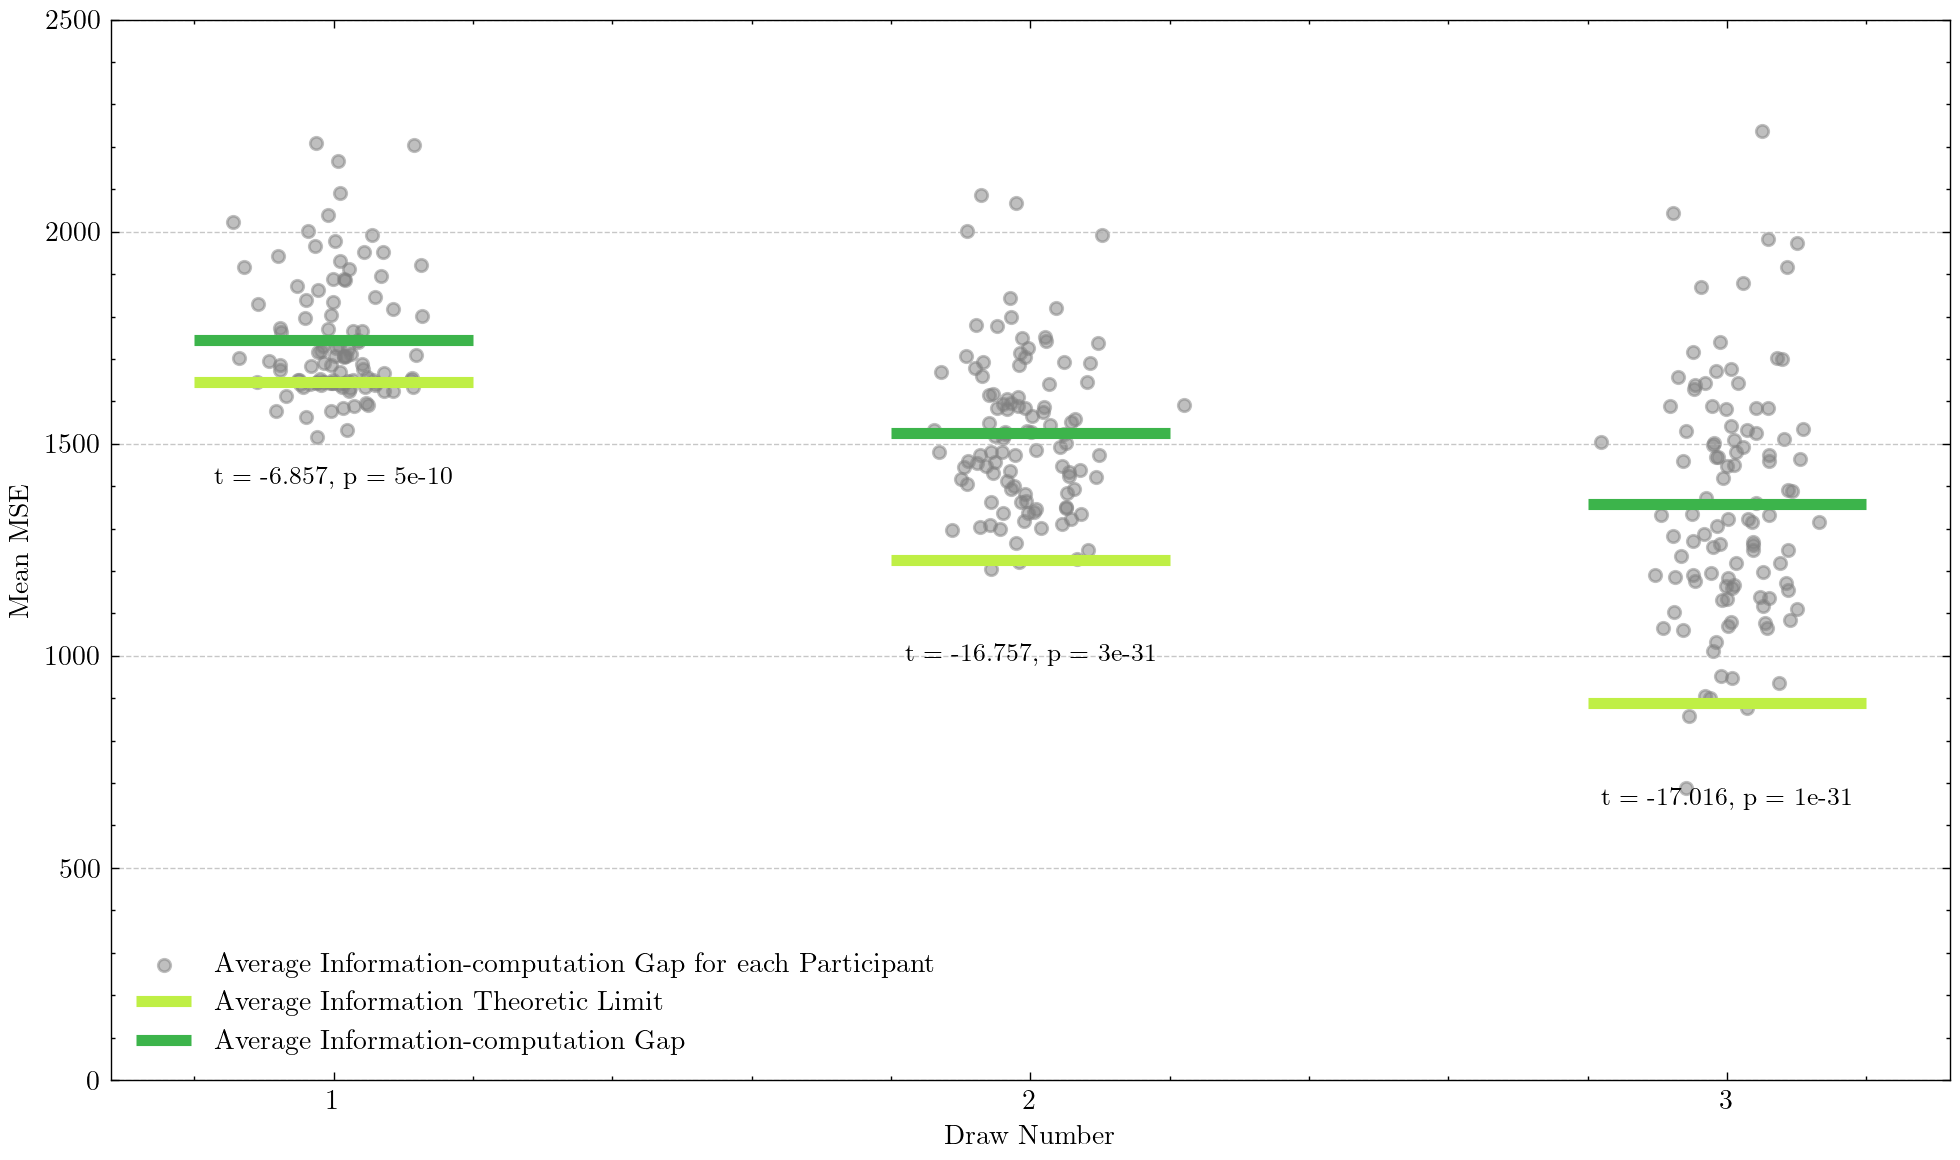

In [ ]:
from scipy import stats
mpl.rcParams["text.usetex"] = False

ballSeq = np.sort(participant_data['seqBall'].unique())

mse_hsi_CvB_means = participant_data.groupby('seqBall')['MSE_hsi_CvB'].mean()
mse_hsi_CvR_means = participant_data.groupby('seqBall')['MSE_hsi_CvR'].mean()

# participant-level average per seqBall for both measures (paired test)
part_pair = participant_data.groupby(['participantID', 'seqBall'])[['MSE_hsi_CvB','MSE_hsi_CvR']].mean().reset_index()

half_width = 0.2  # half-length of the horizontal tick
jitter = 0.06

# run paired t-tests per seqBall and store results for annotation
ttest_results = {}
for x in ballSeq:
    sub = part_pair.loc[part_pair['seqBall'] == x].dropna(subset=['MSE_hsi_CvB','MSE_hsi_CvR'])
    if len(sub) >= 2:
        tstat, pval = stats.ttest_rel(sub['MSE_hsi_CvB'], sub['MSE_hsi_CvR'])
        ttest_results[int(x)] = (tstat, pval)
    else:
        ttest_results[int(x)] = (np.nan, np.nan)

with plt.style.context("science"):
    plt.figure(figsize=(10, 6), dpi=200)

    # plot participant-level averages as grey dots with alpha=0.5 (with horizontal jitter)
    for x in ballSeq:
        vals = part_pair.loc[part_pair['seqBall'] == x, 'MSE_hsi_CvR'].values
        if len(vals):
            x_jitter = x + np.random.normal(loc=0, scale=jitter, size=len(vals))
            plt.scatter(x_jitter, vals, color='grey', alpha=0.5, s=20, label='Average Information-computation Gap for each Participant' if x == ballSeq[0] else "")

    # plot the mean horizontal bars on top
    for i, x in enumerate(ballSeq):
        y1 = mse_hsi_CvB_means.loc[x]
        y2 = mse_hsi_CvR_means.loc[x]
        plt.hlines(y1, x - half_width, x + half_width, color=COLORS[0], linewidth=4,
                    label='Average Information Theoretic Limit (Chosen Vs Bayesian)' if i == 0 else "")
        plt.hlines(y2, x - half_width, x + half_width, color=COLORS[1], linewidth=4,
                    label='Average Information-computation Gap (Chosen Vs Reported)' if i == 0 else "")

    # annotate t-test results below the mean bars for each x
    y_offset = 200  # vertical offset in same units as MSE to place annotation below the bars

    for i, x in enumerate(ballSeq):
        tstat, pval = ttest_results.get(int(x), (np.nan, np.nan))
        if np.isfinite(tstat) and np.isfinite(pval):
            p_text = f"p = {pval:.1g}" if pval < 0.001 else f"p = {pval:.3f}"
            ann = f"t = {tstat:.3f}, {p_text}"
        else:
            ann = "n/a"

        # place the text below the lower of the two mean horizontal bars for this x
        y_mean_low = min(mse_hsi_CvB_means.loc[x], mse_hsi_CvR_means.loc[x])
        y_pos = y_mean_low - y_offset
        plt.text(x, y_pos, ann, ha='center', va='top', fontsize=9)

    plt.xticks(ballSeq)
    plt.xlabel('Draw Number')
    plt.ylabel('Mean MSE')
    plt.ylim(0, 2500)
    # plt.title('Mean MSE by Draw Number')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("images/MSE_hsi_CvR_CvB_by_seqBall.png")
    plt.show()




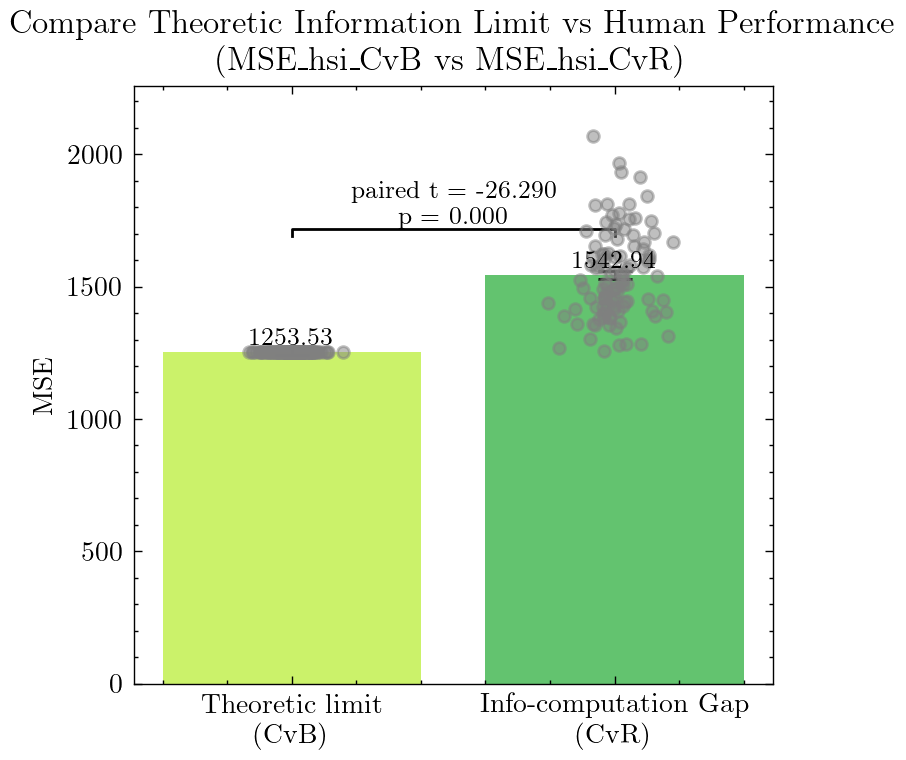

Paired t-test result:
  t = -26.2905, p = 6.11302e-140, n = 3744


In [132]:
from scipy.stats import ttest_rel
import numpy as np

# Columns to compare
col_theoretic = 'MSE_hsi_CvB'
col_human = 'MSE_hsi_CvR'

# keep only paired non-missing rows
paired = participant_data[[col_theoretic, col_human]].dropna()

means = paired.mean()
sems = paired.sem()

# paired t-test
tstat, pval = ttest_rel(paired[col_theoretic], paired[col_human])

# compute participant-level averages for jittered dots
part_means = participant_data.groupby('participantID')[[col_theoretic, col_human]].mean().dropna()
n_part = len(part_means)

# Plot
with plt.style.context("science"):
    fig, ax = plt.subplots(figsize=(4,4), dpi=200)
    x = [0, 1]
    heights = [means[col_theoretic], means[col_human]]
    yerr = [sems[col_theoretic], sems[col_human]]
    bars = ax.bar(x, heights, yerr=yerr, capsize=6, color=[COLORS[0], COLORS[1]], alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(['Theoretic limit\n(CvB)', 'Info-computation Gap\n(CvR)'])
    ax.set_ylabel('MSE')
    ax.set_ylim(0, max(heights) + max(yerr) + 700)
    ax.set_title('Compare Theoretic Information Limit vs Human Performance\n(MSE_hsi_CvB vs MSE_hsi_CvR)')

    # jittered participant means (grey dots)
    jitter_scale = 0.06
    xs0 = np.zeros(n_part) + np.random.normal(0, jitter_scale, n_part)
    xs1 = np.ones(n_part)  + np.random.normal(0, jitter_scale, n_part)
    ax.scatter(xs0, part_means[col_theoretic], color='grey', alpha=0.5, s=18, zorder=3)
    ax.scatter(xs1, part_means[col_human],    color='grey', alpha=0.5, s=18, zorder=3)

    # annotate mean values on bars
    for xi, h in zip(x, heights):
        ax.text(xi, h + max(yerr)*0.6, f"{h:.2f}", ha='center', va='bottom', fontsize=9)

    # significance bracket + t-test text
    y_max = max(heights) + max(yerr) * 15
    bracket_y = y_max * 0.98
    line_h = (y_max - max(heights)) * 0.12
    ax.plot([x[0], x[0], x[1], x[1]], [bracket_y - line_h, bracket_y, bracket_y, bracket_y - line_h], color='k')
    p_text = f"paired t = {tstat:.3f}\n p = {pval:.3f}"
    ax.text(0.5, bracket_y + max(yerr)*0.2, p_text, ha='center', va='bottom', fontsize=9)

    fig.tight_layout()
    plt.show()

# print results in cell output as well
print("Paired t-test result:")
print(f"  t = {tstat:.4f}, p = {pval:.6g}, n = {len(paired)}")

## Test if MSE_hsi_diff_CvR_CvB = 'MSE_hsi_CvR' - 'MSE_hsi_CvB' increase with ACC


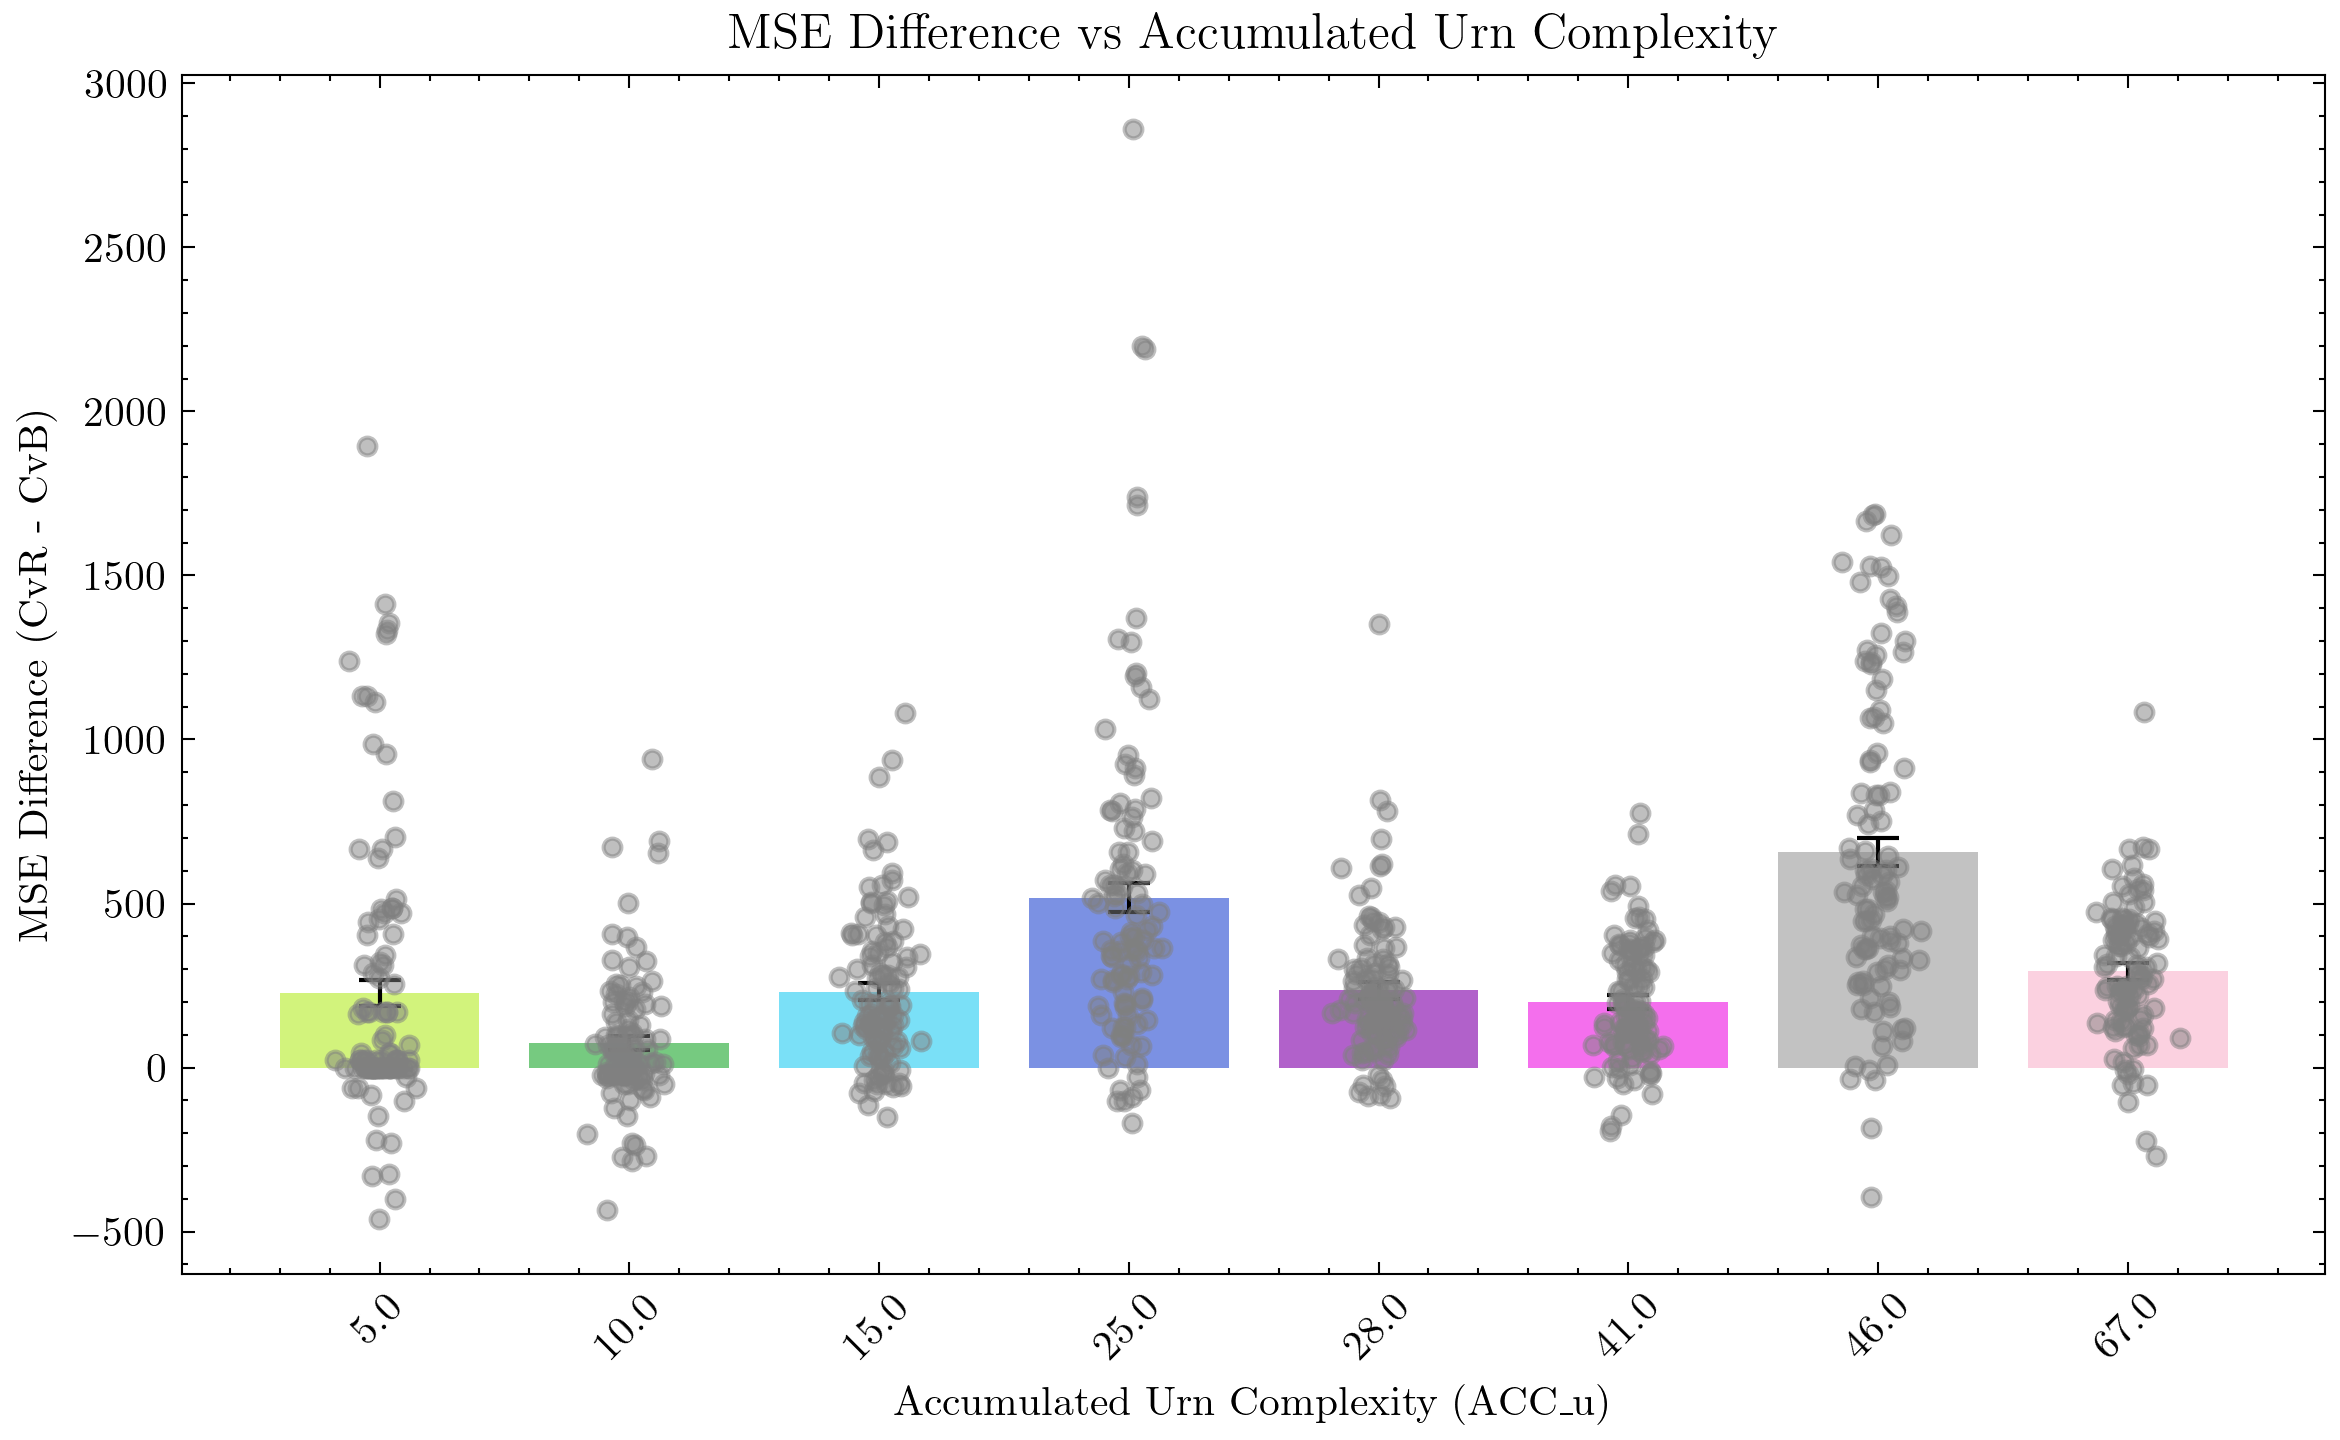

In [133]:
# Group data by ACC_u and calculate mean and standard error for MSE_hsi_diff_CvR_CvB
grouped = participant_data.groupby('ACC_u')['MSE_hsi_diff_CvR_CvB']
means = grouped.mean()
sems = grouped.sem()

# participant-level averages per ACC_u (one value per participant per ACC_u)
part_means = (
    participant_data
    .groupby(['participantID', 'ACC_u'])['MSE_hsi_diff_CvR_CvB']
    .mean()
    .reset_index()
)

with plt.style.context("science"):
    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    x = np.arange(len(means))
    bars = ax.bar(x, means, yerr=sems, capsize=5, color=COLORS[:len(means)], alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(means.index, rotation=45)
    ax.set_xlabel('Accumulated Urn Complexity (ACC_u)', fontweight='bold')
    ax.set_ylabel('MSE Difference (CvR - CvB)', fontweight='bold')
    ax.set_title('MSE Difference vs Accumulated Urn Complexity', fontweight='bold')

    # Add jittered grey dots for participant-level averages
    for i, acc in enumerate(means.index):
        vals = part_means.loc[part_means['ACC_u'] == acc, 'MSE_hsi_diff_CvR_CvB'].values
        if vals.size == 0:
            continue
        x_jitter = np.random.normal(loc=i, scale=jitter_scale, size=vals.size)
        ax.scatter(x_jitter, vals, color='grey', alpha=0.5, s=18, zorder=3)

    plt.tight_layout()
    plt.show()

In [134]:
# Frequentist linear mixed effect model with random effect = participant ID for now

model = mixedlm("MSE_hsi_diff_CvR_CvB ~ ACC_u", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MSE_hsi_diff_CvR_CvB
No. Observations: 3744    Method:             REML                
No. Groups:       104     Scale:              434487.0279         
Min. group size:  36      Log-Likelihood:     -29652.3277         
Max. group size:  36      Converged:          Yes                 
Mean group size:  36.0                                            
--------------------------------------------------------------------
              Coef.     Std.Err.     z     P>|z|    [0.025    0.975]
--------------------------------------------------------------------
Intercept     190.959     23.205   8.229   0.000   145.478   236.440
ACC_u           3.263      0.549   5.940   0.000     2.187     4.340
Group Var   15360.925      5.881                                    



## Compare the Information-computation gap of two tasks (MSE_hsi_RvB and MSE_ff_RvB)

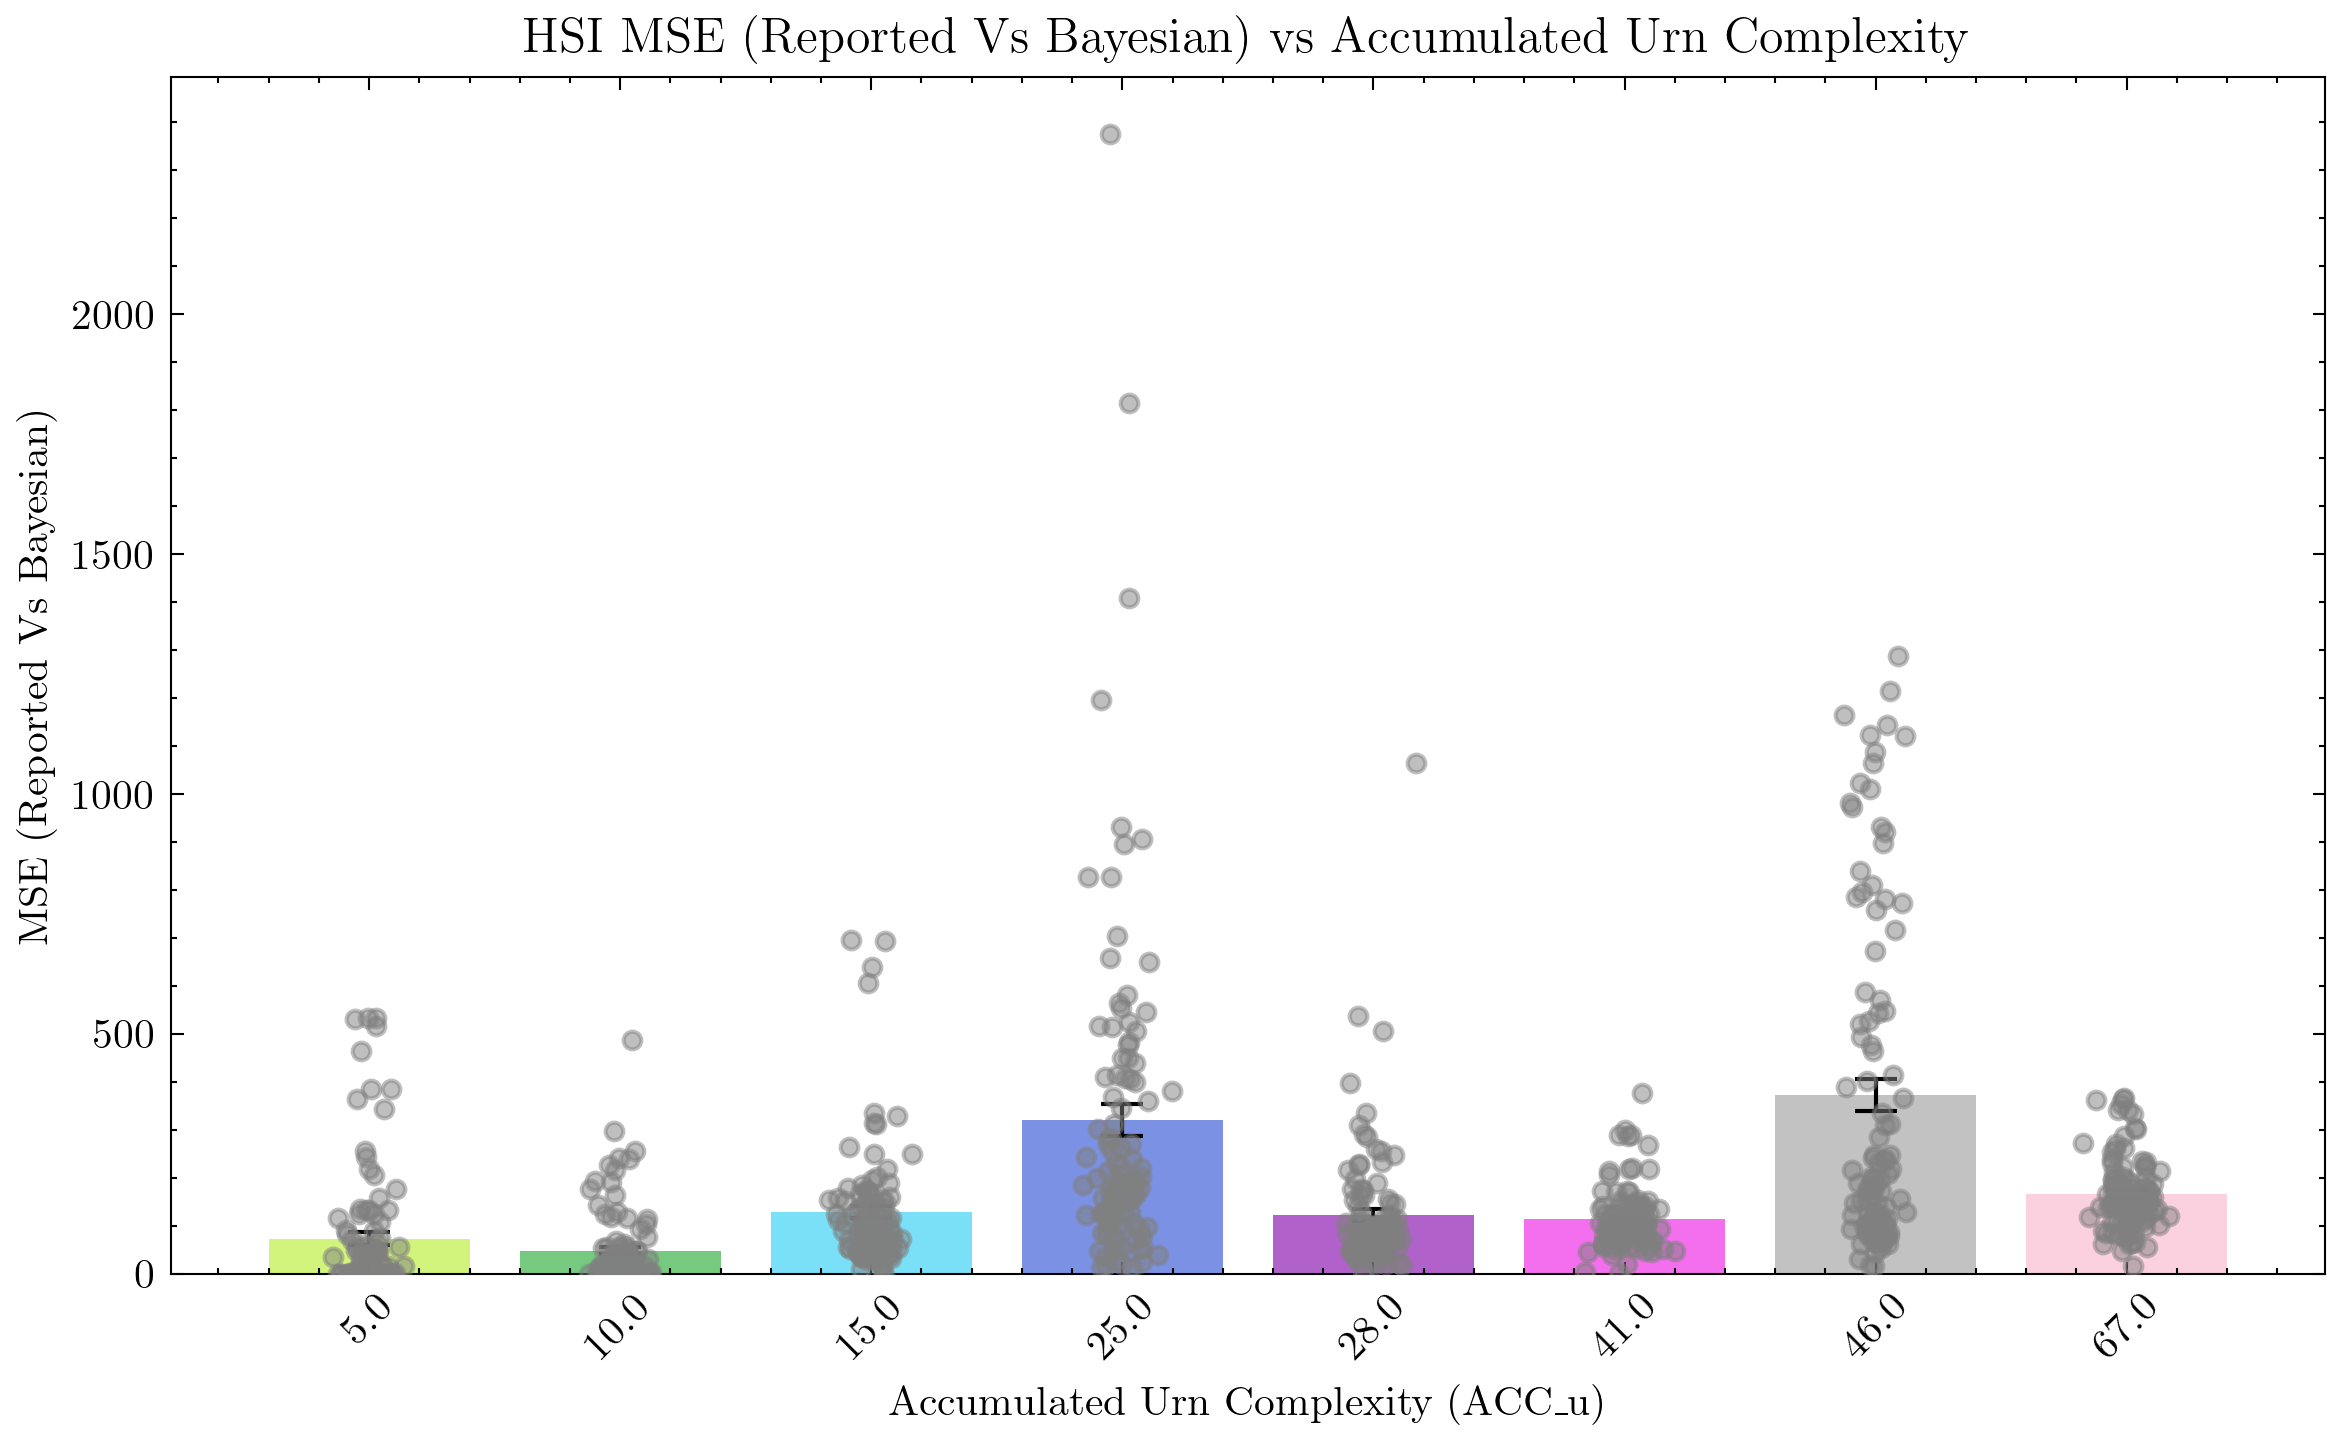

In [135]:
# Group data by ACC_u and calculate mean and standard error for MSE_hsi_RvB
grouped = participant_data.groupby('ACC_u')['MSE_hsi_RvB']
means = grouped.mean()
sems = grouped.sem()

# participant-level averages per ACC_u (one value per participant per ACC_u)
part_means = (
    participant_data
    .groupby(['participantID', 'ACC_u'])['MSE_hsi_RvB']
    .mean()
    .reset_index()
)

with plt.style.context("science"):
    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    x = np.arange(len(means))
    bars = ax.bar(x, means, yerr=sems, capsize=5, color=COLORS[:len(means)], alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(means.index, rotation=45)
    ax.set_xlabel('Accumulated Urn Complexity (ACC_u)', fontweight='bold')
    ax.set_ylabel('MSE (Reported Vs Bayesian)', fontweight='bold')
    ax.set_title('HSI MSE (Reported Vs Bayesian) vs Accumulated Urn Complexity', fontweight='bold')

    # Add jittered grey dots for participant-level averages
    for i, acc in enumerate(means.index):
        vals = part_means.loc[part_means['ACC_u'] == acc, 'MSE_hsi_RvB'].values
        if vals.size == 0:
            continue
        x_jitter = np.random.normal(loc=i, scale=jitter_scale, size=vals.size)
        ax.scatter(x_jitter, vals, color='grey', alpha=0.5, s=18, zorder=3)

    plt.tight_layout()
    plt.show()

In [136]:
# Frequentist linear mixed effect model with random effect = participant ID for now

model = mixedlm("MSE_hsi_RvB ~ ACC_u", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MSE_hsi_RvB
No. Observations: 3744    Method:             REML       
No. Groups:       104     Scale:              135255.1939
Min. group size:  36      Log-Likelihood:     -27468.2711
Max. group size:  36      Converged:          Yes        
Mean group size:  36.0                                   
---------------------------------------------------------
              Coef.   Std.Err.   z   P>|z| [0.025  0.975]
---------------------------------------------------------
Intercept      97.436   12.911 7.547 0.000 72.132 122.741
ACC_u           2.111    0.307 6.885 0.000  1.510   2.711
Group Var    4683.848    3.243                           



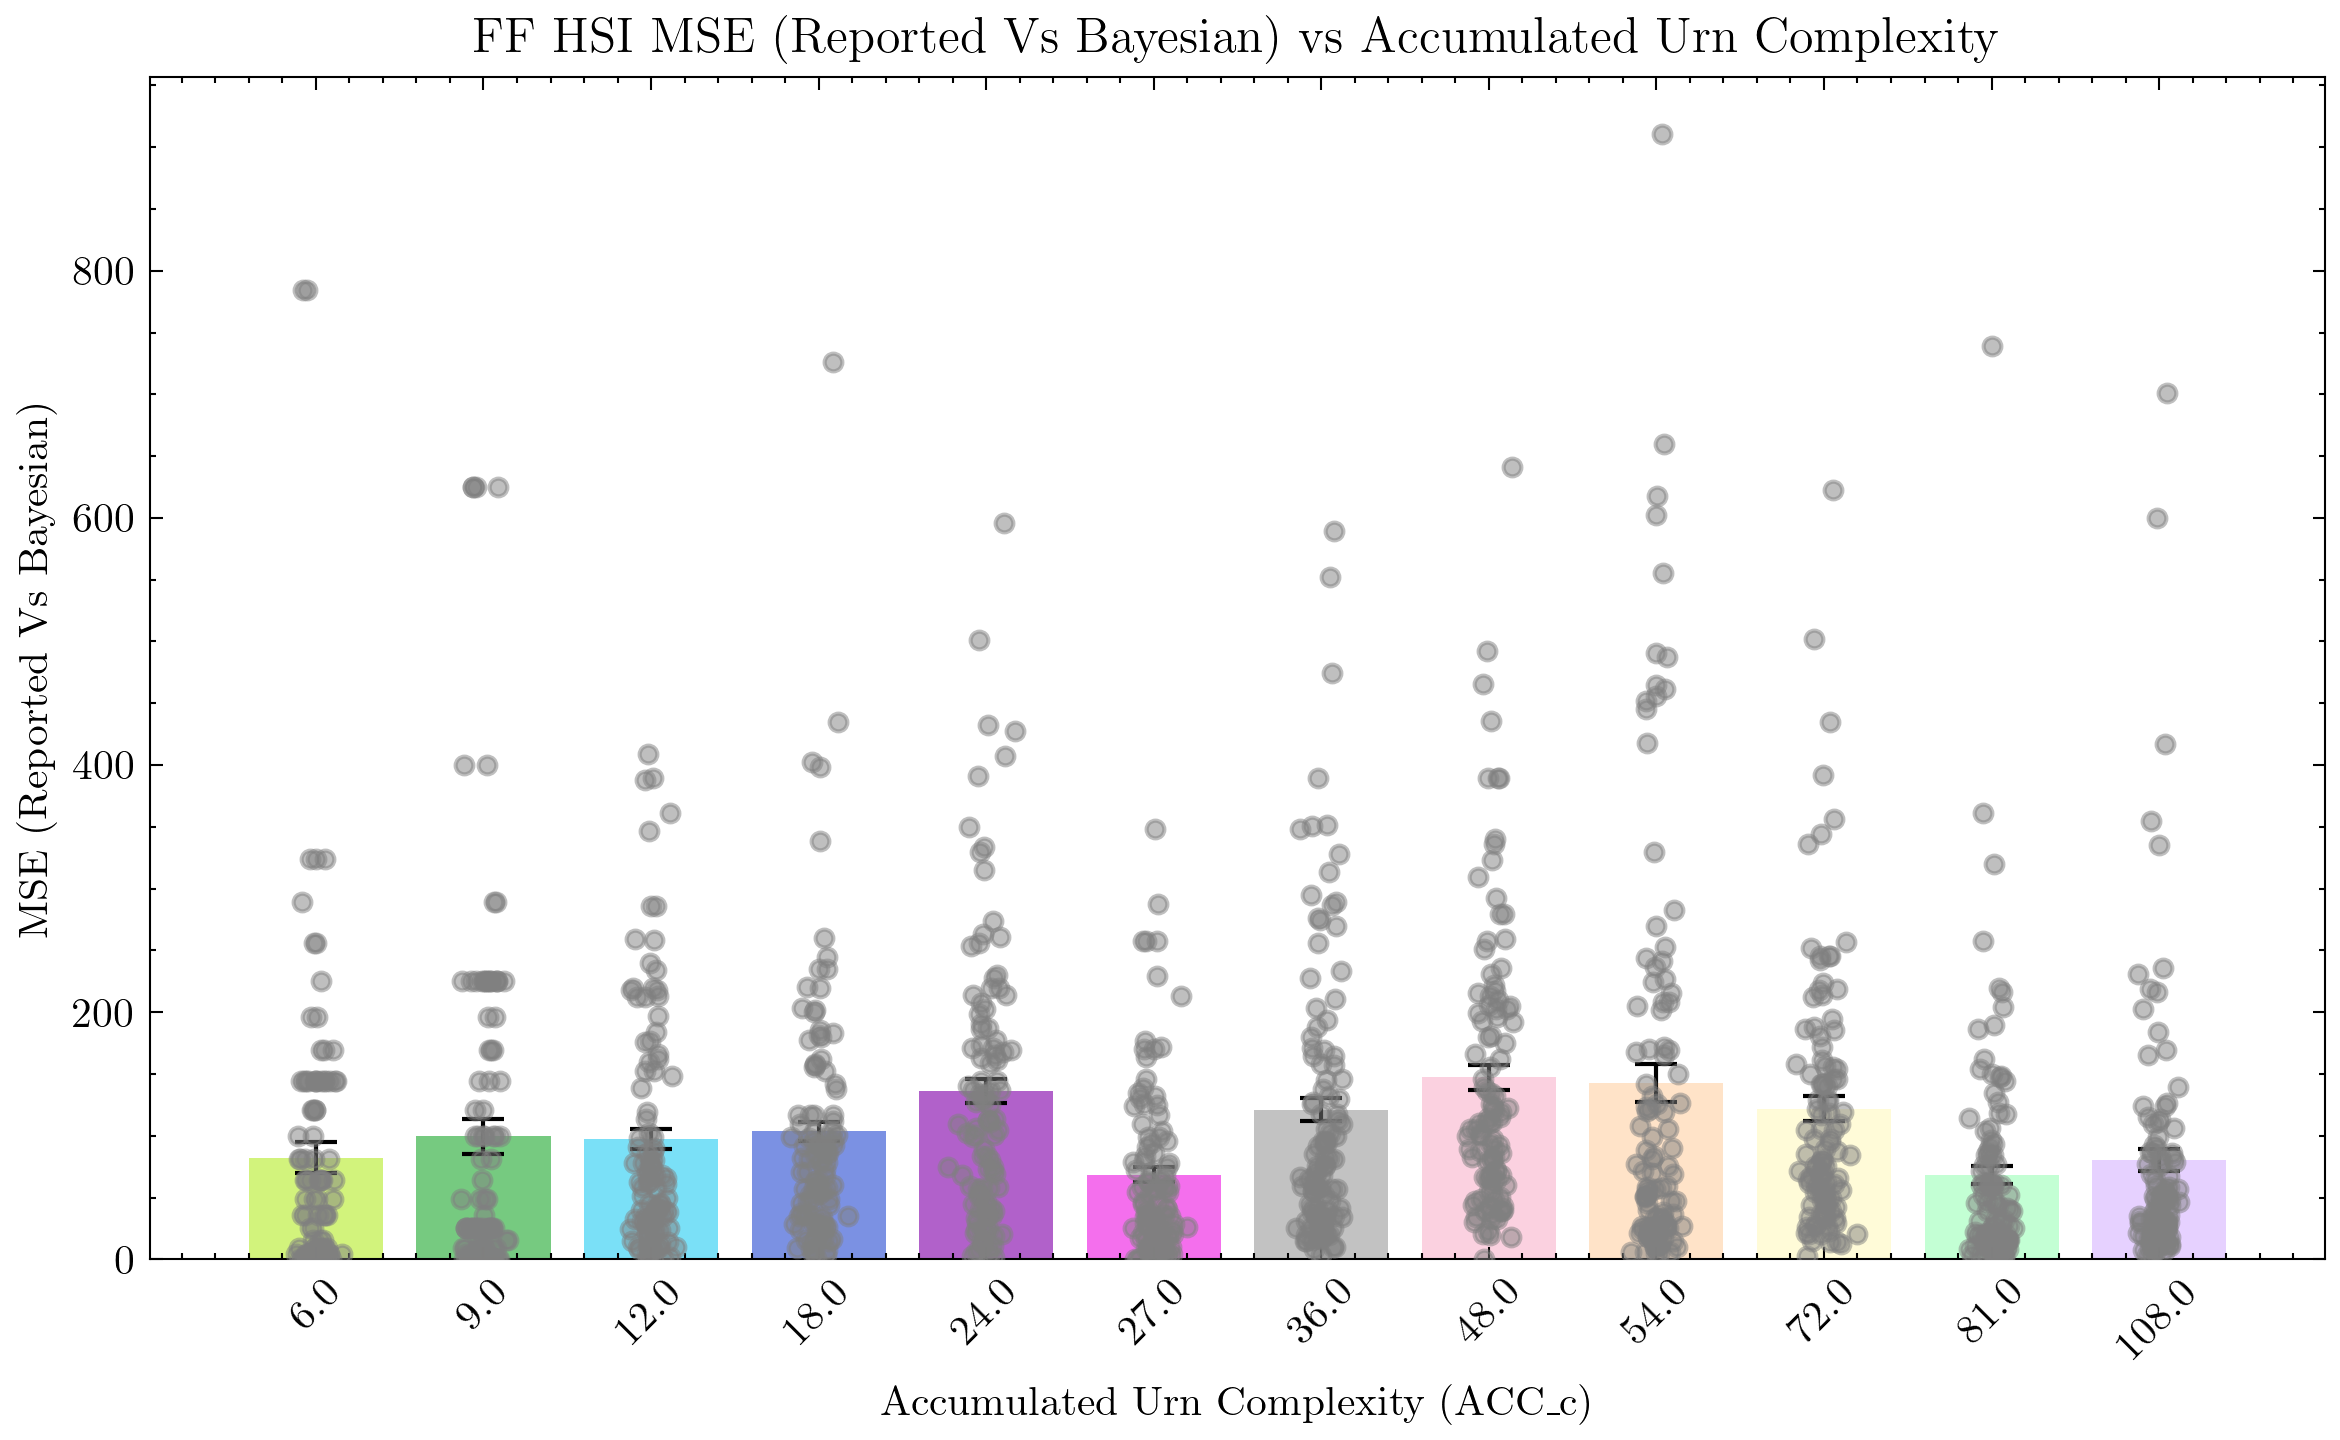

In [137]:
# Group data by ACC_c and calculate mean and standard error for MSE_ff_RvB
grouped = participant_data.groupby('ACC_c')['MSE_ff_RvB']
means = grouped.mean()
sems = grouped.sem()

# participant-level averages per ACC_c (one value per participant per ACC_c)
part_means = (
    participant_data
    .groupby(['participantID', 'ACC_c'])['MSE_ff_RvB']
    .mean()
    .reset_index()
)

with plt.style.context("science"):
    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    x = np.arange(len(means))
    bars = ax.bar(x, means, yerr=sems, capsize=5, color=COLORS[:len(means)], alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(means.index, rotation=45)
    ax.set_xlabel('Accumulated Urn Complexity (ACC_c)', fontweight='bold')
    ax.set_ylabel('MSE (Reported Vs Bayesian)', fontweight='bold')
    ax.set_title('FF HSI MSE (Reported Vs Bayesian) vs Accumulated Urn Complexity', fontweight='bold')

    # Add jittered grey dots for participant-level averages
    for i, acc in enumerate(means.index):
        vals = part_means.loc[part_means['ACC_c'] == acc, 'MSE_ff_RvB'].values
        if vals.size == 0:
            continue
        x_jitter = np.random.normal(loc=i, scale=jitter_scale, size=vals.size)
        ax.scatter(x_jitter, vals, color='grey', alpha=0.5, s=18, zorder=3)

    plt.tight_layout()
    plt.show()

In [138]:
# Frequentist linear mixed effect model with random effect = participant ID for now

model = mixedlm("MSE_ff_RvB ~ ACC_c", participant_data, groups=participant_data["participantID"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zhongyux/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MSE_ff_RvB 
No. Observations: 3744    Method:             REML       
No. Groups:       104     Scale:              32043.9527 
Min. group size:  36      Log-Likelihood:     -24848.1724
Max. group size:  36      Converged:          Yes        
Mean group size:  36.0                                   
---------------------------------------------------------
             Coef.   Std.Err.   z    P>|z| [0.025  0.975]
---------------------------------------------------------
Intercept    113.177   10.078 11.230 0.000 93.425 132.929
ACC_c         -0.040    0.110 -0.367 0.714 -0.255   0.175
Group Var   7513.883    7.459                            



## Plot Correlation between the change in the JSD between prior and posteriors from the first second third ball draw and the number of computations. Change in posterior from ball draw to ball draw, how it correlates with complexity

In [139]:
participant_data

participantID  instanceName  seqBall  responseTimeUrn  \
0                 1             1        1            22.43   
1                 1             1        2            10.50   
2                 1             1        3             7.27   
3                 2             1        1            13.30   
4                 2             1        2            11.68   
...             ...           ...      ...              ...   
3739            117            18        2            34.62   
3740            117            18        3            79.35   
3741            118            18        1            30.47   
3742            118            18        2            26.90   
3743            118            18        3            68.98   

      responseTimeColour  age     sex probSubject bayesFamaliar  \
0                  11.40   18  Female          No           Yes   
1                  10.10   18  Female          No           Yes   
2                  13.47   18  Female          No           Yes   
3                  20.47   31  Female          No            No   
4                  37.35   31  Female          No            No   
...                  ...  ...     ...         ...           ...   
3739               46.30   32  Female          No            No   
3740               47.35   32  Female          No            No   
3741              147.07   20  Female         Yes           Yes   
3742               33.02   20  Female         Yes           Yes   
3743              145.42   20  Female         Yes           Yes   

          bayesInExp  uA_r  uB_r  cB_r  cW_r  cP_r  cG_r  uC_r  uD_r  urns  \
0              Never 30.00 70.00 45.00 55.00   NaN   NaN   NaN   NaN     2   
1              Never 70.00 30.00 55.00 45.00   NaN   NaN   NaN   NaN     2   
2              Never 30.00 70.00 45.00 55.00   NaN   NaN   NaN   NaN     2   
3              Never 30.00 70.00 33.00 67.00   NaN   NaN   NaN   NaN     2   
4              Never 40.00 60.00 22.00 78.00   NaN   NaN   NaN   NaN     2   
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3739  Not Applicable  9.00 16.00 14.00 24.00 31.00 31.00 38.00 37.00     4   
3740  Not Applicable 16.00 15.00 13.00 19.00 34.00 34.00 41.00 28.00     4   
3741       Sometimes 10.00 20.00 10.00 15.00 35.00 40.00 30.00 40.00     4   
3742       Sometimes 10.00 10.00 10.00 10.00 40.00 40.00 40.00 40.00     4   
3743       Sometimes 12.00  8.00 17.00 14.00 36.00 33.00 45.00 35.00     4   

      colours  uA_c  uB_c  cB_c  cW_c  cP_c  cG_c  uC_c  uD_c  uA_s  uB_s  \
0           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 30.00 70.00   
1           2 50.00 50.00 50.00 50.00   NaN   NaN   NaN   NaN 50.00 50.00   
2           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 50.00 50.00   
3           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 30.00 70.00   
4           2 50.00 50.00 50.00 50.00   NaN   NaN   NaN   NaN 50.00 50.00   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3739        4  7.00  7.00 18.00 18.00 32.00 32.00 43.00 43.00  7.00  7.00   
3740        4  4.00  2.00 17.00 15.00 34.00 33.00 53.00 40.00  6.00  5.00   
3741        4 10.00 20.00 20.00 22.00 28.00 30.00 30.00 40.00 10.00 20.00   
3742        4  7.00  7.00 18.00 18.00 32.00 32.00 43.00 43.00  7.00  7.00   
3743        4  4.00  2.00 17.00 15.00 34.00 33.00 53.00 40.00  6.00  3.00   

      uC_s  uD_s  cB_s  cW_s  cP_s  cG_s  diff_uA  diff_uB  diff_uC  diff_uD  \
0      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
1      NaN   NaN 58.00 42.00   NaN   NaN    20.00    20.00      NaN      NaN   
2      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
3      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
4      NaN   NaN 46.00 54.00   NaN   NaN    10.00    10.00      NaN      NaN   
...    ...   ...   ...   ...   ...   ...      ...      ...      ...      ...   
3739 43.00 43.00 20.00

### Create (Bayesian) prior distribution

In [140]:
def calculate_prior_urn(row):
    if row['seqBall'] == 1 and row['urns']==2:
        prior_uA, prior_uB =  1/2, 1/2
        prior_uC, prior_uD =  np.nan, np.nan
    elif row['seqBall'] == 1 and row['urns']==3:
        prior_uA, prior_uB, prior_uC =  1/3, 1/3, 1/3
        prior_uD = np.nan
    elif row['seqBall'] == 1 and row['urns']==4:
        prior_uA, prior_uB, prior_uC, prior_uD =  1/4, 1/4, 1/4, 1/4
    else:
        prior_uA = row['uA_c-1'] 
        prior_uB = row['uB_c-1']
        prior_uC = row['uC_c-1']
        prior_uD = row['uD_c-1']

    return prior_uA, prior_uB, prior_uC, prior_uD

def calculate_prior_color(row):
    if row['seqBall'] == 1 and row['colours']==2:
        prior_cB, prior_cW =  100 * row['totalBalls_B'] / row['totalBalls'], 100 * row['totalBalls_W'] / row['totalBalls']
        prior_cP, prior_cG =  np.nan, np.nan
    elif row['seqBall'] == 1 and row['colours']==3:
        prior_cB, prior_cW, prior_cP =  100 * row['totalBalls_B'] / row['totalBalls'], 100 * row['totalBalls_W'] / row['totalBalls'], 100 * row['totalBalls_P'] / row['totalBalls']
        prior_cG = np.nan
    elif row['seqBall'] == 1 and row['colours']==4:
        prior_cB, prior_cW, prior_cP, prior_cG =  100 * row['totalBalls_B'] / row['totalBalls'], 100 * row['totalBalls_W'] / row['totalBalls'], 100 * row['totalBalls_P'] / row['totalBalls'], 100 * row['totalBalls_G'] / row['totalBalls']
    else:
        prior_cB = row['cB_c-1'] 
        prior_cW = row['cW_c-1']
        prior_cP = row['cP_c-1']
        prior_cG = row['cG_c-1']

    return prior_cB, prior_cW, prior_cP, prior_cG


participant_data['uA_c-1'] = participant_data['uA_c'].shift(1)
participant_data['uB_c-1'] = participant_data['uB_c'].shift(1)
participant_data['uC_c-1'] = participant_data['uC_c'].shift(1)
participant_data['uD_c-1'] = participant_data['uD_c'].shift(1)
participant_data['cB_c-1'] = participant_data['cB_c'].shift(1)
participant_data['cW_c-1'] = participant_data['cW_c'].shift(1)
participant_data['cP_c-1'] = participant_data['cP_c'].shift(1)
participant_data['cG_c-1'] = participant_data['cG_c'].shift(1)


# apply and expand the returned tuple into four columns
priors_df_urn = participant_data.apply(
    lambda row: pd.Series(calculate_prior_urn(row), index=['prior_uA', 'prior_uB', 'prior_uC', 'prior_uD']),
    axis=1
)
participant_data[['prior_uA', 'prior_uB', 'prior_uC', 'prior_uD']] = priors_df_urn

priors_df_col = participant_data.apply(
    lambda row: pd.Series(calculate_prior_color(row), index=['prior_cB', 'prior_cW', 'prior_cP', 'prior_cG']),
    axis=1
)
participant_data[['prior_cB', 'prior_cW', 'prior_cP', 'prior_cG']] = priors_df_col



participant_data.drop(columns=['uA_c-1', 'uB_c-1', 'uC_c-1', 'uD_c-1', 'cB_c-1', 'cW_c-1', 'cP_c-1', 'cG_c-1'], inplace=True)

In [141]:
participant_data[['instanceName','seqBall','prior_cB', 'cB_c','prior_cW','cW_c', 'prior_cP','cP_c', 'prior_cG','cG_c']]

instanceName  seqBall  prior_cB  cB_c  prior_cW  cW_c  prior_cP  cP_c  \
0                1        1     50.00 42.00     50.00 58.00       NaN   NaN   
1                1        2     42.00 50.00     58.00 50.00       NaN   NaN   
2                1        3     50.00 42.00     50.00 58.00       NaN   NaN   
3                1        1     50.00 42.00     50.00 58.00       NaN   NaN   
4                1        2     42.00 50.00     58.00 50.00       NaN   NaN   
...            ...      ...       ...   ...       ...   ...       ...   ...   
3739            18        2     20.00 18.00     22.00 18.00     28.00 32.00   
3740            18        3     18.00 17.00     18.00 15.00     32.00 34.00   
3741            18        1     25.00 20.00     25.00 22.00     25.00 28.00   
3742            18        2     20.00 18.00     22.00 18.00     28.00 32.00   
3743            18        3     18.00 17.00     18.00 15.00     32.00 34.00   

      prior_cG  cG_c  
0          NaN   NaN  
1          NaN   NaN  
2          NaN   NaN  
3          NaN   NaN  
4          NaN   NaN  
...        ...   ...  
3739     30.00 32.00  
3740     32.00 33.00  
3741     25.00 30.00  
3742     30.00 32.00  
3743     32.00 33.00  

[3744 rows x 10 columns]

### Create JSD between prior and posterior for each ball draw

In [142]:
def JSD(row, lis1, lis2):
    vec1 = row[lis1].to_numpy(dtype=float)
    vec2 = row[lis2].to_numpy(dtype=float)
    vec1 = np.nan_to_num(vec1)
    vec2 = np.nan_to_num(vec2)
    return jensenshannon(vec1, vec2, base=2)

participant_data['JSD_U_priorVpos'] = participant_data.apply(lambda x: JSD(x, ['uA_c', 'uB_c', 'uC_c', 'uD_c'], ['prior_uA', 'prior_uB', 'prior_uC', 'prior_uD']), axis=1)
participant_data['JSD_C_priorVpos'] = participant_data.apply(lambda x: JSD(x, ['cB_c', 'cW_c', 'cP_c', 'cG_c'], ['prior_cB', 'prior_cW', 'prior_cP', 'prior_cG']), axis=1)

In [143]:
participant_data[['JSD_U_priorVpos','CC_u']]

JSD_U_priorVpos  CC_u
0                0.17  5.00
1                0.17 10.00
2                0.17 10.00
3                0.17  5.00
4                0.17 10.00
...               ...   ...
3739             0.19 26.00
3740             0.13 26.00
3741             0.20 15.00
3742             0.19 26.00
3743             0.13 26.00

[3744 rows x 2 columns]

### Report Pearson Correlation between JSD_priorVpos and step-wise CC

Overall Pearson correlations:
Urn JSD_priorVpos vs step-wise CC_u:  n=3744, r = 0.207, p = 1.95e-37
Colour JSD_priorVpos vs step-wise CC_c:  n=3744, r = 0.038, p = 0.0215

By seqBall:

seqBall = 1:
  Urn: r = 0.442, p = 9.67e-61, n = 1248
  Colour: r = 0.077, p = 0.0068, n = 1248

seqBall = 2:
  Urn: r = 0.176, p = 3.83e-10, n = 1248
  Colour: r = 0.008, p = 0.79, n = 1248

seqBall = 3:
  Urn: r = 0.398, p = 1.29e-48, n = 1248
  Colour: r = 0.034, p = 0.224, n = 1248


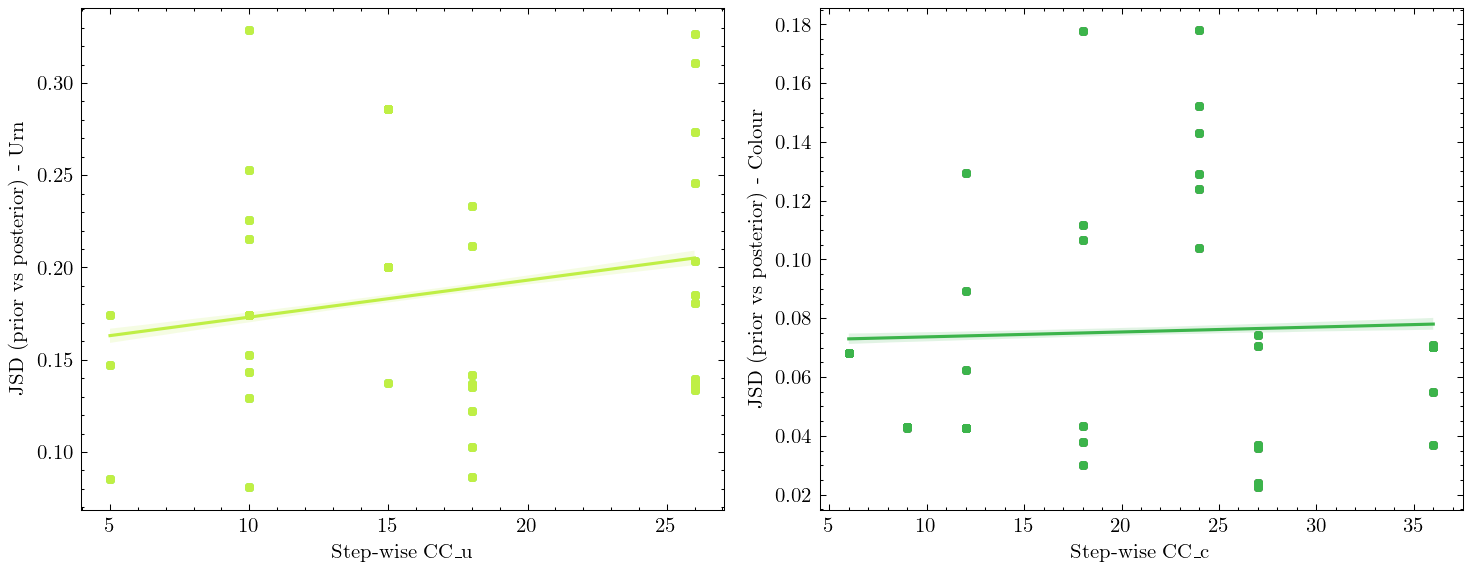

In [144]:
from scipy.stats import pearsonr

def report_corr(x, y, label):
    valid = participant_data[[x, y]].dropna()
    if len(valid) < 2:
        print(f"{label}: not enough data")
        return None
    r, p = pearsonr(valid[x], valid[y])
    print(f"{label}:  n={len(valid)}, r = {r:.3f}, p = {p:.3g}")
    return r, p

# Overall correlations
print("Overall Pearson correlations:")
report_corr('JSD_U_priorVpos', 'CC_u', 'Urn JSD_priorVpos vs step-wise CC_u')
report_corr('JSD_C_priorVpos', 'CC_c', 'Colour JSD_priorVpos vs step-wise CC_c')

# Correlations by draw (seqBall)
print("\nBy seqBall:")
for s in sorted(participant_data['seqBall'].unique()):
    df_s = participant_data[participant_data['seqBall'] == s]
    print(f"\nseqBall = {s}:")
    valid_u = df_s[['JSD_U_priorVpos', 'CC_u']].dropna()
    valid_c = df_s[['JSD_C_priorVpos', 'CC_c']].dropna()
    if len(valid_u) >= 2:
        r_u, p_u = pearsonr(valid_u['JSD_U_priorVpos'], valid_u['CC_u'])
        print(f"  Urn: r = {r_u:.3f}, p = {p_u:.3g}, n = {len(valid_u)}")
    else:
        print("  Urn: not enough data")
    if len(valid_c) >= 2:
        r_c, p_c = pearsonr(valid_c['JSD_C_priorVpos'], valid_c['CC_c'])
        print(f"  Colour: r = {r_c:.3f}, p = {p_c:.3g}, n = {len(valid_c)}")
    else:
        print("  Colour: not enough data")

# Quick scatter plots for visualization (overall)
with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
    sns.regplot(x='CC_u', y='JSD_U_priorVpos', data=participant_data, scatter_kws={'s':10, 'alpha':0.5}, ax=axes[0], color=COLORS[0])
    axes[0].set_xlabel('Step-wise CC_u')
    axes[0].set_ylabel('JSD (prior vs posterior) - Urn')
    sns.regplot(x='CC_c', y='JSD_C_priorVpos', data=participant_data, scatter_kws={'s':10, 'alpha':0.5}, ax=axes[1], color=COLORS[1])
    axes[1].set_xlabel('Step-wise CC_c')
    axes[1].set_ylabel('JSD (prior vs posterior) - Colour')
    fig.tight_layout()
    fig.savefig("images/JSD_priorPos_CC_scatter.png")
    plt.show()

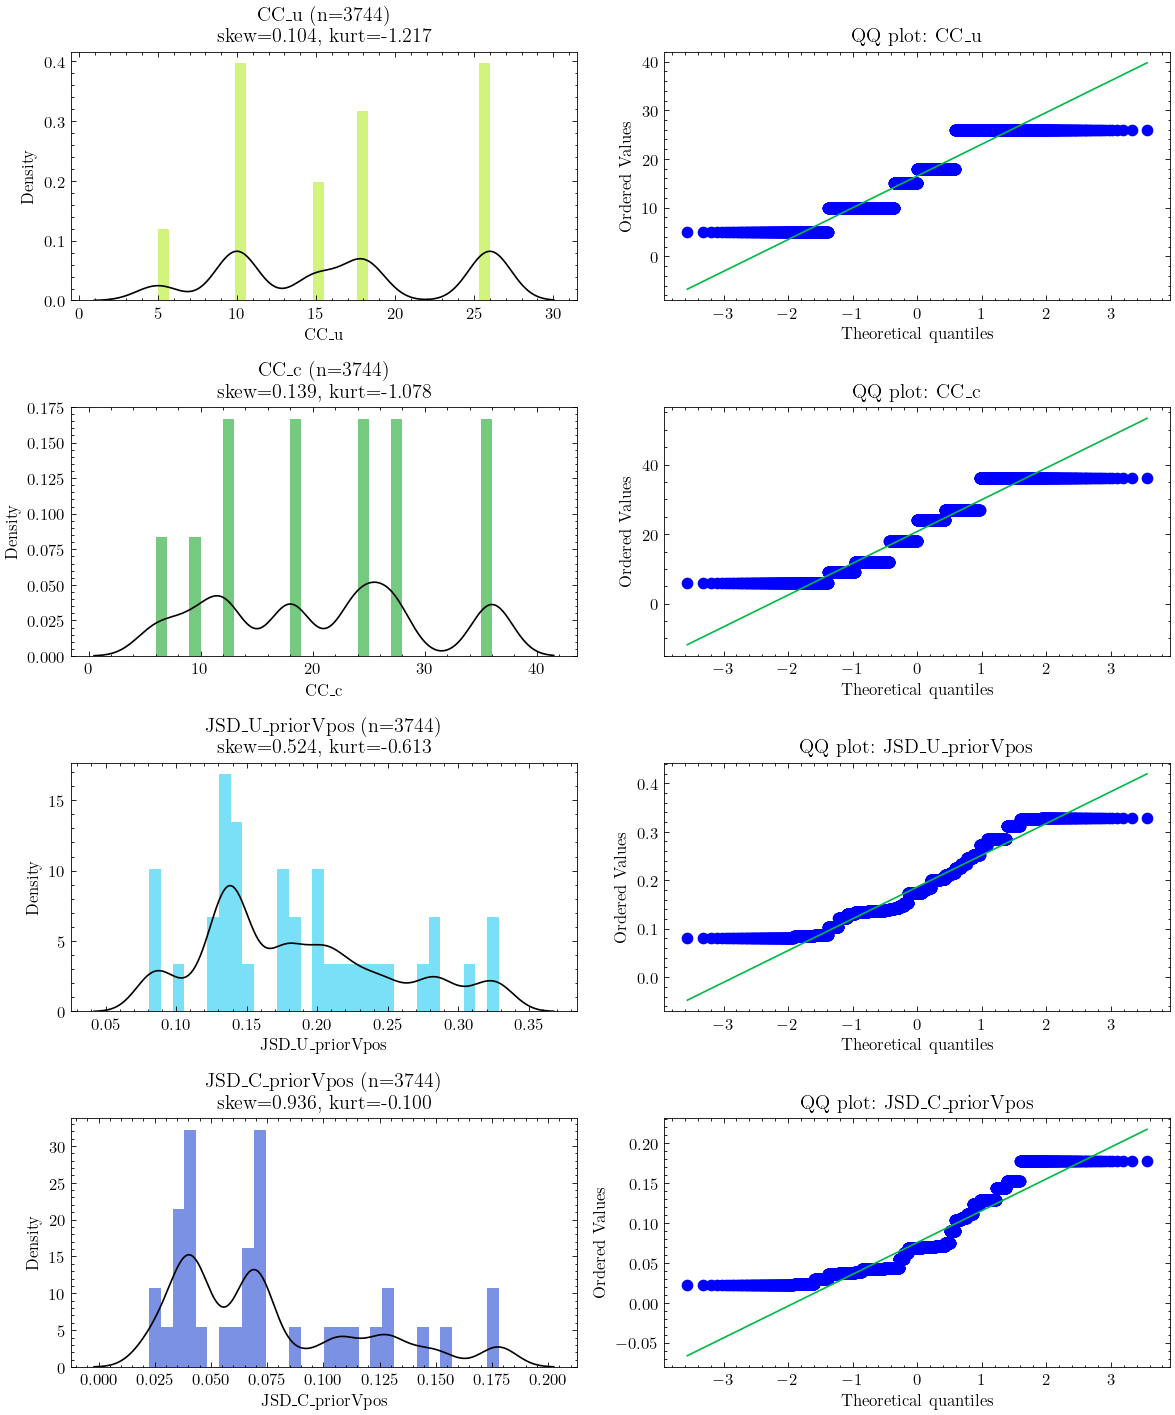

variable     n  shapiro_stat  shapiro_p  dagostino_stat  \
0             CC_u  3744          0.87       0.00         3699.06   
1             CC_c  3744          0.92       0.00         1323.17   
2  JSD_U_priorVpos  3744          0.94       0.00          280.60   
3  JSD_C_priorVpos  3744          0.88       0.00          404.10   

   dagostino_p  anderson_stat  \
0         0.00         175.53   
1         0.00          96.33   
2         0.00          71.36   
3         0.00         160.61   

                                       anderson_crit  skewness  kurtosis  
0  15.0%:0.575; 10.0%:0.655; 5.0%:0.786; 2.5%:0.9...      0.10     -1.22  
1  15.0%:0.575; 10.0%:0.655; 5.0%:0.786; 2.5%:0.9...      0.14     -1.08  
2  15.0%:0.575; 10.0%:0.655; 5.0%:0.786; 2.5%:0.9...      0.52     -0.61  
3  15.0%:0.575; 10.0%:0.655; 5.0%:0.786; 2.5%:0.9...      0.94     -0.10

In [145]:
# Normality tests and diagnostic plots for selected variables
cols = ['CC_u', 'CC_c', 'JSD_U_priorVpos', 'JSD_C_priorVpos']

results = []
with plt.style.context("science"):
    fig, axes = plt.subplots(len(cols), 2, figsize=(10, 3 * len(cols)), dpi=120)

    for i, col in enumerate(cols):
        series = participant_data[col].dropna().astype(float)

        n = len(series)
        # Shapiro-Wilk (sensitive for n <= ~5000)
        try:
            sh_stat, sh_p = stats.shapiro(series)
        except Exception as e:
            sh_stat, sh_p = (np.nan, np.nan)

        # D'Agostino K^2 / omnibus normality test
        try:
            k2_stat, k2_p = stats.normaltest(series)
        except Exception as e:
            k2_stat, k2_p = (np.nan, np.nan)

        # Anderson-Darling
        try:
            ad_res = stats.anderson(series, dist='norm')
            ad_stat = ad_res.statistic
            ad_crit = dict(zip(ad_res.significance_level, ad_res.critical_values))
        except Exception as e:
            ad_stat, ad_crit = (np.nan, {})

        results.append({
            'variable': col,
            'n': n,
            'shapiro_stat': sh_stat, 'shapiro_p': sh_p,
            'dagostino_stat': k2_stat, 'dagostino_p': k2_p,
            'anderson_stat': ad_stat, 'anderson_crit': ad_crit,
            'skewness': series.skew(), 'kurtosis': series.kurtosis()
        })

        # Histogram + KDE
        ax_h = axes[i, 0]
        ax_h.hist(series, bins=30, density=True, color=COLORS[i % len(COLORS)], alpha=0.7)
        try:
            sns.kdeplot(series, ax=ax_h, color='k', lw=1)
        except Exception:
            pass
        ax_h.set_title(f"{col}  (n={n})\nskew={series.skew():.3f}, kurt={series.kurtosis():.3f}")
        ax_h.set_xlabel(col)

        # QQ-plot
        ax_qq = axes[i, 1]
        stats.probplot(series, dist='norm', plot=ax_qq)
        ax_qq.get_lines()[1].set_color('C1')  # line color
        ax_qq.set_title(f"QQ plot: {col}")

    plt.tight_layout()
    plt.show()

# Summarize test results in a DataFrame for easy inspection
res_df = pd.DataFrame(results)
# show the Anderson critical values as strings for readability
res_df['anderson_crit'] = res_df['anderson_crit'].apply(lambda d: "; ".join([f"{k}%:{v:.3f}" for k, v in d.items()]) if isinstance(d, dict) else "")
display(res_df[['variable','n','shapiro_stat','shapiro_p','dagostino_stat','dagostino_p','anderson_stat','anderson_crit','skewness','kurtosis']])

### Since none of the variables are normally distributed, use non-parametric test instead

In [146]:
from scipy.stats import spearmanr

# Drop NaN values for the two columns
valid_data = participant_data[['CC_u', 'JSD_U_priorVpos']].dropna()

# Perform Spearman's Rank Correlation test
spearman_corr, spearman_pval = spearmanr(valid_data['CC_u'], valid_data['JSD_U_priorVpos'])

# Print the results
print(f"Spearman's Rank Correlation for 'CC_u', 'JSD_U_priorVpos': {spearman_corr:.3f}")
print(f"P-value: {spearman_pval:.3g}")


# Drop NaN values for the two columns
valid_data = participant_data[['CC_c', 'JSD_C_priorVpos']].dropna()

# Perform Spearman's Rank Correlation test
spearman_corr, spearman_pval = spearmanr(valid_data['CC_c'], valid_data['JSD_C_priorVpos'])

# Print the results
print(f"Spearman's Rank Correlation for 'CC_c', 'JSD_C_priorVpos': {spearman_corr:.3f}")
print(f"P-value: {spearman_pval:.3g}")

Spearman's Rank Correlation for 'CC_u', 'JSD_U_priorVpos': 0.125
P-value: 2.01e-14
Spearman's Rank Correlation for 'CC_c', 'JSD_C_priorVpos': 0.028
P-value: 0.0916


In [147]:
pairs = [
    ('CC_u', 'JSD_U_priorVpos', 'Hidden-state Inference'),
    ('CC_c', 'JSD_C_priorVpos', 'Future Forecasting')
]

for x_col, y_col, label in pairs:
    print(f"\nSpearman correlations by seqBall for {label} ({x_col} vs {y_col}):")
    for s in sorted(participant_data['seqBall'].unique()):
        sub = participant_data.loc[participant_data['seqBall'] == s, [x_col, y_col]].dropna()
        n = len(sub)
        if n < 2:
            print(f" seqBall={s}: n={n} (insufficient data)")
            continue
        rho, pval = spearmanr(sub[x_col], sub[y_col])
        print(f" seqBall={s}: n={n}, rho={rho:.3f}, p = {pval:.3g}")


for x_col, y_col, label in pairs:
    print(f"\nSpearman correlations by #urns for {label} ({x_col} vs {y_col}):")
    for s in sorted(participant_data['urns'].unique()):
        sub = participant_data.loc[participant_data['urns'] == s, [x_col, y_col]].dropna()
        n = len(sub)
        if n < 2:
            print(f" urns={s}: n={n} (insufficient data)")
            continue
        rho, pval = spearmanr(sub[x_col], sub[y_col])
        print(f" urns={s}: n={n}, rho={rho:.3f}, p = {pval:.3g}")


for x_col, y_col, label in pairs:
    print(f"\nSpearman correlations by #colours for {label} ({x_col} vs {y_col}):")
    for s in sorted(participant_data['colours'].unique()):
        sub = participant_data.loc[participant_data['colours'] == s, [x_col, y_col]].dropna()
        n = len(sub)
        if n < 2:
            print(f" colours={s}: n={n} (insufficient data)")
            continue
        rho, pval = spearmanr(sub[x_col], sub[y_col])
        print(f" colours={s}: n={n}, rho={rho:.3f}, p = {pval:.3g}")


Spearman correlations by seqBall for Hidden-state Inference (CC_u vs JSD_U_priorVpos):
 seqBall=1: n=1248, rho=0.388, p = 3.99e-46
 seqBall=2: n=1248, rho=0.052, p = 0.0655
 seqBall=3: n=1248, rho=0.339, p = 6.28e-35

Spearman correlations by seqBall for Future Forecasting (CC_c vs JSD_C_priorVpos):
 seqBall=1: n=1248, rho=0.129, p = 4.67e-06
 seqBall=2: n=1248, rho=0.021, p = 0.455
 seqBall=3: n=1248, rho=-0.138, p = 1.07e-06

Spearman correlations by #urns for Hidden-state Inference (CC_u vs JSD_U_priorVpos):
 urns=2: n=936, rho=0.464, p = 3.3e-51
 urns=3: n=1248, rho=-0.256, p = 3.93e-20
 urns=4: n=1560, rho=-0.098, p = 0.000101

Spearman correlations by #urns for Future Forecasting (CC_c vs JSD_C_priorVpos):
 urns=2: n=936, rho=-0.214, p = 3.39e-11
 urns=3: n=1248, rho=-0.308, p = 8.58e-29
 urns=4: n=1560, rho=-0.017, p = 0.494

Spearman correlations by #colours for Hidden-state Inference (CC_u vs JSD_U_priorVpos):
 colours=2: n=936, rho=-0.757, p = 1.77e-174
 colours=3: n=1248, r

# Investigate ball draw sequence effect on Decision quality and Response Time 

## Add the ball draw sequence to participant data csv

In [148]:
def read_participant_instanceSeq(filePath, min_pID, max_pID):
    """
    Reads participant instance sequence files and returns a dict mapping pID -> list of non-empty lines
    from the corresponding p{pID}_instanceSequence.txt file.
    Files not found are skipped.
    """
    import os

    participant_texts = {}

    for pID in range(min_pID, max_pID + 1):
        fname = os.path.join(filePath, f'participantData{pID}', f'p{pID}_instanceSequence.txt')
        try:
            with open(fname, 'r', encoding='utf-8') as f:
                txt = f.read()
        except FileNotFoundError:
            continue

        # split into non-empty stripped lines
        lines = [int(ln.strip())-6 for ln in txt.splitlines() if ln.strip() != ""]
        participant_texts[pID] = lines[6:18]  

    return participant_texts



### Map insSeq to instance Name given in insList

In [149]:
from itertools import islice

# Read participant data from json
min_pID = 1
max_pID = 118

filePath = '../participantData/'

insSeq = read_participant_instanceSeq(filePath, min_pID, max_pID)
print(insSeq[1])

insList = [1,3,5,7,9,11,12,13,15,16,17,18]
# map original indices (1,2,3,...) to the desired insList values (1,3,5,7,...)
map_dict = {i + 1: val for i, val in enumerate(insList)}

# apply mapping to insSeq (handle dict or list)
if isinstance(insSeq, dict):
    insSeq = {pid: [map_dict.get(item, item) for item in seq] for pid, seq in insSeq.items()}
elif isinstance(insSeq, list):
    insSeq = [[map_dict.get(item, item) for item in seq] for seq in insSeq]
else:
    raise TypeError("insSeq must be a dict or list")
print(insSeq[1])

[9, 11, 5, 4, 7, 1, 6, 12, 8, 2, 3, 10]
[15, 17, 9, 7, 12, 1, 11, 18, 13, 3, 5, 16]


### Use insSeq info to merge into participant data csv

In [150]:
# Flatten insSeq (dict mapping participantID -> list of instance IDs) to a CSV
# Each participant will have `maxx` rows (drawNumber 1..maxx). Uses existing variables: insSeq, min_pID, max_pID, maxx, pd.
rows = []
n_draws = 12

for pid in range(min_pID, max_pID + 1):
    seq = insSeq.get(pid, []) if isinstance(insSeq, dict) else []
    for i in range(n_draws):
        rows.append({
            "participantID": pid,
            "instanceSeq": i + 1,
            "instanceName": seq[i] if i < len(seq) else pd.NA
        })

insSeq_flat = pd.DataFrame(rows)
insSeq_flat

participantID  instanceSeq instanceName
0                 1            1           15
1                 1            2           17
2                 1            3            9
3                 1            4            7
4                 1            5           12
...             ...          ...          ...
1411            118            8           18
1412            118            9            5
1413            118           10           15
1414            118           11           16
1415            118           12           17

[1416 rows x 3 columns]

In [151]:
participant_data = participant_data.merge(insSeq_flat, on=['participantID', 'instanceName'], how='left')
participant_data.to_csv('participant_data_long.csv', index=False)
participant_data

participantID instanceName  seqBall  responseTimeUrn  \
0                 1            1        1            22.43   
1                 1            1        2            10.50   
2                 1            1        3             7.27   
3                 2            1        1            13.30   
4                 2            1        2            11.68   
...             ...          ...      ...              ...   
3739            117           18        2            34.62   
3740            117           18        3            79.35   
3741            118           18        1            30.47   
3742            118           18        2            26.90   
3743            118           18        3            68.98   

      responseTimeColour  age     sex probSubject bayesFamaliar  \
0                  11.40   18  Female          No           Yes   
1                  10.10   18  Female          No           Yes   
2                  13.47   18  Female          No           Yes   
3                  20.47   31  Female          No            No   
4                  37.35   31  Female          No            No   
...                  ...  ...     ...         ...           ...   
3739               46.30   32  Female          No            No   
3740               47.35   32  Female          No            No   
3741              147.07   20  Female         Yes           Yes   
3742               33.02   20  Female         Yes           Yes   
3743              145.42   20  Female         Yes           Yes   

          bayesInExp  uA_r  uB_r  cB_r  cW_r  cP_r  cG_r  uC_r  uD_r  urns  \
0              Never 30.00 70.00 45.00 55.00   NaN   NaN   NaN   NaN     2   
1              Never 70.00 30.00 55.00 45.00   NaN   NaN   NaN   NaN     2   
2              Never 30.00 70.00 45.00 55.00   NaN   NaN   NaN   NaN     2   
3              Never 30.00 70.00 33.00 67.00   NaN   NaN   NaN   NaN     2   
4              Never 40.00 60.00 22.00 78.00   NaN   NaN   NaN   NaN     2   
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3739  Not Applicable  9.00 16.00 14.00 24.00 31.00 31.00 38.00 37.00     4   
3740  Not Applicable 16.00 15.00 13.00 19.00 34.00 34.00 41.00 28.00     4   
3741       Sometimes 10.00 20.00 10.00 15.00 35.00 40.00 30.00 40.00     4   
3742       Sometimes 10.00 10.00 10.00 10.00 40.00 40.00 40.00 40.00     4   
3743       Sometimes 12.00  8.00 17.00 14.00 36.00 33.00 45.00 35.00     4   

      colours  uA_c  uB_c  cB_c  cW_c  cP_c  cG_c  uC_c  uD_c  uA_s  uB_s  \
0           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 30.00 70.00   
1           2 50.00 50.00 50.00 50.00   NaN   NaN   NaN   NaN 50.00 50.00   
2           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 50.00 50.00   
3           2 30.00 70.00 42.00 58.00   NaN   NaN   NaN   NaN 30.00 70.00   
4           2 50.00 50.00 50.00 50.00   NaN   NaN   NaN   NaN 50.00 50.00   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3739        4  7.00  7.00 18.00 18.00 32.00 32.00 43.00 43.00  7.00  7.00   
3740        4  4.00  2.00 17.00 15.00 34.00 33.00 53.00 40.00  6.00  5.00   
3741        4 10.00 20.00 20.00 22.00 28.00 30.00 30.00 40.00 10.00 20.00   
3742        4  7.00  7.00 18.00 18.00 32.00 32.00 43.00 43.00  7.00  7.00   
3743        4  4.00  2.00 17.00 15.00 34.00 33.00 53.00 40.00  6.00  3.00   

      uC_s  uD_s  cB_s  cW_s  cP_s  cG_s  diff_uA  diff_uB  diff_uC  diff_uD  \
0      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
1      NaN   NaN 58.00 42.00   NaN   NaN    20.00    20.00      NaN      NaN   
2      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
3      NaN   NaN 42.00 58.00   NaN   NaN     0.00     0.00      NaN      NaN   
4      NaN   NaN 46.00 54.00   NaN   NaN    10.00    10.00      NaN      NaN   
...    ...   ...   ...   ...   ...   ...      ...      ...      ...      ...   
3739 43.00 43.00 20.00 20.00 30.00

# Additional Analysis

In [28]:
participant_data = pd.read_csv('../data/participant_data_long.csv')

## Rename the columns for the ground truth

In [30]:
# rename chosen_urn_A	chosen_urn_B	chosen_urn_C	chosen_urn_D to uA_t, …, uD_t to denote ground truth
participant_data.rename(columns={
    'chosen_urn_A': 'uA_t',
    'chosen_urn_B': 'uB_t',
    'chosen_urn_C': 'uC_t',
    'chosen_urn_D': 'uD_t'
}, inplace=True)

# rename MSE_hsi_CvR to MSE_hsi_TvR (ground truth vs reported)and MSE_hsi_CvB to MSE_hsi_TvB (ground truth vs Bayesian) and MSE_hsi_diff_CvR_CvB to MSE_hsi_diff_TvR_TvB 
participant_data.rename(columns={
    'MSE_hsi_CvR': 'MSE_hsi_TvR',
    'MSE_hsi_CvB': 'MSE_hsi_TvC',
    'MSE_hsi_diff_CvR_CvB': 'MSE_hsi_diff_TvR_TvC',
    'MSE_hsi_RvB' : 'MSE_hsi_RvC',
    'MSE_ff_RvB' : 'MSE_ff_RvC'
}, inplace=True)

## Additional JSD for ground truth

In [31]:
participant_data['JSD_U_rt'] = participant_data.apply(lambda x: JSD(x, ['uA_r', 'uB_r', 'uC_r', 'uD_r'], ['uA_t', 'uB_t', 'uC_t', 'uD_t']), axis=1)
participant_data['JSD_U_ct'] = participant_data.apply(lambda x: JSD(x, ['uA_c', 'uB_c', 'uC_c', 'uD_c'], ['uA_t', 'uB_t', 'uC_t', 'uD_t']), axis=1)
participant_data['JSD_U_st'] = participant_data.apply(lambda x: JSD(x, ['uA_s', 'uB_s', 'uC_s', 'uD_s'], ['uA_t', 'uB_t', 'uC_t', 'uD_t']), axis=1)

## Additional MSE for ground truth

In [32]:
participant_data['MSE_hsi_RvT'] = participant_data.apply(MSE, axis=1, namelis1=['uA_r', 'uB_r', 'uC_r', 'uD_r'], namelis2=['uA_t', 'uB_t', 'uC_t', 'uD_t'])
participant_data['MSE_hsi_SvT'] = participant_data.apply(MSE, axis=1, namelis1=['uA_s', 'uB_s', 'uC_s', 'uD_s'], namelis2=['uA_t', 'uB_t', 'uC_t', 'uD_t'])

## Additional Shannon entropy

In [33]:
# compute Shannon entropy (base 2) for urn distributions A,B,C,D in four variants:
# H_p -> prior_uA..prior_uD
# H_r -> uA_r..uD_r (reported)
# H_c -> uA_c..uD_c (Bayesian/computed)
# H_s -> uA_s..uD_s (state / final)
def _shannon_entropy_from_row(row_vals):
    arr = np.asarray(row_vals, dtype=float)
    mask = ~np.isnan(arr)
    if mask.sum() == 0:
        return np.nan
    v = arr[mask]
    s = v.sum()
    # if values look like percentages (sum >> 1) convert to probabilities
    if s > 1.1:
        v = v / 100.0
        s = v.sum()
    if s == 0:
        return 0.0
    p = v / s
    p = p[p > 0]  # remove zeros to avoid log issues
    return stats.entropy(p, base=2)

participant_data['H_p'] = participant_data[['prior_uA', 'prior_uB', 'prior_uC', 'prior_uD']].apply(
    lambda r: _shannon_entropy_from_row(r), axis=1)
participant_data['H_r'] = participant_data[['uA_r', 'uB_r', 'uC_r', 'uD_r']].apply(
    lambda r: _shannon_entropy_from_row(r), axis=1)
participant_data['H_c'] = participant_data[['uA_c', 'uB_c', 'uC_c', 'uD_c']].apply(
    lambda r: _shannon_entropy_from_row(r), axis=1)
participant_data['H_s'] = participant_data[['uA_s', 'uB_s', 'uC_s', 'uD_s']].apply(
    lambda r: _shannon_entropy_from_row(r), axis=1)

## Sort columns

In [34]:
# Alphabetically sort the columns of participant_data and update the dataframe
sorted_cols = sorted(participant_data.columns.tolist())
participant_data = participant_data[sorted_cols]

In [35]:
participant_data

ACC_c  ACC_u  AEWCC_c  AEWCC_u  AMDCC_c  AMDCC_u  CC_c  CC_u Chosen Urn  \
0      6.00   5.00     4.00     3.00     2.00     2.00  6.00  5.00          B   
1     12.00  15.00     8.00     9.00     4.00     6.00  6.00 10.00          B   
2     18.00  25.00    12.00    15.00     6.00    10.00  6.00 10.00          B   
3      6.00   5.00     4.00     3.00     2.00     2.00  6.00  5.00          B   
4     12.00  15.00     8.00     9.00     4.00     6.00  6.00 10.00          B   
...     ...    ...      ...      ...      ...      ...   ...   ...        ...   
3739  72.00  41.00    48.00    23.00    24.00    16.00 36.00 26.00          D   
3740 108.00  67.00    72.00    38.00    36.00    26.00 36.00 26.00          D   
3741  36.00  15.00    24.00     8.00    12.00     6.00 36.00 15.00          D   
3742  72.00  41.00    48.00    23.00    24.00    16.00 36.00 26.00          D   
3743 108.00  67.00    72.00    38.00    36.00    26.00 36.00 26.00          D   

      DQ_C_o  DQ_C_s  DQ_U_o  DQ_U_s DV_bayesInExp  DV_seqBall_1  \
0       0.97    0.97    1.00    1.00            No             1   
1       0.96    0.97    0.83    0.83            No             0   
2       0.97    0.97    1.00    0.83            No             0   
3       0.92    0.92    1.00    1.00            No             1   
4       0.75    0.78    0.91    0.91            No             0   
...      ...     ...     ...     ...           ...           ...   
3739    0.93    0.93    0.87    0.87            No             0   
3740    0.94    0.89    0.71    0.79            No             0   
3741    0.84    0.84    1.00    1.00           Yes             1   
3742    0.85    0.83    0.93    0.93           Yes             0   
3743    0.98    0.94    0.82    0.86           Yes             0   

      DV_seqBall_2  DV_seqBall_3  EWCC_c  EWCC_u  H_c  H_p  H_r  H_s  \
0                0             0    4.00    3.00 0.88 1.00 0.88 0.88   
1                1             0    4.00    6.00 1.00 0.88 0.88 1.00   
2                0             1    4.00    6.00 0.88 1.00 0.88 1.00   
3                0             0    4.00    3.00 0.88 1.00 0.88 0.88   
4                1             0    4.00    6.00 1.00 0.88 0.97 1.00   
...            ...           ...     ...     ...  ...  ...  ...  ...   
3739             1             0   24.00   15.00 1.58 1.85 1.80 1.58   
3740             0             1   24.00   15.00 1.31 1.58 1.88 1.49   
3741             0             0   24.00    8.00 1.85 2.00 1.85 1.85   
3742             1             0   24.00   15.00 1.58 1.85 1.72 1.58   
3743             0             1   24.00   15.00 1.31 1.58 1.71 1.42   

      JSD_C_priorVpos  JSD_C_rc  JSD_C_rs  JSD_U_ct  JSD_U_priorVpos  \
0                0.07      0.03      0.03      0.41             0.17   
1                0.07      0.04      0.03      0.56             0.17   
2                0.07      0.03      0.03      0.41             0.17   
3                0.07      0.08      0.08      0.41             0.17   
4                0.07      0.25      0.22      0.56             0.17   
...               ...       ...       ...       ...              ...   
3739             0.05      0.07      0.07      0.61             0.19   
3740             0.04      0.06      0.11      0.63             0.13   
3741             0.07      0.16      0.16      0.63             0.20   
3742             0.05      0.15      0.17      0.61             0.19   
3743             0.04      0.02      0.06      0.63             0.13   

      JSD_U_rc  JSD_U_rs  JSD_U_rt  JSD_U_st  MDCC_c  MDCC_u  MSE_ff_RvC  \
0         0.00      0.00      0.41      0.41    2.00    2.00        9.00   
1         0.17      0.17      0.70      0.56    2.00    4.00       25.00   
2         0.00      0.17      0.41      0.56    2.00    4.00        9.00   
3         0.00      0.00      0.41      0.41    2.00    2.00       81.00   
4         0.09      0.09      0.49      0.56    2.00    4.00      784.00   
...        ...       ...      

## Save data

In [36]:
participant_data.to_csv('../data/participant_data_long_sorted.csv', index=False)

# Others

In [152]:
# import time

# start_time = time.time()
# result = 0
# for i in range(100000000):
#     result = 0.25 + 0.33
# end_time = time.time()

# time_consumed = end_time - start_time
# print(f"Time consumed for calculating: {time_consumed} seconds")

In [153]:
# grp_ACC_u = participant_data.groupby('ACC_u')
# grp_CC_u = participant_data.groupby('CC_u')
# grp_ACC_c = participant_data.groupby('ACC_c')
# grp_CC_c = participant_data.groupby('CC_c')

# q75_abs_dff_urn = grp_ACC_u['abs_diff_U'].quantile(0.75)
# print("The 75th percentile of the absolute difference in the easiest urn instance is: ",
#       round(q75_abs_dff_urn[5], 3), " percentage points")
# print("The 75th percentile of the absolute difference in the hardest urn instance is: ",
#       round(q75_abs_dff_urn[67], 3), " percentage points")
# avg_abs_dff_urn = grp_ACC_u['abs_diff_U'].mean()
# print(avg_abs_dff_urn)
# print("The average absolute difference in the easiest urn instance is: ",
#       round(avg_abs_dff_urn[5], 0), " percentage points")
# print("The average absolute difference in the hardest urn instance is: ",
#       round(avg_abs_dff_urn[67], 0), " percentage points")
# print("The average absolute difference diference between the easiest and hardest urn instance is: ",
#       round((avg_abs_dff_urn[67] - avg_abs_dff_urn[5]), 0), " percentage points")

# avg_abs_dff_col = grp_ACC_c['abs_diff_C'].mean()
# print(avg_abs_dff_col)
# print("The average absolute difference in the easiest col instance is: ",
#       round(avg_abs_dff_col[6], 0), " percentage points")
# print("The average absolute difference in the hardest col instance is: ",
#       round(avg_abs_dff_col[108], 0), " percentage points")
# print("The average absolute difference diference between the easiest and hardest col instance is: ",
#       round((avg_abs_dff_col[108] - avg_abs_dff_col[6]), 0), " percentage points")




# q75_abs_dff_col = grp_ACC_c['abs_diff_C'].quantile(0.75)
# print(q75_abs_dff_col)
# print("The 75th percentile of the absolute difference in the easiest col instance is: ",
#       round(q75_abs_dff_col[6], 0), " percentage points")
# print("The 75th percentile of the absolute difference in the hardest col instance is: ",
#       round(q75_abs_dff_col[108], 0), " percentage points")


# avg_DQ_U_o = grp_ACC_u['DQ_U_o'].mean()
# print(avg_DQ_U_o)
# print("The average overall decision quality difference for hidden-state inference between hardest and easiest instance is: ", 
#       round((avg_DQ_U_o[67] - avg_DQ_U_o[5])*100,1), " percentage points")

# q75_abs_dff_urn = grp_ACC_u['abs_diff_U'].quantile(0.75)
# print(q75_abs_dff_urn)
# print("The 75th percentile of the absolute difference in the easiest urn instance is: ",
#       round(q75_abs_dff_urn[5], 0), " percentage points")
# print("The 75th percentile of the absolute difference in the hardest urn instance is: ",
#       round(q75_abs_dff_urn[67], 0), " percentage points")




# avg_RT_U = grp_CC_u['responseTimeUrn'].mean()
# print(avg_RT_U)
# print("The average response time per question difference between hardest and easiest instance is: ", 
#       round((avg_RT_U[26] - avg_RT_U[5]),0), " seconds")



# avg_DQ_C_o = grp_ACC_c['DQ_C_o'].mean()
# print(avg_DQ_C_o)
# print("The average overall decision quality difference for future forecasting between hardest and easiest instance is: ", 
#       round((avg_DQ_C_o[108] - avg_DQ_C_o[6])*100,1), " percentage points")

# avg_RT_C = grp_CC_c['responseTimeColour'].mean()
# print(avg_RT_C)
# print("The average response time per question difference between hardest and easiest instance is: ", 
#       round((avg_RT_C[36] - avg_RT_C[6]),0), " seconds")